参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Tue Dec 27 15:00:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
| 73%   51C    P5    37W / 350W |     27MiB / 24268MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

# ==============================================================
# kqi_3090_ex075_v2_tta_v3_miximp_hvflip_pseudo_lb0771_1000_simall_100ep Parameters
# ==============================================================
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0 
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
# ==============================================================

#PSEUDO_CSV = "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv"
#PSEUDO_CSV = "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv"

DEL_Outlier_Pseudo_MEAN_TH = 0
#DEL_Outlier_Pseudo_MEAN_TH = 5

DEL_Outlier_Pseudo_STD_TH = 0
#DEL_Outlier_Pseudo_STD_TH = 10

## pseudo全部入れる
#cfg_pseudo_max = 0.0
#cfg_pseudo_min = 1.0
#cfg_pseudo_sim_max = -1
#cfg_pseudo_real_max = -1

## pseudo sim全部入れる+real[<0.1,>0.9]だけ入れる
#cfg_pseudo_max = 0.9
#cfg_pseudo_min = 0.1
#cfg_pseudo_sim_max = 0
#cfg_pseudo_real_max = 0.9
#cfg_pseudo_real_min = 0.1

cfg_alb_norm_mean_th = 0  # albで画像正規化しない
#cfg_alb_norm_mean_th = DEL_Outlier_Pseudo_MEAN_TH  # これ以上の h1_mean+l1_mean を取る画像は除いて統計値出してalbで正規化する。
#cfg_alb_norm_mean_th = 1000000  # 全データで正規化

cfg_alb_norm_std_th = 0  # albで画像正規化しない
#cfg_alb_norm_std_th = DEL_Outlier_Pseudo_STD_TH  # これ以上の h1_std+l1_std を取る画像は除いて統計値出してalbで正規化する。trainの h1_std,l1_std は 0.42 ぐらいがmax値
#cfg_alb_norm_std_th = 1000000  # 全データで正規化

ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX009_NOISE_ART]"
ADD_PSEUDO_DIRS = ""

model_cls = "CustomModelMultiOutputStride12"

add_name = ""

In [4]:
# Parameters
add_name = "_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 0.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = -1
cfg_pseudo_real_max = -1
epochs = 100
cfg_alb_norm_mean_th = 5
cfg_alb_norm_std_th = 10
DEL_Outlier_Pseudo_MEAN_TH = 5
DEL_Outlier_Pseudo_STD_TH = 10
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800, EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000]"
ADD_PSEUDO_DIRS = ""
model_cls = "CustomModelMultiOutputStride12"
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
import os
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    if "/kqi/output" in os.getcwd():
        NAME = f"kqi_3090_ex075_v2{add_name}"
    else:
        NAME = f"3090_kqi_ex075_v2{add_name}"
print(NAME)

3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    EX009_NOISE_ART = f"/volume/kaggle/g2net2/pyfstat_output/ex009_generating_noise_artifacts_n_len3"  # HDD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    EX009_NOISE_ART = f"{_dir}/ex009_generating_noise_artifacts_n_len3"  # SSD 150件ぐらい
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
train_df["h1_l1_mean"] = train_df["h1_mean"] + train_df["l1_mean"]
train_df["h1_l1_std"] = train_df["h1_std"] + train_df["l1_std"]

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())

# h1_mean+l1_mean, h1_std+l1_std 列追加
test_df["h1_l1_mean"] = test_df["h1_mean"] + test_df["l1_mean"]
test_df["h1_l1_std"] = test_df["h1_std"] + test_df["l1_std"]


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 32)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (10193, 24)


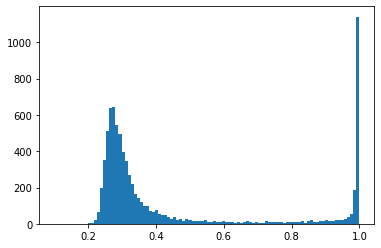

In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
plt.hist(pseudo_df["target"], bins=100, label="use target_real")
plt.show()

np.clip(pseudo_df['target'], 0.2, None)
10.0 0.0
(7975, 32)
(7327, 32)


0    6478
1     849
Name: real_sim, dtype: int64


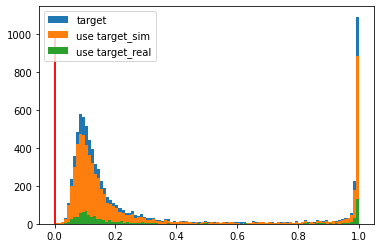

pseudo_df.shape: (7327, 32)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    if PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.771のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver18_lb0772.csv":
        print("np.clip(pseudo_df['target'], 0.2, None)")
        # lb0.772のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/lb0.774_kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_submission.csv":
        print("np.clip(pseudo_df['target'], 0.21, None)")
        # lb0.774のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.21, None)
        
    elif PSEUDO_CSV == "./kqi_dl/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep/lb0.775_kqi_3090_ex075_v2_tta_v3_pseudo_v3_hvflip_stride12_lb0771_1000_simall_100ep_submission_tta012.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
        
    elif PSEUDO_CSV == "./kaggle_dl/sub_csvs/sub_avg_ver25_lb0777.csv":
        print("np.clip(pseudo_df['target'], 0.22, None)")
        # lb0.775のは最小値に外れ値があるのでclip
        pseudo_df["target"] = np.clip(pseudo_df["target"], 0.22, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())

    # 振幅が外れ値のpseudo_label除く
    if (DEL_Outlier_Pseudo_MEAN_TH > 0) or (DEL_Outlier_Pseudo_STD_TH > 0):
        print(pseudo_df.shape)
        pseudo_df = pseudo_df[
            (pseudo_df["h1_l1_mean"] <= DEL_Outlier_Pseudo_MEAN_TH)
            & (pseudo_df["h1_l1_std"] <= DEL_Outlier_Pseudo_STD_TH)
        ].reset_index(drop=True)
        print(pseudo_df.shape)
        display(
            pseudo_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]]
            .describe()
            .style.background_gradient(cmap="Blues")
        )
        print(pseudo_df["real_sim"].value_counts())
        
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        _add_df = pd.merge(_add_df, _sum_df, on="id")
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/train/02887d232.hdf5
img.max(), img.min(): 1.0117304 -0.21019559
img.shape: (2, 360, 127)
y: 1


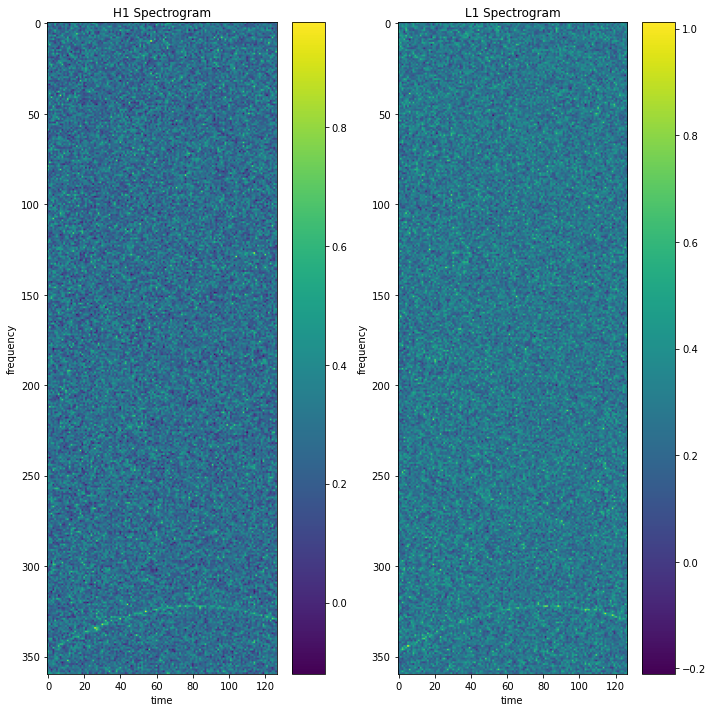

[[[0.325431   0.17457625 0.3396818  ... 0.26756728 0.15356174 0.3733073 ]
  [0.24188103 0.4714894  0.23059675 ... 0.2227322  0.2179172  0.18875326]
  [0.0889538  0.23328033 0.27681237 ... 0.3134874  0.2843316  0.21650119]
  ...
  [0.29948732 0.3049416  0.02045508 ... 0.07740886 0.18250325 0.3117947 ]
  [0.33356604 0.44505665 0.14893036 ... 0.36584744 0.34240994 0.06491428]
  [0.5128387  0.47561455 0.4670277  ... 0.29885525 0.3710205  0.28618434]]

 [[0.1543645  0.2675864  0.16885146 ... 0.28973526 0.27772895 0.24703233]
  [0.5235809  0.26831415 0.44855195 ... 0.52205944 0.32941082 0.2877957 ]
  [0.25386497 0.27994066 0.48412114 ... 0.21283908 0.41176757 0.31756184]
  ...
  [0.21310145 0.23574574 0.09281849 ... 0.18503961 0.22914225 0.21009928]
  [0.09034558 0.36396024 0.59807014 ... 0.36279297 0.14843479 0.41199002]
  [0.19628985 0.31054592 0.24057066 ... 0.22670898 0.47633463 0.36803928]]]

/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
im

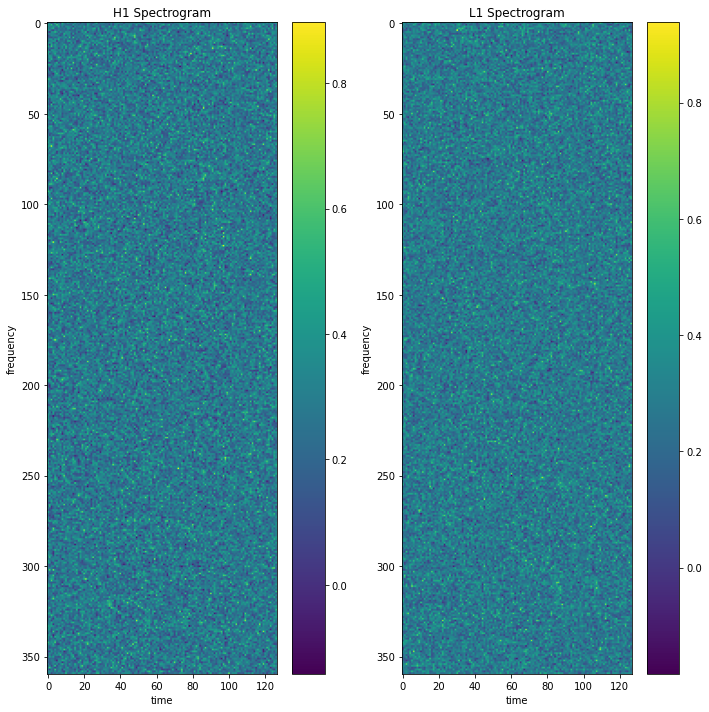

[[[0.1450048  0.3682932  0.06836234 ... 0.21421441 0.32271323 0.43579644]
  [0.48682094 0.32742298 0.58610773 ... 0.5108344  0.0259847  0.22669813]
  [0.32765684 0.35582396 0.28858188 ... 0.39393446 0.1303304  0.30876735]
  ...
  [0.2138556  0.05084979 0.28819835 ... 0.17450087 0.0531901  0.3562093 ]
  [0.33701128 0.37537438 0.3051324  ... 0.4751709  0.38561198 0.25694987]
  [0.22973242 0.3333396  0.08079948 ... 0.38302138 0.1153456  0.2325575 ]]

 [[0.43404981 0.3339342  0.19793278 ... 0.22434354 0.17163357 0.11064996]
  [0.2873523  0.37436566 0.22253533 ... 0.3980713  0.34168836 0.23814291]
  [0.50852656 0.19427258 0.35664275 ... 0.4201877  0.08385959 0.11578776]
  ...
  [0.25577104 0.30953246 0.2855743  ... 0.34895834 0.3929362  0.15591091]
  [0.17758438 0.35132727 0.40569088 ... 0.04587945 0.29197592 0.24282226]
  [0.18349406 0.26968902 0.34615487 ... 0.34275717 0.38036567 0.3071533 ]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /volume-ssd/kaggle_g2net2/npys/la

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.0+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        
        # これ以上の h1_mean+l1_mean, h1_std+l1_std を取る画像は除いて統計値出し、その統計値でalbの正規化行う
        self.alb_norm_mean_th = cfg_alb_norm_mean_th 
        self.alb_norm_std_th = cfg_alb_norm_std_th  
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
#    train_df = cv_split(train_df, 0, 10, cv_col="target")
#    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
#    print("debug train_df.shape:", train_df.shape)
#    test_df = test_df.iloc[:30]
#    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800, '
                 'EX007_NONSTAT_NOISE800, EX007_NONSTAT_NOISE1000]',
 'add_pseudo_dirs': '',
 'add_split_str': 'StratifiedKFold',
 'alb_norm_mean_th': 5,
 'alb_norm_std_th': 10,
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogits

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# calc_mean_std

In [35]:
%reload_ext autoreload
%autoreload 2
from src import calc_mean_std

_df = pd.concat([train_df, test_df])
print(_df.shape)

# 外れ値のデータは除く
_df = _df[
    (_df["h1_l1_mean"] <= CFG.alb_norm_mean_th)
    & (_df["h1_l1_std"] <= CFG.alb_norm_std_th)
].reset_index(drop=True)
print(_df.shape)
display(_df[["h1_mean", "l1_mean", "h1_std", "l1_std", "h1_l1_mean", "h1_l1_std"]].describe().style.background_gradient(cmap="Blues"))

_dataset = TrainDataset(_df, 
                        is_npy=CFG.is_npy, 
                        is_add_ch=CFG.is_add_ch,)
_loader = DataLoader(_dataset, 
                     #batch_size=CFG.batch_size * 2, # batch_size=1でないとだめ
                     shuffle=False, 
                     num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
X_MEAN, X_STD, X_MAX = calc_mean_std.calc_mean_std_max(_dataset, _loader, N_CHANNELS=CFG.ch)

(8575, 33)
(7927, 33)


==> Computing mean and std..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7927/7927 [00:08<00:00, 929.40it/s]

mean, std, max: [0.2797384  0.27972412] [0.12301076 0.12294598] [2.8376431 2.6048286]


# Transform

In [36]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    elif data == 'train_norm':
        print("train_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    elif data == 'valid_norm':
        print("valid_norm")
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            A.Normalize(
                mean=X_MEAN, std=X_STD, max_pixel_value=np.max(X_MAX),
                p=1.0,
            ),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [37]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


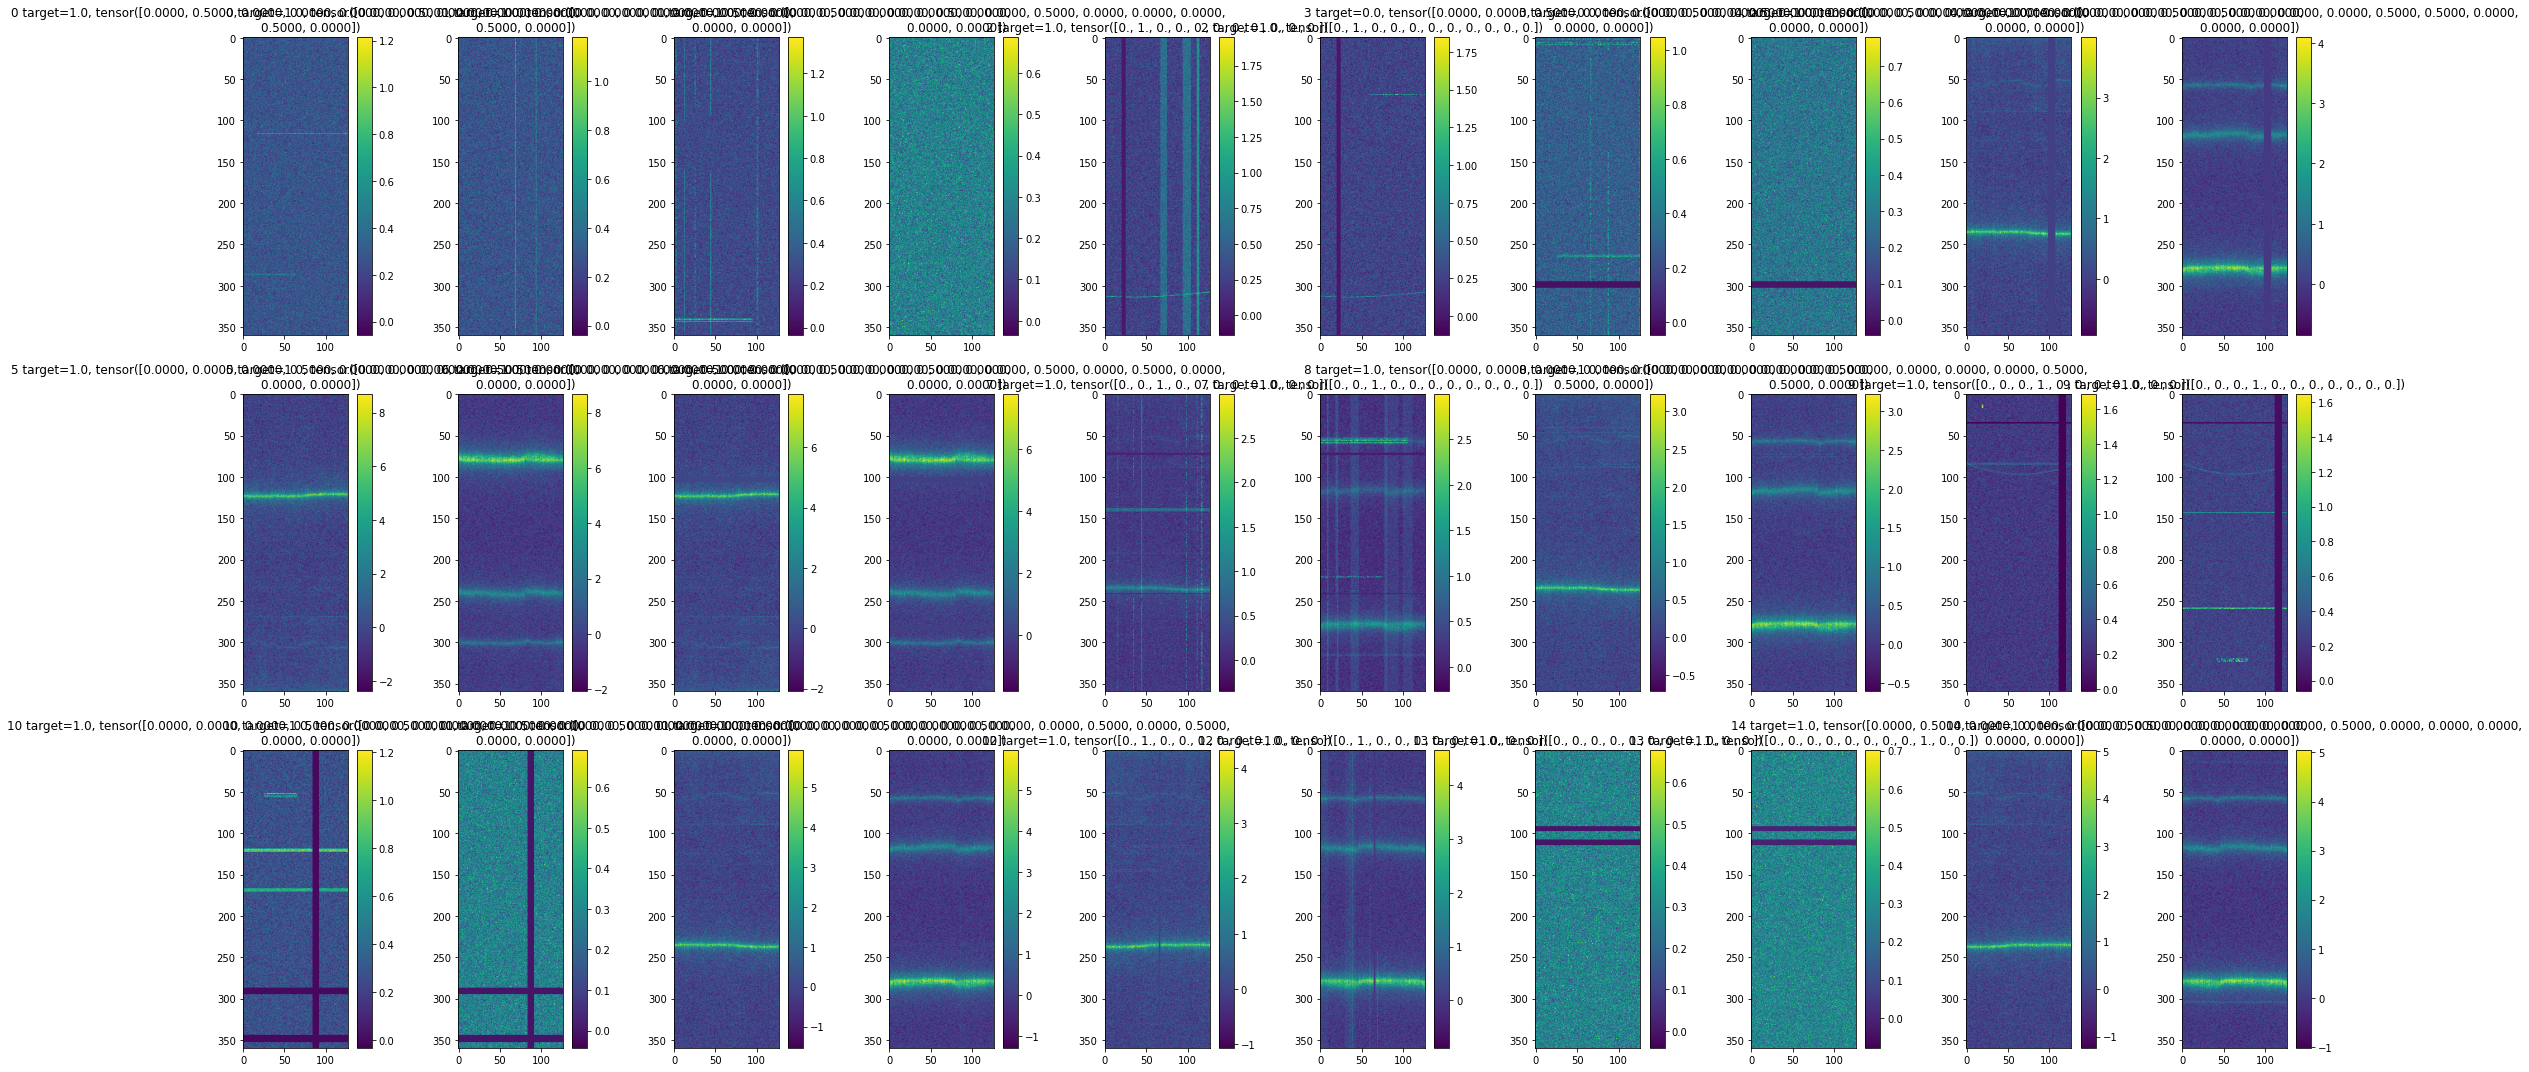

In [38]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        #transforms=get_transforms(data="train_norm"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [39]:
#%debug

In [40]:
#=====

# Model

In [41]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [45]:
from src import layer_edit
class CustomModelMultiOutputStride12(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)
        
        # 最初の conv レイヤーのモデル ストライドをfirst_strideに変更
        self.net = layer_edit.patch_first_conv_stride(self.net, first_stride=(1,2))
        
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // cfg.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

In [46]:
#=====

In [47]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [52]:
#=====

In [53]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [54]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [55]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [56]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [57]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [58]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [59]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            train_transforms_type = 'train_norm'
            valid_transforms_type = 'valid_norm'
        else:
            train_transforms_type = 'train'
            valid_transforms_type = 'valid'
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data=train_transforms_type), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data=valid_transforms_type),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [60]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (10193, 24)
pseudo_df.shape: (7327, 32)


> SEEDING DONE
fold0: (2039,)
fold1: (2039,)
fold2: (2039,)
fold3: (2038,)
fold4: (2038,)
fold  target
0     0         1239
      1          800
1     0         1239
      1          800
2     0         1239
      1          800
3     0         1238
      1          800
4     0         1238
      1          800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (18120, 40)
========== fold: 0, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/249] Elapsed 0m 4s (remain 16m 43s) Loss: 1.5506(1.5506) Grad: 47948.2930  LR: 4.0000e-06  
Epoch: [1][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.5361(1.5346) Grad: 49213.4570  LR: 4.0000e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 19s) Loss: 1.5610(1.5610) 


Epoch 1 - avg_train_loss: 1.5346  avg_val_loss: 1.5323  time: 121s
Epoch 1 - Score: 0.6604
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6604 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4967(1.5323) 


Epoch 1 - Save Best Loss: 1.5323 Model


Epoch: [2][0/249] Elapsed 0m 2s (remain 10m 24s) Loss: 1.5271(1.5271) Grad: 46132.2148  LR: 1.3600e-04  
Epoch: [2][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4223(1.4008) Grad: 53634.1523  LR: 1.3600e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3231(1.3231) 


Epoch 2 - avg_train_loss: 1.4008  avg_val_loss: 1.3025  time: 120s
Epoch 2 - Score: 0.8234
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8234 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1917(1.3025) 


Epoch 2 - Save Best Loss: 1.3025 Model


Epoch: [3][0/249] Elapsed 0m 2s (remain 10m 39s) Loss: 1.3363(1.3363) Grad: 40125.1641  LR: 2.6800e-04  
Epoch: [3][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3825(1.3635) Grad: 73475.1250  LR: 2.6800e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3289(1.3289) 


Epoch 3 - avg_train_loss: 1.3635  avg_val_loss: 1.3111  time: 119s
Epoch 3 - Score: 0.8374
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8374 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1722(1.3111) 
Epoch: [4][0/249] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3264(1.3264) Grad: 32568.1680  LR: 4.0000e-04  
Epoch: [4][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4088(1.3584) Grad: 45010.4531  LR: 4.0000e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2532(1.2532) 


Epoch 4 - avg_train_loss: 1.3584  avg_val_loss: 1.2722  time: 120s
Epoch 4 - Score: 0.8319
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.2722 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2240(1.2722) 
Epoch: [5][0/249] Elapsed 0m 2s (remain 11m 44s) Loss: 1.3683(1.3683) Grad: 45823.7891  LR: 3.9990e-04  
Epoch: [5][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3619(1.3464) Grad: 22777.9043  LR: 3.9990e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3356(1.3356) 


Epoch 5 - avg_train_loss: 1.3464  avg_val_loss: 1.2957  time: 121s
Epoch 5 - Score: 0.8517
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8517 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1833(1.2957) 
Epoch: [6][0/249] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3441(1.3441) Grad: 23501.6504  LR: 3.9961e-04  
Epoch: [6][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3357(1.3414) Grad: 22551.3301  LR: 3.9961e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 20s) Loss: 1.2927(1.2927) 


Epoch 6 - avg_train_loss: 1.3414  avg_val_loss: 1.2924  time: 121s
Epoch 6 - Score: 0.8409
Epoch 6 - lr: 3.9912e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1744(1.2924) 
Epoch: [7][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3428(1.3428) Grad: 18402.3164  LR: 3.9912e-04  
Epoch: [7][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3647(1.3380) Grad: 31143.8926  LR: 3.9912e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2440(1.2440) 


Epoch 7 - avg_train_loss: 1.3380  avg_val_loss: 1.2556  time: 120s
Epoch 7 - Score: 0.8602
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8602 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1609(1.2556) 


Epoch 7 - Save Best Loss: 1.2556 Model


Epoch: [8][0/249] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3603(1.3603) Grad: 23077.1836  LR: 3.9844e-04  
Epoch: [8][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3281(1.3342) Grad: 22248.9980  LR: 3.9844e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2517(1.2517) 


Epoch 8 - avg_train_loss: 1.3342  avg_val_loss: 1.2669  time: 120s
Epoch 8 - Score: 0.8598
Epoch 8 - lr: 3.9756e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1726(1.2669) 
Epoch: [9][0/249] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3139(1.3139) Grad: 24643.7461  LR: 3.9756e-04  
Epoch: [9][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3250(1.3280) Grad: 22114.2988  LR: 3.9756e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2577(1.2577) 


Epoch 9 - avg_train_loss: 1.3280  avg_val_loss: 1.2729  time: 120s
Epoch 9 - Score: 0.8579
Epoch 9 - lr: 3.9649e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1602(1.2729) 
Epoch: [10][0/249] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3370(1.3370) Grad: 20638.0820  LR: 3.9649e-04  
Epoch: [10][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3485(1.3306) Grad: 24606.9004  LR: 3.9649e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2218(1.2218) 


Epoch 10 - avg_train_loss: 1.3306  avg_val_loss: 1.2635  time: 120s
Epoch 10 - Score: 0.8878
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8878 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2029(1.2635) 
Epoch: [11][0/249] Elapsed 0m 2s (remain 11m 15s) Loss: 1.3086(1.3086) Grad: 16195.0498  LR: 3.9523e-04  
Epoch: [11][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3021(1.3297) Grad: 9549.2617  LR: 3.9523e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2895(1.2895) 


Epoch 11 - avg_train_loss: 1.3297  avg_val_loss: 1.2890  time: 120s
Epoch 11 - Score: 0.8645
Epoch 11 - lr: 3.9378e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1497(1.2890) 
Epoch: [12][0/249] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3423(1.3423) Grad: 19901.3652  LR: 3.9378e-04  
Epoch: [12][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3218(1.3305) Grad: 22334.8164  LR: 3.9378e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3095(1.3095) 


Epoch 12 - avg_train_loss: 1.3305  avg_val_loss: 1.2622  time: 119s
Epoch 12 - Score: 0.8765
Epoch 12 - lr: 3.9214e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1242(1.2622) 
Epoch: [13][0/249] Elapsed 0m 2s (remain 9m 36s) Loss: 1.3338(1.3338) Grad: 29484.9453  LR: 3.9214e-04  
Epoch: [13][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3258(1.3196) Grad: 23816.1758  LR: 3.9214e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2779(1.2779) 


Epoch 13 - avg_train_loss: 1.3196  avg_val_loss: 1.2556  time: 120s
Epoch 13 - Score: 0.8784
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2556 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1363(1.2556) 
Epoch: [14][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3416(1.3416) Grad: 18646.8926  LR: 3.9031e-04  
Epoch: [14][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3467(1.3167) Grad: 22199.6875  LR: 3.9031e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2137(1.2137) 


Epoch 14 - avg_train_loss: 1.3167  avg_val_loss: 1.2324  time: 120s
Epoch 14 - Score: 0.8826
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2324 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1522(1.2324) 
Epoch: [15][0/249] Elapsed 0m 2s (remain 10m 44s) Loss: 1.2969(1.2969) Grad: 21458.8105  LR: 3.8829e-04  
Epoch: [15][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2919(1.3177) Grad: 17329.6992  LR: 3.8829e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2174(1.2174) 


Epoch 15 - avg_train_loss: 1.3177  avg_val_loss: 1.2370  time: 120s
Epoch 15 - Score: 0.8666
Epoch 15 - lr: 3.8610e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1606(1.2370) 
Epoch: [16][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3206(1.3206) Grad: 19723.7109  LR: 3.8610e-04  
Epoch: [16][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2873(1.3222) Grad: 18727.2773  LR: 3.8610e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1959(1.1959) 


Epoch 16 - avg_train_loss: 1.3222  avg_val_loss: 1.2315  time: 121s
Epoch 16 - Score: 0.8387
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2315 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2013(1.2315) 
Epoch: [17][0/249] Elapsed 0m 1s (remain 8m 1s) Loss: 1.3148(1.3148) Grad: 23084.8008  LR: 3.8372e-04  
Epoch: [17][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3641(1.3189) Grad: 25202.9512  LR: 3.8372e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2111(1.2111) 


Epoch 17 - avg_train_loss: 1.3189  avg_val_loss: 1.2214  time: 119s
Epoch 17 - Score: 0.8776
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2214 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1403(1.2214) 
Epoch: [18][0/249] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3364(1.3364) Grad: 23260.7930  LR: 3.8116e-04  
Epoch: [18][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3199(1.3153) Grad: 19781.7969  LR: 3.8116e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2449(1.2449) 


Epoch 18 - avg_train_loss: 1.3153  avg_val_loss: 1.2304  time: 120s
Epoch 18 - Score: 0.8514
Epoch 18 - lr: 3.7842e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1799(1.2304) 
Epoch: [19][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3151(1.3151) Grad: 17018.5898  LR: 3.7842e-04  
Epoch: [19][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3220(1.3165) Grad: 17986.2305  LR: 3.7842e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2531(1.2531) 


Epoch 19 - avg_train_loss: 1.3165  avg_val_loss: 1.2186  time: 120s
Epoch 19 - Score: 0.8740
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Loss: 1.2186 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1357(1.2186) 
Epoch: [20][0/249] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2950(1.2950) Grad: 22624.8750  LR: 3.7551e-04  
Epoch: [20][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3153(1.3137) Grad: 23438.1934  LR: 3.7551e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1810(1.1810) 


Epoch 20 - avg_train_loss: 1.3137  avg_val_loss: 1.2069  time: 120s
Epoch 20 - Score: 0.8842
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2069 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1377(1.2069) 
Epoch: [21][0/249] Elapsed 0m 1s (remain 8m 12s) Loss: 1.2678(1.2678) Grad: 15245.5264  LR: 3.7243e-04  
Epoch: [21][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3194(1.3153) Grad: 24086.2949  LR: 3.7243e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2018(1.2018) 


Epoch 21 - avg_train_loss: 1.3153  avg_val_loss: 1.2352  time: 120s
Epoch 21 - Score: 0.8706
Epoch 21 - lr: 3.6918e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1475(1.2352) 
Epoch: [22][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3774(1.3774) Grad: 19494.9629  LR: 3.6918e-04  
Epoch: [22][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2710(1.3124) Grad: 23028.1914  LR: 3.6918e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1850(1.1850) 


Epoch 22 - avg_train_loss: 1.3124  avg_val_loss: 1.2414  time: 121s
Epoch 22 - Score: 0.8214
Epoch 22 - lr: 3.6576e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1821(1.2414) 
Epoch: [23][0/249] Elapsed 0m 2s (remain 9m 8s) Loss: 1.2933(1.2933) Grad: 18488.8887  LR: 3.6576e-04  
Epoch: [23][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3458(1.3091) Grad: 21851.6035  LR: 3.6576e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2077(1.2077) 


Epoch 23 - avg_train_loss: 1.3091  avg_val_loss: 1.2116  time: 121s
Epoch 23 - Score: 0.8761
Epoch 23 - lr: 3.6219e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1050(1.2116) 
Epoch: [24][0/249] Elapsed 0m 2s (remain 11m 14s) Loss: 1.2891(1.2891) Grad: 15622.4219  LR: 3.6219e-04  
Epoch: [24][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2830(1.3130) Grad: 16942.9258  LR: 3.6219e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1526(1.1526) 


Epoch 24 - avg_train_loss: 1.3130  avg_val_loss: 1.1983  time: 120s
Epoch 24 - Score: 0.8821
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.1983 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1181(1.1983) 
Epoch: [25][0/249] Elapsed 0m 2s (remain 10m 36s) Loss: 1.3723(1.3723) Grad: 27272.2246  LR: 3.5845e-04  
Epoch: [25][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3214(1.3084) Grad: 21080.8105  LR: 3.5845e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2736(1.2736) 


Epoch 25 - avg_train_loss: 1.3084  avg_val_loss: 1.2187  time: 120s
Epoch 25 - Score: 0.8858
Epoch 25 - lr: 3.5456e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1139(1.2187) 
Epoch: [26][0/249] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2881(1.2881) Grad: 19546.6836  LR: 3.5456e-04  
Epoch: [26][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3524(1.3088) Grad: 20037.8164  LR: 3.5456e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3042(1.3042) 


Epoch 26 - avg_train_loss: 1.3088  avg_val_loss: 1.2400  time: 119s
Epoch 26 - Score: 0.8702
Epoch 26 - lr: 3.5052e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1046(1.2400) 
Epoch: [27][0/249] Elapsed 0m 2s (remain 9m 1s) Loss: 1.2954(1.2954) Grad: 20940.8516  LR: 3.5052e-04  
Epoch: [27][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3130(1.3093) Grad: 9063.8584  LR: 3.5052e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2226(1.2226) 


Epoch 27 - avg_train_loss: 1.3093  avg_val_loss: 1.2189  time: 119s
Epoch 27 - Score: 0.8658
Epoch 27 - lr: 3.4634e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1515(1.2189) 
Epoch: [28][0/249] Elapsed 0m 2s (remain 10m 16s) Loss: 1.2906(1.2906) Grad: 21010.5938  LR: 3.4634e-04  
Epoch: [28][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2751(1.3107) Grad: 16638.4727  LR: 3.4634e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2042(1.2042) 


Epoch 28 - avg_train_loss: 1.3107  avg_val_loss: 1.2052  time: 120s
Epoch 28 - Score: 0.8768
Epoch 28 - lr: 3.4201e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1416(1.2052) 
Epoch: [29][0/249] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2840(1.2840) Grad: 19636.7207  LR: 3.4201e-04  
Epoch: [29][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2758(1.3065) Grad: 20477.1777  LR: 3.4201e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1972(1.1972) 


Epoch 29 - avg_train_loss: 1.3065  avg_val_loss: 1.2266  time: 119s
Epoch 29 - Score: 0.8762
Epoch 29 - lr: 3.3754e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1810(1.2266) 
Epoch: [30][0/249] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2792(1.2792) Grad: 20893.4199  LR: 3.3754e-04  
Epoch: [30][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3612(1.3053) Grad: 24667.4395  LR: 3.3754e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1868(1.1868) 


Epoch 30 - avg_train_loss: 1.3053  avg_val_loss: 1.2870  time: 120s
Epoch 30 - Score: 0.8110
Epoch 30 - lr: 3.3294e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4551(1.2870) 
Epoch: [31][0/249] Elapsed 0m 2s (remain 9m 41s) Loss: 1.2725(1.2725) Grad: 17717.5254  LR: 3.3294e-04  
Epoch: [31][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3420(1.3133) Grad: 9726.2100  LR: 3.3294e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2267(1.2267) 


Epoch 31 - avg_train_loss: 1.3133  avg_val_loss: 1.2190  time: 119s
Epoch 31 - Score: 0.8686
Epoch 31 - lr: 3.2821e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1547(1.2190) 
Epoch: [32][0/249] Elapsed 0m 2s (remain 10m 25s) Loss: 1.3330(1.3330) Grad: 17945.1465  LR: 3.2821e-04  
Epoch: [32][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3412(1.3069) Grad: 13756.1777  LR: 3.2821e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2318(1.2318) 


Epoch 32 - avg_train_loss: 1.3069  avg_val_loss: 1.2753  time: 119s
Epoch 32 - Score: 0.8425
Epoch 32 - lr: 3.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2886(1.2753) 
Epoch: [33][0/249] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2938(1.2938) Grad: 20584.2539  LR: 3.2336e-04  
Epoch: [33][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3020(1.3027) Grad: 17517.0430  LR: 3.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2006(1.2006) 


Epoch 33 - avg_train_loss: 1.3027  avg_val_loss: 1.2108  time: 120s
Epoch 33 - Score: 0.8801
Epoch 33 - lr: 3.1838e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1446(1.2108) 
Epoch: [34][0/249] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3285(1.3285) Grad: 21401.8359  LR: 3.1838e-04  
Epoch: [34][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3066(1.3060) Grad: 26078.9062  LR: 3.1838e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1903(1.1903) 


Epoch 34 - avg_train_loss: 1.3060  avg_val_loss: 1.2003  time: 120s
Epoch 34 - Score: 0.8770
Epoch 34 - lr: 3.1329e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1371(1.2003) 
Epoch: [35][0/249] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3143(1.3143) Grad: 19149.7227  LR: 3.1329e-04  
Epoch: [35][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3308(1.2982) Grad: 22833.1348  LR: 3.1329e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2966(1.2966) 


Epoch 35 - avg_train_loss: 1.2982  avg_val_loss: 1.2665  time: 120s
Epoch 35 - Score: 0.8247
Epoch 35 - lr: 3.0809e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1770(1.2665) 
Epoch: [36][0/249] Elapsed 0m 2s (remain 10m 54s) Loss: 1.3121(1.3121) Grad: 21241.5859  LR: 3.0809e-04  
Epoch: [36][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3146(1.3053) Grad: 14091.4004  LR: 3.0809e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1723(1.1723) 


Epoch 36 - avg_train_loss: 1.3053  avg_val_loss: 1.2251  time: 120s
Epoch 36 - Score: 0.8928
Epoch 36 - lr: 3.0279e-04
Epoch 36 - Save Best Score: 0.8928 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1373(1.2251) 
Epoch: [37][0/249] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2963(1.2963) Grad: 19579.8340  LR: 3.0279e-04  
Epoch: [37][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3214(1.2984) Grad: 18586.6855  LR: 3.0279e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2289(1.2289) 


Epoch 37 - avg_train_loss: 1.2984  avg_val_loss: 1.2338  time: 119s
Epoch 37 - Score: 0.8344
Epoch 37 - lr: 2.9739e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2052(1.2338) 
Epoch: [38][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3217(1.3217) Grad: 20340.2539  LR: 2.9739e-04  
Epoch: [38][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2898(1.2996) Grad: 22378.4727  LR: 2.9739e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2431(1.2431) 


Epoch 38 - avg_train_loss: 1.2996  avg_val_loss: 1.2843  time: 120s
Epoch 38 - Score: 0.8276
Epoch 38 - lr: 2.9189e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2493(1.2843) 
Epoch: [39][0/249] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3251(1.3251) Grad: 26280.1348  LR: 2.9189e-04  
Epoch: [39][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3612(1.2996) Grad: 26267.5176  LR: 2.9189e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1883(1.1883) 


Epoch 39 - avg_train_loss: 1.2996  avg_val_loss: 1.2354  time: 120s
Epoch 39 - Score: 0.8651
Epoch 39 - lr: 2.8630e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2430(1.2354) 
Epoch: [40][0/249] Elapsed 0m 2s (remain 11m 9s) Loss: 1.2725(1.2725) Grad: 20711.7109  LR: 2.8630e-04  
Epoch: [40][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2501(1.3002) Grad: 16575.4062  LR: 2.8630e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1569(1.1569) 


Epoch 40 - avg_train_loss: 1.3002  avg_val_loss: 1.2211  time: 120s
Epoch 40 - Score: 0.8745
Epoch 40 - lr: 2.8064e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1875(1.2211) 
Epoch: [41][0/249] Elapsed 0m 2s (remain 11m 16s) Loss: 1.2466(1.2466) Grad: 18573.2891  LR: 2.8064e-04  
Epoch: [41][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2948(1.3000) Grad: 17603.9590  LR: 2.8064e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4982(1.4982) 


Epoch 41 - avg_train_loss: 1.3000  avg_val_loss: 1.3156  time: 119s
Epoch 41 - Score: 0.8192
Epoch 41 - lr: 2.7489e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1339(1.3156) 
Epoch: [42][0/249] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3521(1.3521) Grad: 19650.0273  LR: 2.7489e-04  
Epoch: [42][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3020(1.2960) Grad: 19722.0859  LR: 2.7489e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2100(1.2100) 


Epoch 42 - avg_train_loss: 1.2960  avg_val_loss: 1.3270  time: 119s
Epoch 42 - Score: 0.8357
Epoch 42 - lr: 2.6907e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1488(1.3270) 
Epoch: [43][0/249] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2569(1.2569) Grad: 16779.7188  LR: 2.6907e-04  
Epoch: [43][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3708(1.3001) Grad: 30398.5977  LR: 2.6907e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3064(1.3064) 


Epoch 43 - avg_train_loss: 1.3001  avg_val_loss: 1.2803  time: 119s
Epoch 43 - Score: 0.8265
Epoch 43 - lr: 2.6319e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1311(1.2803) 
Epoch: [44][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3336(1.3336) Grad: 18302.0273  LR: 2.6319e-04  
Epoch: [44][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2875(1.2970) Grad: 19673.9590  LR: 2.6319e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1513(1.1513) 


Epoch 44 - avg_train_loss: 1.2970  avg_val_loss: 1.1949  time: 119s
Epoch 44 - Score: 0.8789
Epoch 44 - lr: 2.5724e-04
Epoch 44 - Save Best Loss: 1.1949 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1174(1.1949) 
Epoch: [45][0/249] Elapsed 0m 2s (remain 12m 18s) Loss: 1.3455(1.3455) Grad: 31121.4473  LR: 2.5724e-04  
Epoch: [45][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3177(1.2951) Grad: 21346.0566  LR: 2.5724e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1820(1.1820) 


Epoch 45 - avg_train_loss: 1.2951  avg_val_loss: 1.2058  time: 120s
Epoch 45 - Score: 0.8695
Epoch 45 - lr: 2.5124e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1406(1.2058) 
Epoch: [46][0/249] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3127(1.3127) Grad: 16186.5908  LR: 2.5124e-04  
Epoch: [46][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3374(1.2951) Grad: 22309.2441  LR: 2.5124e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5751(1.5751) 


Epoch 46 - avg_train_loss: 1.2951  avg_val_loss: 1.2787  time: 120s
Epoch 46 - Score: 0.8340
Epoch 46 - lr: 2.4519e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1489(1.2787) 
Epoch: [47][0/249] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2588(1.2588) Grad: 24369.5938  LR: 2.4519e-04  
Epoch: [47][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3135(1.2922) Grad: 19572.8926  LR: 2.4519e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1363(1.1363) 


Epoch 47 - avg_train_loss: 1.2922  avg_val_loss: 1.2347  time: 121s
Epoch 47 - Score: 0.8804
Epoch 47 - lr: 2.3910e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1633(1.2347) 
Epoch: [48][0/249] Elapsed 0m 2s (remain 10m 51s) Loss: 1.2942(1.2942) Grad: 27915.9727  LR: 2.3910e-04  
Epoch: [48][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2826(1.2942) Grad: 24197.5469  LR: 2.3910e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2093(1.2093) 


Epoch 48 - avg_train_loss: 1.2942  avg_val_loss: 1.2133  time: 120s
Epoch 48 - Score: 0.8685
Epoch 48 - lr: 2.3297e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1063(1.2133) 
Epoch: [49][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3244(1.3244) Grad: 22635.8711  LR: 2.3297e-04  
Epoch: [49][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3221(1.2949) Grad: 21692.9590  LR: 2.3297e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1773(1.1773) 


Epoch 49 - avg_train_loss: 1.2949  avg_val_loss: 1.2309  time: 120s
Epoch 49 - Score: 0.8796
Epoch 49 - lr: 2.2682e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1344(1.2309) 
Epoch: [50][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3076(1.3076) Grad: 20151.6309  LR: 2.2682e-04  
Epoch: [50][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2538(1.2941) Grad: 19469.1035  LR: 2.2682e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2103(1.2103) 


Epoch 50 - avg_train_loss: 1.2941  avg_val_loss: 1.2187  time: 120s
Epoch 50 - Score: 0.8679
Epoch 50 - lr: 2.2063e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1355(1.2187) 
Epoch: [51][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3005(1.3005) Grad: 16694.2637  LR: 2.2063e-04  
Epoch: [51][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2959(1.2919) Grad: 21477.0977  LR: 2.2063e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1904(1.1904) 


Epoch 51 - avg_train_loss: 1.2919  avg_val_loss: 1.2544  time: 119s
Epoch 51 - Score: 0.8765
Epoch 51 - lr: 2.1443e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2874(1.2544) 
Epoch: [52][0/249] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2913(1.2913) Grad: 18685.1445  LR: 2.1443e-04  
Epoch: [52][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3059(1.2903) Grad: 20876.9199  LR: 2.1443e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.9086(1.9086) 


Epoch 52 - avg_train_loss: 1.2903  avg_val_loss: 1.4425  time: 119s
Epoch 52 - Score: 0.7974
Epoch 52 - lr: 2.0822e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1535(1.4425) 
Epoch: [53][0/249] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3009(1.3009) Grad: 23524.6016  LR: 2.0822e-04  
Epoch: [53][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2711(1.2926) Grad: 19789.7715  LR: 2.0822e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4269(1.4269) 


Epoch 53 - avg_train_loss: 1.2926  avg_val_loss: 1.2353  time: 120s
Epoch 53 - Score: 0.8279
Epoch 53 - lr: 2.0200e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2311(1.2353) 
Epoch: [54][0/249] Elapsed 0m 2s (remain 10m 23s) Loss: 1.2981(1.2981) Grad: 20300.9902  LR: 2.0200e-04  
Epoch: [54][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2760(1.2906) Grad: 17049.4609  LR: 2.0200e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2022(1.2022) 


Epoch 54 - avg_train_loss: 1.2906  avg_val_loss: 1.2458  time: 120s
Epoch 54 - Score: 0.8552
Epoch 54 - lr: 1.9578e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1442(1.2458) 
Epoch: [55][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2796(1.2796) Grad: 25738.0547  LR: 1.9578e-04  
Epoch: [55][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3204(1.2906) Grad: 28712.7930  LR: 1.9578e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2063(1.2063) 


Epoch 55 - avg_train_loss: 1.2906  avg_val_loss: 1.2028  time: 119s
Epoch 55 - Score: 0.8720
Epoch 55 - lr: 1.8957e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1155(1.2028) 
Epoch: [56][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.2882(1.2882) Grad: 23317.7188  LR: 1.8957e-04  
Epoch: [56][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3048(1.2897) Grad: 20531.9551  LR: 1.8957e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3197(1.3197) 


Epoch 56 - avg_train_loss: 1.2897  avg_val_loss: 1.2364  time: 119s
Epoch 56 - Score: 0.8500
Epoch 56 - lr: 1.8337e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1400(1.2364) 
Epoch: [57][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3226(1.3226) Grad: 24908.0566  LR: 1.8337e-04  
Epoch: [57][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2521(1.2912) Grad: 26622.2363  LR: 1.8337e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2261(1.2261) 


Epoch 57 - avg_train_loss: 1.2912  avg_val_loss: 1.2105  time: 120s
Epoch 57 - Score: 0.8693
Epoch 57 - lr: 1.7718e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1249(1.2105) 
Epoch: [58][0/249] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2904(1.2904) Grad: 20576.5898  LR: 1.7718e-04  
Epoch: [58][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3354(1.2868) Grad: 26725.5547  LR: 1.7718e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2254(1.2254) 


Epoch 58 - avg_train_loss: 1.2868  avg_val_loss: 1.1998  time: 120s
Epoch 58 - Score: 0.8739
Epoch 58 - lr: 1.7103e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1230(1.1998) 
Epoch: [59][0/249] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3684(1.3684) Grad: 36929.3242  LR: 1.7103e-04  
Epoch: [59][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2637(1.2872) Grad: 25319.7402  LR: 1.7103e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2224(1.2224) 


Epoch 59 - avg_train_loss: 1.2872  avg_val_loss: 1.2195  time: 119s
Epoch 59 - Score: 0.8747
Epoch 59 - lr: 1.6490e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1512(1.2195) 
Epoch: [60][0/249] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2377(1.2377) Grad: 22420.2891  LR: 1.6490e-04  
Epoch: [60][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2987(1.2886) Grad: 18658.1777  LR: 1.6490e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1787(1.1787) 


Epoch 60 - avg_train_loss: 1.2886  avg_val_loss: 1.2147  time: 119s
Epoch 60 - Score: 0.8638
Epoch 60 - lr: 1.5881e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1419(1.2147) 
Epoch: [61][0/249] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2838(1.2838) Grad: 23951.2793  LR: 1.5881e-04  
Epoch: [61][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3226(1.2854) Grad: 21486.8438  LR: 1.5881e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1589(1.1589) 


Epoch 61 - avg_train_loss: 1.2854  avg_val_loss: 1.2131  time: 120s
Epoch 61 - Score: 0.8804
Epoch 61 - lr: 1.5276e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1089(1.2131) 
Epoch: [62][0/249] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2763(1.2763) Grad: 17756.1855  LR: 1.5276e-04  
Epoch: [62][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2894(1.2873) Grad: 18334.0723  LR: 1.5276e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1624(1.1624) 


Epoch 62 - avg_train_loss: 1.2873  avg_val_loss: 1.2066  time: 119s
Epoch 62 - Score: 0.8756
Epoch 62 - lr: 1.4676e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1009(1.2066) 
Epoch: [63][0/249] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2971(1.2971) Grad: 25142.6484  LR: 1.4676e-04  
Epoch: [63][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2637(1.2861) Grad: 9982.2119  LR: 1.4676e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3390(1.3390) 


Epoch 63 - avg_train_loss: 1.2861  avg_val_loss: 1.2285  time: 120s
Epoch 63 - Score: 0.8553
Epoch 63 - lr: 1.4081e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1404(1.2285) 
Epoch: [64][0/249] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2542(1.2542) Grad: 22101.4453  LR: 1.4081e-04  
Epoch: [64][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2576(1.2878) Grad: 12964.3545  LR: 1.4081e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1891(1.1891) 


Epoch 64 - avg_train_loss: 1.2878  avg_val_loss: 1.2177  time: 120s
Epoch 64 - Score: 0.8690
Epoch 64 - lr: 1.3493e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1640(1.2177) 
Epoch: [65][0/249] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3142(1.3142) Grad: 19825.5469  LR: 1.3493e-04  
Epoch: [65][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3267(1.2858) Grad: 24961.3867  LR: 1.3493e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1963(1.1963) 


Epoch 65 - avg_train_loss: 1.2858  avg_val_loss: 1.1934  time: 120s
Epoch 65 - Score: 0.8747
Epoch 65 - lr: 1.2911e-04
Epoch 65 - Save Best Loss: 1.1934 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1299(1.1934) 
Epoch: [66][0/249] Elapsed 0m 2s (remain 10m 0s) Loss: 1.2808(1.2808) Grad: 22240.3770  LR: 1.2911e-04  
Epoch: [66][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2978(1.2843) Grad: 27848.2344  LR: 1.2911e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1729(1.1729) 


Epoch 66 - avg_train_loss: 1.2843  avg_val_loss: 1.2125  time: 120s
Epoch 66 - Score: 0.8784
Epoch 66 - lr: 1.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1452(1.2125) 
Epoch: [67][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.2646(1.2646) Grad: 21241.9082  LR: 1.2336e-04  
Epoch: [67][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2146(1.2797) Grad: 20649.9375  LR: 1.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2005(1.2005) 


Epoch 67 - avg_train_loss: 1.2797  avg_val_loss: 1.2042  time: 120s
Epoch 67 - Score: 0.8743
Epoch 67 - lr: 1.1770e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1247(1.2042) 
Epoch: [68][0/249] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2715(1.2715) Grad: 22077.7266  LR: 1.1770e-04  
Epoch: [68][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2972(1.2806) Grad: 20005.7988  LR: 1.1770e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1830(1.1830) 


Epoch 68 - avg_train_loss: 1.2806  avg_val_loss: 1.1970  time: 119s
Epoch 68 - Score: 0.8752
Epoch 68 - lr: 1.1211e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1125(1.1970) 
Epoch: [69][0/249] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2565(1.2565) Grad: 32097.7324  LR: 1.1211e-04  
Epoch: [69][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2939(1.2793) Grad: 32032.0625  LR: 1.1211e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.6358(1.6358) 


Epoch 69 - avg_train_loss: 1.2793  avg_val_loss: 1.3150  time: 120s
Epoch 69 - Score: 0.8004
Epoch 69 - lr: 1.0661e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1692(1.3150) 
Epoch: [70][0/249] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3136(1.3136) Grad: 22911.5371  LR: 1.0661e-04  
Epoch: [70][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3429(1.2865) Grad: 13039.6016  LR: 1.0661e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2016(1.2016) 


Epoch 70 - avg_train_loss: 1.2865  avg_val_loss: 1.2095  time: 120s
Epoch 70 - Score: 0.8726
Epoch 70 - lr: 1.0121e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1415(1.2095) 
Epoch: [71][0/249] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2489(1.2489) Grad: 17180.6914  LR: 1.0121e-04  
Epoch: [71][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2520(1.2811) Grad: 24119.6328  LR: 1.0121e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.6238(1.6238) 


Epoch 71 - avg_train_loss: 1.2811  avg_val_loss: 1.3083  time: 119s
Epoch 71 - Score: 0.7921
Epoch 71 - lr: 9.5906e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1672(1.3083) 
Epoch: [72][0/249] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2981(1.2981) Grad: 21496.1973  LR: 9.5906e-05  
Epoch: [72][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2836(1.2812) Grad: 20208.4473  LR: 9.5906e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1718(1.1718) 


Epoch 72 - avg_train_loss: 1.2812  avg_val_loss: 1.2854  time: 119s
Epoch 72 - Score: 0.8399
Epoch 72 - lr: 9.0707e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1510(1.2854) 
Epoch: [73][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.2581(1.2581) Grad: 26423.1270  LR: 9.0707e-05  
Epoch: [73][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3041(1.2833) Grad: 27767.5605  LR: 9.0707e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4743(1.4743) 


Epoch 73 - avg_train_loss: 1.2833  avg_val_loss: 1.3208  time: 120s
Epoch 73 - Score: 0.8044
Epoch 73 - lr: 8.5619e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1958(1.3208) 
Epoch: [74][0/249] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2732(1.2732) Grad: 19225.2480  LR: 8.5619e-05  
Epoch: [74][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2845(1.2823) Grad: 22246.0645  LR: 8.5619e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1958(1.1958) 


Epoch 74 - avg_train_loss: 1.2823  avg_val_loss: 1.2266  time: 120s
Epoch 74 - Score: 0.8806
Epoch 74 - lr: 8.0644e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1246(1.2266) 
Epoch: [75][0/249] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3022(1.3022) Grad: 38248.3867  LR: 8.0644e-05  
Epoch: [75][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3295(1.2805) Grad: 21996.0781  LR: 8.0644e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1880(1.1880) 


Epoch 75 - avg_train_loss: 1.2805  avg_val_loss: 1.2479  time: 119s
Epoch 75 - Score: 0.8579
Epoch 75 - lr: 7.5790e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3130(1.2479) 
Epoch: [76][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3031(1.3031) Grad: 22543.0273  LR: 7.5790e-05  
Epoch: [76][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2884(1.2836) Grad: 37949.7578  LR: 7.5790e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2548(1.2548) 


Epoch 76 - avg_train_loss: 1.2836  avg_val_loss: 1.3050  time: 120s
Epoch 76 - Score: 0.7637
Epoch 76 - lr: 7.1060e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3197(1.3050) 
Epoch: [77][0/249] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2489(1.2489) Grad: 18915.7539  LR: 7.1060e-05  
Epoch: [77][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3127(1.2778) Grad: 25647.5840  LR: 7.1060e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2371(1.2371) 


Epoch 77 - avg_train_loss: 1.2778  avg_val_loss: 1.2127  time: 119s
Epoch 77 - Score: 0.8751
Epoch 77 - lr: 6.6460e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1346(1.2127) 
Epoch: [78][0/249] Elapsed 0m 2s (remain 8m 37s) Loss: 1.2242(1.2242) Grad: 19942.6523  LR: 6.6460e-05  
Epoch: [78][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2247(1.2763) Grad: 41212.4805  LR: 6.6460e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2073(1.2073) 


Epoch 78 - avg_train_loss: 1.2763  avg_val_loss: 1.2067  time: 119s
Epoch 78 - Score: 0.8726
Epoch 78 - lr: 6.1993e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1291(1.2067) 
Epoch: [79][0/249] Elapsed 0m 2s (remain 9m 12s) Loss: 1.2717(1.2717) Grad: 23324.4609  LR: 6.1993e-05  
Epoch: [79][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3076(1.2767) Grad: 20152.2344  LR: 6.1993e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2054(1.2054) 


Epoch 79 - avg_train_loss: 1.2767  avg_val_loss: 1.2253  time: 120s
Epoch 79 - Score: 0.8815
Epoch 79 - lr: 5.7664e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1392(1.2253) 
Epoch: [80][0/249] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2398(1.2398) Grad: 22010.5898  LR: 5.7664e-05  
Epoch: [80][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2891(1.2753) Grad: 27996.3691  LR: 5.7664e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1986(1.1986) 
EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1304(1.2257) 


Epoch 80 - avg_train_loss: 1.2753  avg_val_loss: 1.2257  time: 119s
Epoch 80 - Score: 0.8843
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2352(1.2352) Grad: 27785.9121  LR: 5.3478e-05  
Epoch: [81][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2152(1.2748) Grad: 24976.1621  LR: 5.3478e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5218(1.5218) 


Epoch 81 - avg_train_loss: 1.2748  avg_val_loss: 1.2941  time: 121s
Epoch 81 - Score: 0.8178
Epoch 81 - lr: 4.9438e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1705(1.2941) 
Epoch: [82][0/249] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2863(1.2863) Grad: 30517.9355  LR: 4.9438e-05  
Epoch: [82][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2788(1.2767) Grad: 22257.8379  LR: 4.9438e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2076(1.2076) 


Epoch 82 - avg_train_loss: 1.2767  avg_val_loss: 1.2124  time: 121s
Epoch 82 - Score: 0.8750
Epoch 82 - lr: 4.5549e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1317(1.2124) 
Epoch: [83][0/249] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3117(1.3117) Grad: 21601.7578  LR: 4.5549e-05  
Epoch: [83][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2752(1.2760) Grad: 18771.1367  LR: 4.5549e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3247(1.3247) 


Epoch 83 - avg_train_loss: 1.2760  avg_val_loss: 1.2817  time: 120s
Epoch 83 - Score: 0.8322
Epoch 83 - lr: 4.1815e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1452(1.2817) 
Epoch: [84][0/249] Elapsed 0m 2s (remain 11m 15s) Loss: 1.2794(1.2794) Grad: 19643.8457  LR: 4.1815e-05  
Epoch: [84][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3085(1.2764) Grad: 26339.5723  LR: 4.1815e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1990(1.1990) 


Epoch 84 - avg_train_loss: 1.2764  avg_val_loss: 1.2032  time: 120s
Epoch 84 - Score: 0.8783
Epoch 84 - lr: 3.8238e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1337(1.2032) 
Epoch: [85][0/249] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2994(1.2994) Grad: 24643.9453  LR: 3.8238e-05  
Epoch: [85][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2950(1.2747) Grad: 21811.3223  LR: 3.8238e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2152(1.2152) 


Epoch 85 - avg_train_loss: 1.2747  avg_val_loss: 1.2148  time: 119s
Epoch 85 - Score: 0.8810
Epoch 85 - lr: 3.4823e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1206(1.2148) 
Epoch: [86][0/249] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2821(1.2821) Grad: 42600.1875  LR: 3.4823e-05  
Epoch: [86][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2826(1.2762) Grad: 24687.7773  LR: 3.4823e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1908(1.1908) 


Epoch 86 - avg_train_loss: 1.2762  avg_val_loss: 1.2086  time: 119s
Epoch 86 - Score: 0.8766
Epoch 86 - lr: 3.1573e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0998(1.2086) 
Epoch: [87][0/249] Elapsed 0m 2s (remain 11m 36s) Loss: 1.3772(1.3772) Grad: 36252.7070  LR: 3.1573e-05  
Epoch: [87][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2734(1.2769) Grad: 20423.0273  LR: 3.1573e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1935(1.1935) 


Epoch 87 - avg_train_loss: 1.2769  avg_val_loss: 1.2091  time: 120s
Epoch 87 - Score: 0.8745
Epoch 87 - lr: 2.8491e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0984(1.2091) 
Epoch: [88][0/249] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3252(1.3252) Grad: 18105.9609  LR: 2.8491e-05  
Epoch: [88][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2810(1.2753) Grad: 22322.5176  LR: 2.8491e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1956(1.1956) 


Epoch 88 - avg_train_loss: 1.2753  avg_val_loss: 1.2127  time: 120s
Epoch 88 - Score: 0.8790
Epoch 88 - lr: 2.5581e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1057(1.2127) 
Epoch: [89][0/249] Elapsed 0m 2s (remain 10m 56s) Loss: 1.2624(1.2624) Grad: 35559.8164  LR: 2.5581e-05  
Epoch: [89][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2614(1.2773) Grad: 19476.7949  LR: 2.5581e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1659(1.1659) 


Epoch 89 - avg_train_loss: 1.2773  avg_val_loss: 1.2520  time: 120s
Epoch 89 - Score: 0.8215
Epoch 89 - lr: 2.2844e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3419(1.2520) 
Epoch: [90][0/249] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3177(1.3177) Grad: 31366.3906  LR: 2.2844e-05  
Epoch: [90][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2964(1.2763) Grad: 25960.0801  LR: 2.2844e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1910(1.1910) 


Epoch 90 - avg_train_loss: 1.2763  avg_val_loss: 1.2148  time: 119s
Epoch 90 - Score: 0.8732
Epoch 90 - lr: 2.0285e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1380(1.2148) 
Epoch: [91][0/249] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2333(1.2333) Grad: 26383.7441  LR: 2.0285e-05  
Epoch: [91][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3104(1.2742) Grad: 24953.9551  LR: 2.0285e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.7055(1.7055) 


Epoch 91 - avg_train_loss: 1.2742  avg_val_loss: 1.3662  time: 120s
Epoch 91 - Score: 0.7910
Epoch 91 - lr: 1.7904e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1543(1.3662) 
Epoch: [92][0/249] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3220(1.3220) Grad: 28615.1133  LR: 1.7904e-05  
Epoch: [92][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2960(1.2730) Grad: 26337.4199  LR: 1.7904e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.6427(1.6427) 


Epoch 92 - avg_train_loss: 1.2730  avg_val_loss: 1.3669  time: 120s
Epoch 92 - Score: 0.7965
Epoch 92 - lr: 1.5706e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1568(1.3669) 
Epoch: [93][0/249] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2783(1.2783) Grad: 19615.1328  LR: 1.5706e-05  
Epoch: [93][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3051(1.2762) Grad: 33357.0742  LR: 1.5706e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1567(1.1567) 


Epoch 93 - avg_train_loss: 1.2762  avg_val_loss: 1.2400  time: 119s
Epoch 93 - Score: 0.8461
Epoch 93 - lr: 1.3691e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3033(1.2400) 
Epoch: [94][0/249] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3196(1.3196) Grad: 39966.8984  LR: 1.3691e-05  
Epoch: [94][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2681(1.2727) Grad: 28009.8105  LR: 1.3691e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2039(1.2039) 


Epoch 94 - avg_train_loss: 1.2727  avg_val_loss: 1.2122  time: 120s
Epoch 94 - Score: 0.8740
Epoch 94 - lr: 1.1862e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1064(1.2122) 
Epoch: [95][0/249] Elapsed 0m 2s (remain 10m 23s) Loss: 1.2845(1.2845) Grad: 26374.7051  LR: 1.1862e-05  
Epoch: [95][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2303(1.2743) Grad: 23673.3184  LR: 1.1862e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1943(1.1943) 


Epoch 95 - avg_train_loss: 1.2743  avg_val_loss: 1.2124  time: 120s
Epoch 95 - Score: 0.8757
Epoch 95 - lr: 1.0221e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1062(1.2124) 
Epoch: [96][0/249] Elapsed 0m 2s (remain 9m 35s) Loss: 1.2667(1.2667) Grad: 24005.3223  LR: 1.0221e-05  
Epoch: [96][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2676(1.2754) Grad: 22280.6582  LR: 1.0221e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1753(1.1753) 


Epoch 96 - avg_train_loss: 1.2754  avg_val_loss: 1.2073  time: 120s
Epoch 96 - Score: 0.8751
Epoch 96 - lr: 8.7685e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1308(1.2073) 
Epoch: [97][0/249] Elapsed 0m 2s (remain 9m 40s) Loss: 1.2597(1.2597) Grad: 27472.1016  LR: 8.7685e-06  
Epoch: [97][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2401(1.2728) Grad: 21714.6660  LR: 8.7685e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1979(1.1979) 


Epoch 97 - avg_train_loss: 1.2728  avg_val_loss: 1.2141  time: 120s
Epoch 97 - Score: 0.8772
Epoch 97 - lr: 7.5071e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1111(1.2141) 
Epoch: [98][0/249] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2877(1.2877) Grad: 29005.9434  LR: 7.5071e-06  
Epoch: [98][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3106(1.2750) Grad: 29052.4023  LR: 7.5071e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1278(1.1278) 


Epoch 98 - avg_train_loss: 1.2750  avg_val_loss: 1.2026  time: 120s
Epoch 98 - Score: 0.8818
Epoch 98 - lr: 6.4377e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1229(1.2026) 
Epoch: [99][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.2862(1.2862) Grad: 34373.2969  LR: 6.4377e-06  
Epoch: [99][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3311(1.2734) Grad: 28176.6738  LR: 6.4377e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1744(1.1744) 


Epoch 99 - avg_train_loss: 1.2734  avg_val_loss: 1.2471  time: 120s
Epoch 99 - Score: 0.8613
Epoch 99 - lr: 5.5613e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2791(1.2471) 
Epoch: [100][0/249] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2598(1.2598) Grad: 22370.3828  LR: 5.5613e-06  
Epoch: [100][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2127(1.2724) Grad: 18387.4277  LR: 5.5613e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1951(1.1951) 


Epoch 100 - avg_train_loss: 1.2724  avg_val_loss: 1.2132  time: 119s
Epoch 100 - Score: 0.8773
Epoch 100 - lr: 4.8787e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1115(1.2132) 


========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8928
========== fold: 1, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/249] Elapsed 0m 2s (remain 10m 53s) Loss: 1.5504(1.5504) Grad: 46409.9180  LR: 4.0000e-06  
Epoch: [1][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.5391(1.5374) Grad: 46621.5898  LR: 4.0000e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5639(1.5639) 


Epoch 1 - avg_train_loss: 1.5374  avg_val_loss: 1.5313  time: 120s
Epoch 1 - Score: 0.7141
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.7141 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4810(1.5313) 


Epoch 1 - Save Best Loss: 1.5313 Model


Epoch: [2][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.5318(1.5318) Grad: 56721.9531  LR: 1.3600e-04  
Epoch: [2][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3363(1.4049) Grad: 39103.4961  LR: 1.3600e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3720(1.3720) 


Epoch 2 - avg_train_loss: 1.4049  avg_val_loss: 1.2754  time: 120s
Epoch 2 - Score: 0.8636
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8636 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1574(1.2754) 


Epoch 2 - Save Best Loss: 1.2754 Model


Epoch: [3][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3799(1.3799) Grad: 50889.6914  LR: 2.6800e-04  
Epoch: [3][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3201(1.3683) Grad: 33126.8359  LR: 2.6800e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3643(1.3643) 


Epoch 3 - avg_train_loss: 1.3683  avg_val_loss: 1.2892  time: 120s
Epoch 3 - Score: 0.8298
Epoch 3 - lr: 4.0000e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1866(1.2892) 
Epoch: [4][0/249] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3449(1.3449) Grad: 34131.9102  LR: 4.0000e-04  
Epoch: [4][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3409(1.3585) Grad: 22886.9277  LR: 4.0000e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3629(1.3629) 


Epoch 4 - avg_train_loss: 1.3585  avg_val_loss: 1.2917  time: 120s
Epoch 4 - Score: 0.8728
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8728 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2059(1.2917) 
Epoch: [5][0/249] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3380(1.3380) Grad: 30811.0742  LR: 3.9990e-04  
Epoch: [5][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3191(1.3490) Grad: 26004.8164  LR: 3.9990e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3910(1.3910) 


Epoch 5 - avg_train_loss: 1.3490  avg_val_loss: 1.2708  time: 120s
Epoch 5 - Score: 0.8711
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Loss: 1.2708 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1458(1.2708) 
Epoch: [6][0/249] Elapsed 0m 2s (remain 10m 25s) Loss: 1.3308(1.3308) Grad: 23928.9824  LR: 3.9961e-04  
Epoch: [6][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3152(1.3429) Grad: 22435.5352  LR: 3.9961e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3824(1.3824) 


Epoch 6 - avg_train_loss: 1.3429  avg_val_loss: 1.3542  time: 120s
Epoch 6 - Score: 0.7432
Epoch 6 - lr: 3.9912e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3785(1.3542) 
Epoch: [7][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3243(1.3243) Grad: 27803.1797  LR: 3.9912e-04  
Epoch: [7][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3357(1.3385) Grad: 21272.7305  LR: 3.9912e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3537(1.3537) 


Epoch 7 - avg_train_loss: 1.3385  avg_val_loss: 1.2591  time: 120s
Epoch 7 - Score: 0.8725
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2591 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1665(1.2591) 
Epoch: [8][0/249] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2988(1.2988) Grad: 29650.8613  LR: 3.9844e-04  
Epoch: [8][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3161(1.3338) Grad: 22633.5234  LR: 3.9844e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3347(1.3347) 


Epoch 8 - avg_train_loss: 1.3338  avg_val_loss: 1.2574  time: 120s
Epoch 8 - Score: 0.8773
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8773 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1486(1.2574) 


Epoch 8 - Save Best Loss: 1.2574 Model


Epoch: [9][0/249] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3244(1.3244) Grad: 23747.2910  LR: 3.9756e-04  
Epoch: [9][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3055(1.3299) Grad: 19599.9160  LR: 3.9756e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3479(1.3479) 


Epoch 9 - avg_train_loss: 1.3299  avg_val_loss: 1.2559  time: 120s
Epoch 9 - Score: 0.8856
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8856 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1571(1.2559) 


Epoch 9 - Save Best Loss: 1.2559 Model


Epoch: [10][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3288(1.3288) Grad: 21823.4141  LR: 3.9649e-04  
Epoch: [10][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3484(1.3292) Grad: 23452.5215  LR: 3.9649e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3829(1.3829) 


Epoch 10 - avg_train_loss: 1.3292  avg_val_loss: 1.2681  time: 120s
Epoch 10 - Score: 0.8854
Epoch 10 - lr: 3.9523e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1471(1.2681) 
Epoch: [11][0/249] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3228(1.3228) Grad: 22294.0059  LR: 3.9523e-04  
Epoch: [11][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2886(1.3272) Grad: 17330.6777  LR: 3.9523e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3697(1.3697) 


Epoch 11 - avg_train_loss: 1.3272  avg_val_loss: 1.2731  time: 120s
Epoch 11 - Score: 0.8723
Epoch 11 - lr: 3.9378e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1474(1.2731) 
Epoch: [12][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3503(1.3503) Grad: 23011.7793  LR: 3.9378e-04  
Epoch: [12][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3495(1.3239) Grad: 38583.5430  LR: 3.9378e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2510(1.2510) 


Epoch 12 - avg_train_loss: 1.3239  avg_val_loss: 1.2498  time: 120s
Epoch 12 - Score: 0.9028
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.9028 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1387(1.2498) 


Epoch 12 - Save Best Loss: 1.2498 Model


Epoch: [13][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3067(1.3067) Grad: 20166.9648  LR: 3.9214e-04  
Epoch: [13][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3671(1.3205) Grad: 37380.5586  LR: 3.9214e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3047(1.3047) 


Epoch 13 - avg_train_loss: 1.3205  avg_val_loss: 1.2336  time: 119s
Epoch 13 - Score: 0.8946
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2336 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1589(1.2336) 
Epoch: [14][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3089(1.3089) Grad: 20634.0020  LR: 3.9031e-04  
Epoch: [14][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3388(1.3214) Grad: 26549.3008  LR: 3.9031e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2206(1.2206) 


Epoch 14 - avg_train_loss: 1.3214  avg_val_loss: 1.2546  time: 120s
Epoch 14 - Score: 0.8996
Epoch 14 - lr: 3.8829e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1709(1.2546) 
Epoch: [15][0/249] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3325(1.3325) Grad: 20457.9102  LR: 3.8829e-04  
Epoch: [15][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3146(1.3197) Grad: 19559.8633  LR: 3.8829e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2388(1.2388) 


Epoch 15 - avg_train_loss: 1.3197  avg_val_loss: 1.2347  time: 120s
Epoch 15 - Score: 0.8836
Epoch 15 - lr: 3.8610e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1728(1.2347) 
Epoch: [16][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3481(1.3481) Grad: 23977.5820  LR: 3.8610e-04  
Epoch: [16][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3577(1.3195) Grad: 23572.0352  LR: 3.8610e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3510(1.3510) 


Epoch 16 - avg_train_loss: 1.3195  avg_val_loss: 1.2786  time: 120s
Epoch 16 - Score: 0.8891
Epoch 16 - lr: 3.8372e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1281(1.2786) 
Epoch: [17][0/249] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3526(1.3526) Grad: 22998.8027  LR: 3.8372e-04  
Epoch: [17][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3063(1.3190) Grad: 33091.2539  LR: 3.8372e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2464(1.2464) 


Epoch 17 - avg_train_loss: 1.3190  avg_val_loss: 1.2301  time: 120s
Epoch 17 - Score: 0.8967
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2301 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1704(1.2301) 
Epoch: [18][0/249] Elapsed 0m 1s (remain 8m 4s) Loss: 1.2847(1.2847) Grad: 24658.9727  LR: 3.8116e-04  
Epoch: [18][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3285(1.3193) Grad: 29017.8008  LR: 3.8116e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2978(1.2978) 


Epoch 18 - avg_train_loss: 1.3193  avg_val_loss: 1.2310  time: 120s
Epoch 18 - Score: 0.8658
Epoch 18 - lr: 3.7842e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1785(1.2310) 
Epoch: [19][0/249] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2794(1.2794) Grad: 20083.7930  LR: 3.7842e-04  
Epoch: [19][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2894(1.3161) Grad: 18490.6738  LR: 3.7842e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2217(1.2217) 


Epoch 19 - avg_train_loss: 1.3161  avg_val_loss: 1.2433  time: 119s
Epoch 19 - Score: 0.9040
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Score: 0.9040 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1325(1.2433) 
Epoch: [20][0/249] Elapsed 0m 2s (remain 10m 57s) Loss: 1.3007(1.3007) Grad: 22500.0957  LR: 3.7551e-04  
Epoch: [20][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3093(1.3157) Grad: 23202.7578  LR: 3.7551e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2166(1.2166) 


Epoch 20 - avg_train_loss: 1.3157  avg_val_loss: 1.2787  time: 120s
Epoch 20 - Score: 0.8044
Epoch 20 - lr: 3.7243e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3830(1.2787) 
Epoch: [21][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3266(1.3266) Grad: 22387.3047  LR: 3.7243e-04  
Epoch: [21][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3044(1.3141) Grad: 17272.2734  LR: 3.7243e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2444(1.2444) 


Epoch 21 - avg_train_loss: 1.3141  avg_val_loss: 1.2343  time: 120s
Epoch 21 - Score: 0.8909
Epoch 21 - lr: 3.6918e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1423(1.2343) 
Epoch: [22][0/249] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3321(1.3321) Grad: 22618.4219  LR: 3.6918e-04  
Epoch: [22][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2989(1.3110) Grad: 17774.0996  LR: 3.6918e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3533(1.3533) 


Epoch 22 - avg_train_loss: 1.3110  avg_val_loss: 1.2387  time: 120s
Epoch 22 - Score: 0.8983
Epoch 22 - lr: 3.6576e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1357(1.2387) 
Epoch: [23][0/249] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3273(1.3273) Grad: 14088.3574  LR: 3.6576e-04  
Epoch: [23][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3083(1.3130) Grad: 18506.0957  LR: 3.6576e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2650(1.2650) 


Epoch 23 - avg_train_loss: 1.3130  avg_val_loss: 1.2000  time: 120s
Epoch 23 - Score: 0.8943
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2000 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1393(1.2000) 
Epoch: [24][0/249] Elapsed 0m 2s (remain 10m 30s) Loss: 1.2400(1.2400) Grad: 15599.9844  LR: 3.6219e-04  
Epoch: [24][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4056(1.3113) Grad: 27499.5332  LR: 3.6219e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3616(1.3616) 


Epoch 24 - avg_train_loss: 1.3113  avg_val_loss: 1.2384  time: 120s
Epoch 24 - Score: 0.8851
Epoch 24 - lr: 3.5845e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1196(1.2384) 
Epoch: [25][0/249] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3311(1.3311) Grad: 26763.1836  LR: 3.5845e-04  
Epoch: [25][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2722(1.3094) Grad: 19822.3945  LR: 3.5845e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3453(1.3453) 


Epoch 25 - avg_train_loss: 1.3094  avg_val_loss: 1.2016  time: 121s
Epoch 25 - Score: 0.8885
Epoch 25 - lr: 3.5456e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1293(1.2016) 
Epoch: [26][0/249] Elapsed 0m 2s (remain 11m 25s) Loss: 1.2767(1.2767) Grad: 25047.8750  LR: 3.5456e-04  
Epoch: [26][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3268(1.3100) Grad: 30122.8359  LR: 3.5456e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2745(1.2745) 


Epoch 26 - avg_train_loss: 1.3100  avg_val_loss: 1.2183  time: 120s
Epoch 26 - Score: 0.8969
Epoch 26 - lr: 3.5052e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1288(1.2183) 
Epoch: [27][0/249] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2647(1.2647) Grad: 23258.6953  LR: 3.5052e-04  
Epoch: [27][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2930(1.3112) Grad: 17432.9961  LR: 3.5052e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2899(1.2899) 


Epoch 27 - avg_train_loss: 1.3112  avg_val_loss: 1.2061  time: 120s
Epoch 27 - Score: 0.8899
Epoch 27 - lr: 3.4634e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1294(1.2061) 
Epoch: [28][0/249] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3551(1.3551) Grad: 29002.8340  LR: 3.4634e-04  
Epoch: [28][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3161(1.3098) Grad: 24244.7305  LR: 3.4634e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2098(1.2098) 


Epoch 28 - avg_train_loss: 1.3098  avg_val_loss: 1.2519  time: 120s
Epoch 28 - Score: 0.8939
Epoch 28 - lr: 3.4201e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2696(1.2519) 
Epoch: [29][0/249] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2826(1.2826) Grad: 14274.9160  LR: 3.4201e-04  
Epoch: [29][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3083(1.3102) Grad: 20419.9512  LR: 3.4201e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3001(1.3001) 


Epoch 29 - avg_train_loss: 1.3102  avg_val_loss: 1.1938  time: 120s
Epoch 29 - Score: 0.8898
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.1938 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1232(1.1938) 
Epoch: [30][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.2831(1.2831) Grad: 18306.5059  LR: 3.3754e-04  
Epoch: [30][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2381(1.3089) Grad: 8162.0957  LR: 3.3754e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2187(1.2187) 


Epoch 30 - avg_train_loss: 1.3089  avg_val_loss: 1.2351  time: 120s
Epoch 30 - Score: 0.8937
Epoch 30 - lr: 3.3294e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1351(1.2351) 
Epoch: [31][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.3123(1.3123) Grad: 21869.2949  LR: 3.3294e-04  
Epoch: [31][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3212(1.3078) Grad: 23819.4395  LR: 3.3294e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2736(1.2736) 


Epoch 31 - avg_train_loss: 1.3078  avg_val_loss: 1.1957  time: 120s
Epoch 31 - Score: 0.8858
Epoch 31 - lr: 3.2821e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1203(1.1957) 
Epoch: [32][0/249] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3008(1.3008) Grad: 19136.1504  LR: 3.2821e-04  
Epoch: [32][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2932(1.3057) Grad: 20747.9766  LR: 3.2821e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2291(1.2291) 


Epoch 32 - avg_train_loss: 1.3057  avg_val_loss: 1.2098  time: 120s
Epoch 32 - Score: 0.8841
Epoch 32 - lr: 3.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1872(1.2098) 
Epoch: [33][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.2549(1.2549) Grad: 17157.5820  LR: 3.2336e-04  
Epoch: [33][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3239(1.3055) Grad: 18328.1992  LR: 3.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2985(1.2985) 


Epoch 33 - avg_train_loss: 1.3055  avg_val_loss: 1.2187  time: 120s
Epoch 33 - Score: 0.8845
Epoch 33 - lr: 3.1838e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1253(1.2187) 
Epoch: [34][0/249] Elapsed 0m 2s (remain 10m 20s) Loss: 1.3174(1.3174) Grad: 23041.9727  LR: 3.1838e-04  
Epoch: [34][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2762(1.3038) Grad: 16632.9277  LR: 3.1838e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3069(1.3069) 


Epoch 34 - avg_train_loss: 1.3038  avg_val_loss: 1.2136  time: 120s
Epoch 34 - Score: 0.8849
Epoch 34 - lr: 3.1329e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1332(1.2136) 
Epoch: [35][0/249] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2732(1.2732) Grad: 17493.5859  LR: 3.1329e-04  
Epoch: [35][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3347(1.3035) Grad: 23773.7852  LR: 3.1329e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2857(1.2857) 


Epoch 35 - avg_train_loss: 1.3035  avg_val_loss: 1.2722  time: 120s
Epoch 35 - Score: 0.7658
Epoch 35 - lr: 3.0809e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2840(1.2722) 
Epoch: [36][0/249] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3203(1.3203) Grad: 18623.1172  LR: 3.0809e-04  
Epoch: [36][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2933(1.3037) Grad: 19923.9551  LR: 3.0809e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2279(1.2279) 


Epoch 36 - avg_train_loss: 1.3037  avg_val_loss: 1.2000  time: 120s
Epoch 36 - Score: 0.8951
Epoch 36 - lr: 3.0279e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1043(1.2000) 
Epoch: [37][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3206(1.3206) Grad: 27435.2891  LR: 3.0279e-04  
Epoch: [37][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2474(1.3008) Grad: 17132.9434  LR: 3.0279e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3977(1.3977) 


Epoch 37 - avg_train_loss: 1.3008  avg_val_loss: 1.2276  time: 121s
Epoch 37 - Score: 0.8837
Epoch 37 - lr: 2.9739e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1207(1.2276) 
Epoch: [38][0/249] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2792(1.2792) Grad: 25667.3066  LR: 2.9739e-04  
Epoch: [38][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3183(1.3031) Grad: 22130.9824  LR: 2.9739e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2547(1.2547) 


Epoch 38 - avg_train_loss: 1.3031  avg_val_loss: 1.2103  time: 120s
Epoch 38 - Score: 0.8880
Epoch 38 - lr: 2.9189e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1529(1.2103) 
Epoch: [39][0/249] Elapsed 0m 2s (remain 10m 21s) Loss: 1.2952(1.2952) Grad: 17757.4980  LR: 2.9189e-04  
Epoch: [39][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3531(1.2992) Grad: 16798.0234  LR: 2.9189e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2441(1.2441) 


Epoch 39 - avg_train_loss: 1.2992  avg_val_loss: 1.2066  time: 120s
Epoch 39 - Score: 0.8906
Epoch 39 - lr: 2.8630e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1305(1.2066) 
Epoch: [40][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3146(1.3146) Grad: 21408.6660  LR: 2.8630e-04  
Epoch: [40][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3294(1.3020) Grad: 21458.7207  LR: 2.8630e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2849(1.2849) 


Epoch 40 - avg_train_loss: 1.3020  avg_val_loss: 1.2119  time: 119s
Epoch 40 - Score: 0.8983
Epoch 40 - lr: 2.8064e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1126(1.2119) 
Epoch: [41][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3221(1.3221) Grad: 19432.1582  LR: 2.8064e-04  
Epoch: [41][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2419(1.3018) Grad: 16568.5488  LR: 2.8064e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3162(1.3162) 


Epoch 41 - avg_train_loss: 1.3018  avg_val_loss: 1.2158  time: 121s
Epoch 41 - Score: 0.8833
Epoch 41 - lr: 2.7489e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1436(1.2158) 
Epoch: [42][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.2423(1.2423) Grad: 19678.1191  LR: 2.7489e-04  
Epoch: [42][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3531(1.3002) Grad: 21847.5352  LR: 2.7489e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2784(1.2784) 


Epoch 42 - avg_train_loss: 1.3002  avg_val_loss: 1.1817  time: 120s
Epoch 42 - Score: 0.8920
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Loss: 1.1817 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1085(1.1817) 
Epoch: [43][0/249] Elapsed 0m 2s (remain 9m 30s) Loss: 1.2781(1.2781) Grad: 21023.3770  LR: 2.6907e-04  
Epoch: [43][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2965(1.2990) Grad: 20871.8691  LR: 2.6907e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2968(1.2968) 


Epoch 43 - avg_train_loss: 1.2990  avg_val_loss: 1.2566  time: 121s
Epoch 43 - Score: 0.8406
Epoch 43 - lr: 2.6319e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2962(1.2566) 
Epoch: [44][0/249] Elapsed 0m 2s (remain 10m 36s) Loss: 1.3072(1.3072) Grad: 22509.9531  LR: 2.6319e-04  
Epoch: [44][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2866(1.2968) Grad: 19884.5176  LR: 2.6319e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2648(1.2648) 


Epoch 44 - avg_train_loss: 1.2968  avg_val_loss: 1.2122  time: 121s
Epoch 44 - Score: 0.8699
Epoch 44 - lr: 2.5724e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2061(1.2122) 
Epoch: [45][0/249] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2665(1.2665) Grad: 24526.4453  LR: 2.5724e-04  
Epoch: [45][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3162(1.2944) Grad: 21730.1582  LR: 2.5724e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2231(1.2231) 


Epoch 45 - avg_train_loss: 1.2944  avg_val_loss: 1.2618  time: 120s
Epoch 45 - Score: 0.8026
Epoch 45 - lr: 2.5124e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3859(1.2618) 
Epoch: [46][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3304(1.3304) Grad: 25762.8809  LR: 2.5124e-04  
Epoch: [46][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3007(1.2936) Grad: 17568.1250  LR: 2.5124e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2450(1.2450) 
EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2073(1.2066) 


Epoch 46 - avg_train_loss: 1.2936  avg_val_loss: 1.2066  time: 121s
Epoch 46 - Score: 0.8785
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/249] Elapsed 0m 2s (remain 11m 31s) Loss: 1.3656(1.3656) Grad: 24685.1152  LR: 2.4519e-04  
Epoch: [47][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3219(1.2956) Grad: 20271.6758  LR: 2.4519e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2602(1.2602) 


Epoch 47 - avg_train_loss: 1.2956  avg_val_loss: 1.1930  time: 121s
Epoch 47 - Score: 0.8924
Epoch 47 - lr: 2.3910e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1103(1.1930) 
Epoch: [48][0/249] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3066(1.3066) Grad: 21429.1387  LR: 2.3910e-04  
Epoch: [48][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3077(1.2951) Grad: 23243.3086  LR: 2.3910e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2783(1.2783) 


Epoch 48 - avg_train_loss: 1.2951  avg_val_loss: 1.2040  time: 120s
Epoch 48 - Score: 0.8927
Epoch 48 - lr: 2.3297e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1264(1.2040) 
Epoch: [49][0/249] Elapsed 0m 2s (remain 11m 2s) Loss: 1.3499(1.3499) Grad: 28382.6348  LR: 2.3297e-04  
Epoch: [49][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2636(1.2960) Grad: 19000.1289  LR: 2.3297e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.1947(1.1947) 


Epoch 49 - avg_train_loss: 1.2960  avg_val_loss: 1.2224  time: 120s
Epoch 49 - Score: 0.8939
Epoch 49 - lr: 2.2682e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1696(1.2224) 
Epoch: [50][0/249] Elapsed 0m 2s (remain 8m 25s) Loss: 1.3216(1.3216) Grad: 25700.8086  LR: 2.2682e-04  
Epoch: [50][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2879(1.2957) Grad: 17727.1484  LR: 2.2682e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3182(1.3182) 


Epoch 50 - avg_train_loss: 1.2957  avg_val_loss: 1.2043  time: 119s
Epoch 50 - Score: 0.8807
Epoch 50 - lr: 2.2063e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1399(1.2043) 
Epoch: [51][0/249] Elapsed 0m 2s (remain 9m 55s) Loss: 1.2815(1.2815) Grad: 15680.5996  LR: 2.2063e-04  
Epoch: [51][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3005(1.2922) Grad: 20782.6387  LR: 2.2063e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2104(1.2104) 


Epoch 51 - avg_train_loss: 1.2922  avg_val_loss: 1.2391  time: 119s
Epoch 51 - Score: 0.8823
Epoch 51 - lr: 2.1443e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2743(1.2391) 
Epoch: [52][0/249] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2229(1.2229) Grad: 21969.2363  LR: 2.1443e-04  
Epoch: [52][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3172(1.2907) Grad: 21522.5781  LR: 2.1443e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2472(1.2472) 


Epoch 52 - avg_train_loss: 1.2907  avg_val_loss: 1.1804  time: 120s
Epoch 52 - Score: 0.8912
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.1804 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1090(1.1804) 
Epoch: [53][0/249] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3248(1.3248) Grad: 32103.6641  LR: 2.0822e-04  
Epoch: [53][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2650(1.2921) Grad: 17554.6406  LR: 2.0822e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2302(1.2302) 


Epoch 53 - avg_train_loss: 1.2921  avg_val_loss: 1.2102  time: 121s
Epoch 53 - Score: 0.8865
Epoch 53 - lr: 2.0200e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1821(1.2102) 
Epoch: [54][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.2957(1.2957) Grad: 22676.0391  LR: 2.0200e-04  
Epoch: [54][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3074(1.2908) Grad: 19517.2363  LR: 2.0200e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1755(1.1755) 


Epoch 54 - avg_train_loss: 1.2908  avg_val_loss: 1.2082  time: 119s
Epoch 54 - Score: 0.9096
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Score: 0.9096 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1286(1.2082) 
Epoch: [55][0/249] Elapsed 0m 2s (remain 10m 52s) Loss: 1.3243(1.3243) Grad: 24802.5527  LR: 1.9578e-04  
Epoch: [55][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2819(1.2938) Grad: 19236.8262  LR: 1.9578e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3081(1.3081) 


Epoch 55 - avg_train_loss: 1.2938  avg_val_loss: 1.1859  time: 121s
Epoch 55 - Score: 0.8873
Epoch 55 - lr: 1.8957e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1129(1.1859) 
Epoch: [56][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2605(1.2605) Grad: 23955.3730  LR: 1.8957e-04  
Epoch: [56][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3095(1.2907) Grad: 18689.8535  LR: 1.8957e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2330(1.2330) 


Epoch 56 - avg_train_loss: 1.2907  avg_val_loss: 1.2312  time: 122s
Epoch 56 - Score: 0.8902
Epoch 56 - lr: 1.8337e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2121(1.2312) 
Epoch: [57][0/249] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3089(1.3089) Grad: 24544.6133  LR: 1.8337e-04  
Epoch: [57][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2566(1.2900) Grad: 21459.8496  LR: 1.8337e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2194(1.2194) 


Epoch 57 - avg_train_loss: 1.2900  avg_val_loss: 1.1957  time: 121s
Epoch 57 - Score: 0.8977
Epoch 57 - lr: 1.7718e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1579(1.1957) 
Epoch: [58][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3059(1.3059) Grad: 29140.7852  LR: 1.7718e-04  
Epoch: [58][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2698(1.2898) Grad: 19857.1914  LR: 1.7718e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1809(1.1809) 


Epoch 58 - avg_train_loss: 1.2898  avg_val_loss: 1.2098  time: 121s
Epoch 58 - Score: 0.9096
Epoch 58 - lr: 1.7103e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1619(1.2098) 
Epoch: [59][0/249] Elapsed 0m 2s (remain 10m 44s) Loss: 1.3555(1.3555) Grad: 24471.4629  LR: 1.7103e-04  
Epoch: [59][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2730(1.2921) Grad: 18797.7383  LR: 1.7103e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1826(1.1826) 


Epoch 59 - avg_train_loss: 1.2921  avg_val_loss: 1.2020  time: 122s
Epoch 59 - Score: 0.9100
Epoch 59 - lr: 1.6490e-04
Epoch 59 - Save Best Score: 0.9100 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1178(1.2020) 
Epoch: [60][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2721(1.2721) Grad: 24235.9883  LR: 1.6490e-04  
Epoch: [60][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3106(1.2885) Grad: 25275.8145  LR: 1.6490e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3132(1.3132) 


Epoch 60 - avg_train_loss: 1.2885  avg_val_loss: 1.2082  time: 120s
Epoch 60 - Score: 0.8970
Epoch 60 - lr: 1.5881e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1085(1.2082) 
Epoch: [61][0/249] Elapsed 0m 2s (remain 11m 7s) Loss: 1.2803(1.2803) Grad: 29524.9805  LR: 1.5881e-04  
Epoch: [61][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2668(1.2887) Grad: 20475.8516  LR: 1.5881e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2854(1.2854) 


Epoch 61 - avg_train_loss: 1.2887  avg_val_loss: 1.1763  time: 121s
Epoch 61 - Score: 0.8935
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1763 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1194(1.1763) 
Epoch: [62][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2929(1.2929) Grad: 21330.2266  LR: 1.5276e-04  
Epoch: [62][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3019(1.2877) Grad: 24564.5957  LR: 1.5276e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3174(1.3174) 


Epoch 62 - avg_train_loss: 1.2877  avg_val_loss: 1.1877  time: 120s
Epoch 62 - Score: 0.8901
Epoch 62 - lr: 1.4676e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1001(1.1877) 
Epoch: [63][0/249] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3269(1.3269) Grad: 27580.5723  LR: 1.4676e-04  
Epoch: [63][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3024(1.2892) Grad: 18225.0332  LR: 1.4676e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3381(1.3381) 


Epoch 63 - avg_train_loss: 1.2892  avg_val_loss: 1.1853  time: 120s
Epoch 63 - Score: 0.8890
Epoch 63 - lr: 1.4081e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1103(1.1853) 
Epoch: [64][0/249] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3312(1.3312) Grad: 20321.4160  LR: 1.4081e-04  
Epoch: [64][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2506(1.2847) Grad: 21691.0215  LR: 1.4081e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2984(1.2984) 


Epoch 64 - avg_train_loss: 1.2847  avg_val_loss: 1.1942  time: 120s
Epoch 64 - Score: 0.8959
Epoch 64 - lr: 1.3493e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1085(1.1942) 
Epoch: [65][0/249] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3233(1.3233) Grad: 27644.1133  LR: 1.3493e-04  
Epoch: [65][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2898(1.2854) Grad: 21098.2617  LR: 1.3493e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2814(1.2814) 


Epoch 65 - avg_train_loss: 1.2854  avg_val_loss: 1.1971  time: 120s
Epoch 65 - Score: 0.8891
Epoch 65 - lr: 1.2911e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1096(1.1971) 
Epoch: [66][0/249] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3120(1.3120) Grad: 22325.7598  LR: 1.2911e-04  
Epoch: [66][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3366(1.2866) Grad: 29844.8516  LR: 1.2911e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2139(1.2139) 


Epoch 66 - avg_train_loss: 1.2866  avg_val_loss: 1.2108  time: 120s
Epoch 66 - Score: 0.9028
Epoch 66 - lr: 1.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1092(1.2108) 
Epoch: [67][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3126(1.3126) Grad: 21444.0254  LR: 1.2336e-04  
Epoch: [67][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2632(1.2860) Grad: 19069.9219  LR: 1.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2753(1.2753) 


Epoch 67 - avg_train_loss: 1.2860  avg_val_loss: 1.1959  time: 120s
Epoch 67 - Score: 0.8929
Epoch 67 - lr: 1.1770e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1045(1.1959) 
Epoch: [68][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3052(1.3052) Grad: 36998.0625  LR: 1.1770e-04  
Epoch: [68][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2704(1.2850) Grad: 22694.0293  LR: 1.1770e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3324(1.3324) 


Epoch 68 - avg_train_loss: 1.2850  avg_val_loss: 1.1926  time: 121s
Epoch 68 - Score: 0.8876
Epoch 68 - lr: 1.1211e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1057(1.1926) 
Epoch: [69][0/249] Elapsed 0m 2s (remain 12m 11s) Loss: 1.2952(1.2952) Grad: 23064.1309  LR: 1.1211e-04  
Epoch: [69][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2613(1.2851) Grad: 20358.9258  LR: 1.1211e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2524(1.2524) 


Epoch 69 - avg_train_loss: 1.2851  avg_val_loss: 1.2767  time: 122s
Epoch 69 - Score: 0.8796
Epoch 69 - lr: 1.0661e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3177(1.2767) 
Epoch: [70][0/249] Elapsed 0m 2s (remain 11m 6s) Loss: 1.2492(1.2492) Grad: 23468.9238  LR: 1.0661e-04  
Epoch: [70][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3133(1.2846) Grad: 22994.4531  LR: 1.0661e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4592(1.4592) 


Epoch 70 - avg_train_loss: 1.2846  avg_val_loss: 1.2109  time: 121s
Epoch 70 - Score: 0.8813
Epoch 70 - lr: 1.0121e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1358(1.2109) 
Epoch: [71][0/249] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2402(1.2402) Grad: 20627.4434  LR: 1.0121e-04  
Epoch: [71][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2940(1.2859) Grad: 23160.3281  LR: 1.0121e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2860(1.2860) 


Epoch 71 - avg_train_loss: 1.2859  avg_val_loss: 1.1937  time: 120s
Epoch 71 - Score: 0.8950
Epoch 71 - lr: 9.5906e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1117(1.1937) 
Epoch: [72][0/249] Elapsed 0m 2s (remain 10m 57s) Loss: 1.2293(1.2293) Grad: 18876.4941  LR: 9.5906e-05  
Epoch: [72][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2533(1.2791) Grad: 10581.6309  LR: 9.5906e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2091(1.2091) 


Epoch 72 - avg_train_loss: 1.2791  avg_val_loss: 1.2649  time: 120s
Epoch 72 - Score: 0.8558
Epoch 72 - lr: 9.0707e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3145(1.2649) 
Epoch: [73][0/249] Elapsed 0m 2s (remain 11m 29s) Loss: 1.2575(1.2575) Grad: 27520.3086  LR: 9.0707e-05  
Epoch: [73][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.3087(1.2839) Grad: 24183.8184  LR: 9.0707e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2872(1.2872) 


Epoch 73 - avg_train_loss: 1.2839  avg_val_loss: 1.1788  time: 122s
Epoch 73 - Score: 0.8949
Epoch 73 - lr: 8.5619e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1060(1.1788) 
Epoch: [74][0/249] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3261(1.3261) Grad: 25108.5293  LR: 8.5619e-05  
Epoch: [74][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2713(1.2828) Grad: 26398.8926  LR: 8.5619e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3038(1.3038) 


Epoch 74 - avg_train_loss: 1.2828  avg_val_loss: 1.1856  time: 121s
Epoch 74 - Score: 0.8921
Epoch 74 - lr: 8.0644e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1145(1.1856) 
Epoch: [75][0/249] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3267(1.3267) Grad: 28543.8086  LR: 8.0644e-05  
Epoch: [75][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2812(1.2836) Grad: 21350.1191  LR: 8.0644e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3098(1.3098) 


Epoch 75 - avg_train_loss: 1.2836  avg_val_loss: 1.1848  time: 121s
Epoch 75 - Score: 0.8927
Epoch 75 - lr: 7.5790e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1102(1.1848) 
Epoch: [76][0/249] Elapsed 0m 2s (remain 10m 38s) Loss: 1.2690(1.2690) Grad: 23977.8418  LR: 7.5790e-05  
Epoch: [76][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3108(1.2810) Grad: 32018.3535  LR: 7.5790e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3229(1.3229) 


Epoch 76 - avg_train_loss: 1.2810  avg_val_loss: 1.1966  time: 121s
Epoch 76 - Score: 0.8947
Epoch 76 - lr: 7.1060e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1122(1.1966) 
Epoch: [77][0/249] Elapsed 0m 2s (remain 11m 40s) Loss: 1.3057(1.3057) Grad: 27791.2969  LR: 7.1060e-05  
Epoch: [77][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2782(1.2785) Grad: 21288.4434  LR: 7.1060e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4723(1.4723) 


Epoch 77 - avg_train_loss: 1.2785  avg_val_loss: 1.2167  time: 121s
Epoch 77 - Score: 0.8856
Epoch 77 - lr: 6.6460e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1521(1.2167) 
Epoch: [78][0/249] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2082(1.2082) Grad: 20107.4219  LR: 6.6460e-05  
Epoch: [78][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2092(1.2796) Grad: 12552.7568  LR: 6.6460e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.6451(1.6451) 


Epoch 78 - avg_train_loss: 1.2796  avg_val_loss: 1.2332  time: 120s
Epoch 78 - Score: 0.8772
Epoch 78 - lr: 6.1993e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1173(1.2332) 
Epoch: [79][0/249] Elapsed 0m 2s (remain 9m 18s) Loss: 1.2175(1.2175) Grad: 21512.0332  LR: 6.1993e-05  
Epoch: [79][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3094(1.2811) Grad: 23868.2461  LR: 6.1993e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2986(1.2986) 


Epoch 79 - avg_train_loss: 1.2811  avg_val_loss: 1.2088  time: 120s
Epoch 79 - Score: 0.8830
Epoch 79 - lr: 5.7664e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1981(1.2088) 
Epoch: [80][0/249] Elapsed 0m 2s (remain 11m 12s) Loss: 1.2531(1.2531) Grad: 30432.9551  LR: 5.7664e-05  
Epoch: [80][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3051(1.2784) Grad: 28951.7598  LR: 5.7664e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2018(1.2018) 


Epoch 80 - avg_train_loss: 1.2784  avg_val_loss: 1.2126  time: 120s
Epoch 80 - Score: 0.9135
Epoch 80 - lr: 5.3478e-05
Epoch 80 - Save Best Score: 0.9135 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1625(1.2126) 
Epoch: [81][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.2489(1.2489) Grad: 24775.0879  LR: 5.3478e-05  
Epoch: [81][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2345(1.2771) Grad: 25066.5234  LR: 5.3478e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1860(1.1860) 


Epoch 81 - avg_train_loss: 1.2771  avg_val_loss: 1.1949  time: 120s
Epoch 81 - Score: 0.9123
Epoch 81 - lr: 4.9438e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1280(1.1949) 
Epoch: [82][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.2704(1.2704) Grad: 21662.2109  LR: 4.9438e-05  
Epoch: [82][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2273(1.2778) Grad: 21195.0469  LR: 4.9438e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3243(1.3243) 


Epoch 82 - avg_train_loss: 1.2778  avg_val_loss: 1.1846  time: 120s
Epoch 82 - Score: 0.8936
Epoch 82 - lr: 4.5549e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1147(1.1846) 
Epoch: [83][0/249] Elapsed 0m 2s (remain 11m 26s) Loss: 1.3243(1.3243) Grad: 25512.0449  LR: 4.5549e-05  
Epoch: [83][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2687(1.2771) Grad: 22515.6992  LR: 4.5549e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3267(1.3267) 


Epoch 83 - avg_train_loss: 1.2771  avg_val_loss: 1.1832  time: 121s
Epoch 83 - Score: 0.8907
Epoch 83 - lr: 4.1815e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1112(1.1832) 
Epoch: [84][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2566(1.2566) Grad: 54526.6797  LR: 4.1815e-05  
Epoch: [84][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2950(1.2801) Grad: 22889.8809  LR: 4.1815e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4213(1.4213) 


Epoch 84 - avg_train_loss: 1.2801  avg_val_loss: 1.2015  time: 121s
Epoch 84 - Score: 0.8891
Epoch 84 - lr: 3.8238e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1379(1.2015) 
Epoch: [85][0/249] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2811(1.2811) Grad: 29878.3770  LR: 3.8238e-05  
Epoch: [85][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2574(1.2805) Grad: 26612.4727  LR: 3.8238e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3362(1.3362) 


Epoch 85 - avg_train_loss: 1.2805  avg_val_loss: 1.1838  time: 121s
Epoch 85 - Score: 0.8960
Epoch 85 - lr: 3.4823e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1122(1.1838) 
Epoch: [86][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2217(1.2217) Grad: 21888.4238  LR: 3.4823e-05  
Epoch: [86][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2484(1.2777) Grad: 18835.9590  LR: 3.4823e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2907(1.2907) 


Epoch 86 - avg_train_loss: 1.2777  avg_val_loss: 1.1856  time: 121s
Epoch 86 - Score: 0.8973
Epoch 86 - lr: 3.1573e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1062(1.1856) 
Epoch: [87][0/249] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2841(1.2841) Grad: 19184.1641  LR: 3.1573e-05  
Epoch: [87][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2743(1.2747) Grad: 27894.5957  LR: 3.1573e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3374(1.3374) 
EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1021(1.1802) 


Epoch 87 - avg_train_loss: 1.2747  avg_val_loss: 1.1802  time: 120s
Epoch 87 - Score: 0.8900
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/249] Elapsed 0m 2s (remain 10m 42s) Loss: 1.2990(1.2990) Grad: 22606.5254  LR: 2.8491e-05  
Epoch: [88][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3165(1.2757) Grad: 14239.5586  LR: 2.8491e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3377(1.3377) 


Epoch 88 - avg_train_loss: 1.2757  avg_val_loss: 1.1856  time: 120s
Epoch 88 - Score: 0.8929
Epoch 88 - lr: 2.5581e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1008(1.1856) 
Epoch: [89][0/249] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2957(1.2957) Grad: 25624.8145  LR: 2.5581e-05  
Epoch: [89][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2480(1.2714) Grad: 28024.9805  LR: 2.5581e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2780(1.2780) 


Epoch 89 - avg_train_loss: 1.2714  avg_val_loss: 1.2191  time: 119s
Epoch 89 - Score: 0.8937
Epoch 89 - lr: 2.2844e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2143(1.2191) 
Epoch: [90][0/249] Elapsed 0m 2s (remain 11m 27s) Loss: 1.2563(1.2563) Grad: 27761.6191  LR: 2.2844e-05  
Epoch: [90][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2807(1.2771) Grad: 24821.9902  LR: 2.2844e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3184(1.3184) 


Epoch 90 - avg_train_loss: 1.2771  avg_val_loss: 1.1842  time: 121s
Epoch 90 - Score: 0.8947
Epoch 90 - lr: 2.0285e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0984(1.1842) 
Epoch: [91][0/249] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2120(1.2120) Grad: 22954.4023  LR: 2.0285e-05  
Epoch: [91][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3184(1.2794) Grad: 20501.6445  LR: 2.0285e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3218(1.3218) 


Epoch 91 - avg_train_loss: 1.2794  avg_val_loss: 1.1904  time: 121s
Epoch 91 - Score: 0.8998
Epoch 91 - lr: 1.7904e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1171(1.1904) 
Epoch: [92][0/249] Elapsed 0m 2s (remain 10m 43s) Loss: 1.1963(1.1963) Grad: 19585.2148  LR: 1.7904e-05  
Epoch: [92][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2962(1.2777) Grad: 34906.4961  LR: 1.7904e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3166(1.3166) 


Epoch 92 - avg_train_loss: 1.2777  avg_val_loss: 1.1993  time: 120s
Epoch 92 - Score: 0.9013
Epoch 92 - lr: 1.5706e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1287(1.1993) 
Epoch: [93][0/249] Elapsed 0m 2s (remain 11m 17s) Loss: 1.2938(1.2938) Grad: 25500.7656  LR: 1.5706e-05  
Epoch: [93][248/249] Elapsed 1m 55s (remain 0m 0s) Loss: 1.2953(1.2742) Grad: 25908.0215  LR: 1.5706e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3076(1.3076) 


Epoch 93 - avg_train_loss: 1.2742  avg_val_loss: 1.1906  time: 121s
Epoch 93 - Score: 0.8997
Epoch 93 - lr: 1.3691e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1243(1.1906) 
Epoch: [94][0/249] Elapsed 0m 2s (remain 9m 58s) Loss: 1.2370(1.2370) Grad: 28625.9785  LR: 1.3691e-05  
Epoch: [94][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2775(1.2734) Grad: 21651.7344  LR: 1.3691e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1909(1.1909) 


Epoch 94 - avg_train_loss: 1.2734  avg_val_loss: 1.1963  time: 120s
Epoch 94 - Score: 0.9140
Epoch 94 - lr: 1.1862e-05
Epoch 94 - Save Best Score: 0.9140 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1502(1.1963) 
Epoch: [95][0/249] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3028(1.3028) Grad: 25254.2012  LR: 1.1862e-05  
Epoch: [95][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2247(1.2755) Grad: 27033.7480  LR: 1.1862e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 2.0750(2.0750) 


Epoch 95 - avg_train_loss: 1.2755  avg_val_loss: 1.2472  time: 120s
Epoch 95 - Score: 0.8728
Epoch 95 - lr: 1.0221e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1131(1.2472) 
Epoch: [96][0/249] Elapsed 0m 2s (remain 10m 25s) Loss: 1.1998(1.1998) Grad: 22802.8203  LR: 1.0221e-05  
Epoch: [96][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2915(1.2779) Grad: 29264.5410  LR: 1.0221e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5089(1.5089) 


Epoch 96 - avg_train_loss: 1.2779  avg_val_loss: 1.3776  time: 121s
Epoch 96 - Score: 0.7587
Epoch 96 - lr: 8.7685e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2227(1.3776) 
Epoch: [97][0/249] Elapsed 0m 2s (remain 9m 8s) Loss: 1.2897(1.2897) Grad: 23341.0977  LR: 8.7685e-06  
Epoch: [97][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2608(1.2743) Grad: 29353.4570  LR: 8.7685e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3284(1.3284) 


Epoch 97 - avg_train_loss: 1.2743  avg_val_loss: 1.1840  time: 120s
Epoch 97 - Score: 0.8947
Epoch 97 - lr: 7.5071e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1114(1.1840) 
Epoch: [98][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3320(1.3320) Grad: 21179.4844  LR: 7.5071e-06  
Epoch: [98][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2657(1.2749) Grad: 31854.5156  LR: 7.5071e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3385(1.3385) 


Epoch 98 - avg_train_loss: 1.2749  avg_val_loss: 1.1919  time: 121s
Epoch 98 - Score: 0.8963
Epoch 98 - lr: 6.4377e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1142(1.1919) 
Epoch: [99][0/249] Elapsed 0m 2s (remain 10m 50s) Loss: 1.2226(1.2226) Grad: 24936.3926  LR: 6.4377e-06  
Epoch: [99][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2305(1.2788) Grad: 21613.0156  LR: 6.4377e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3242(1.3242) 


Epoch 99 - avg_train_loss: 1.2788  avg_val_loss: 1.2050  time: 121s
Epoch 99 - Score: 0.8987
Epoch 99 - lr: 5.5613e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1471(1.2050) 
Epoch: [100][0/249] Elapsed 0m 2s (remain 10m 16s) Loss: 1.3208(1.3208) Grad: 27552.3828  LR: 5.5613e-06  
Epoch: [100][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2824(1.2733) Grad: 25279.7188  LR: 5.5613e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2424(1.2424) 


Epoch 100 - avg_train_loss: 1.2733  avg_val_loss: 1.2100  time: 120s
Epoch 100 - Score: 0.8987
Epoch 100 - lr: 4.8787e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1810(1.2100) 


========== fold: 1 seed: 0 result ==========
fold1 Score: 0.9140
========== fold: 2, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/249] Elapsed 0m 2s (remain 11m 12s) Loss: 1.5471(1.5471) Grad: 44674.7969  LR: 4.0000e-06  
Epoch: [1][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.5340(1.5399) Grad: 47663.1289  LR: 4.0000e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5515(1.5515) 


Epoch 1 - avg_train_loss: 1.5399  avg_val_loss: 1.5339  time: 120s
Epoch 1 - Score: 0.6656
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6656 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4986(1.5339) 


Epoch 1 - Save Best Loss: 1.5339 Model


Epoch: [2][0/249] Elapsed 0m 2s (remain 9m 30s) Loss: 1.5344(1.5344) Grad: 45888.3047  LR: 1.3600e-04  
Epoch: [2][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3312(1.4038) Grad: 39108.9375  LR: 1.3600e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3213(1.3213) 


Epoch 2 - avg_train_loss: 1.4038  avg_val_loss: 1.3079  time: 120s
Epoch 2 - Score: 0.8533
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8533 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1782(1.3079) 


Epoch 2 - Save Best Loss: 1.3079 Model


Epoch: [3][0/249] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3627(1.3627) Grad: 40366.2305  LR: 2.6800e-04  
Epoch: [3][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4306(1.3663) Grad: 50670.1367  LR: 2.6800e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2755(1.2755) 


Epoch 3 - avg_train_loss: 1.3663  avg_val_loss: 1.2813  time: 120s
Epoch 3 - Score: 0.8678
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8678 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2173(1.2813) 


Epoch 3 - Save Best Loss: 1.2813 Model


Epoch: [4][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3113(1.3113) Grad: 25877.9961  LR: 4.0000e-04  
Epoch: [4][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3824(1.3564) Grad: 53959.8711  LR: 4.0000e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2704(1.2704) 


Epoch 4 - avg_train_loss: 1.3564  avg_val_loss: 1.2720  time: 120s
Epoch 4 - Score: 0.8581
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.2720 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1874(1.2720) 
Epoch: [5][0/249] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3594(1.3594) Grad: 33251.9805  LR: 3.9990e-04  
Epoch: [5][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4065(1.3501) Grad: 33216.2266  LR: 3.9990e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2541(1.2541) 


Epoch 5 - avg_train_loss: 1.3501  avg_val_loss: 1.2674  time: 120s
Epoch 5 - Score: 0.8608
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Loss: 1.2674 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2167(1.2674) 
Epoch: [6][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.3352(1.3352) Grad: 32238.4043  LR: 3.9961e-04  
Epoch: [6][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3449(1.3422) Grad: 25479.1230  LR: 3.9961e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2427(1.2427) 


Epoch 6 - avg_train_loss: 1.3422  avg_val_loss: 1.2411  time: 119s
Epoch 6 - Score: 0.8658
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Loss: 1.2411 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1740(1.2411) 
Epoch: [7][0/249] Elapsed 0m 2s (remain 9m 35s) Loss: 1.3171(1.3171) Grad: 24285.2266  LR: 3.9912e-04  
Epoch: [7][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3515(1.3432) Grad: 10095.2949  LR: 3.9912e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2479(1.2479) 


Epoch 7 - avg_train_loss: 1.3432  avg_val_loss: 1.2546  time: 120s
Epoch 7 - Score: 0.8812
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8812 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1821(1.2546) 
Epoch: [8][0/249] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3668(1.3668) Grad: 19312.8633  LR: 3.9844e-04  
Epoch: [8][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3473(1.3365) Grad: 25515.8633  LR: 3.9844e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2543(1.2543) 


Epoch 8 - avg_train_loss: 1.3365  avg_val_loss: 1.2462  time: 120s
Epoch 8 - Score: 0.8690
Epoch 8 - lr: 3.9756e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1383(1.2462) 
Epoch: [9][0/249] Elapsed 0m 2s (remain 10m 49s) Loss: 1.3477(1.3477) Grad: 32926.0859  LR: 3.9756e-04  
Epoch: [9][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3484(1.3314) Grad: 24623.4941  LR: 3.9756e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3231(1.3231) 


Epoch 9 - avg_train_loss: 1.3314  avg_val_loss: 1.2670  time: 120s
Epoch 9 - Score: 0.8568
Epoch 9 - lr: 3.9649e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1389(1.2670) 
Epoch: [10][0/249] Elapsed 0m 2s (remain 10m 0s) Loss: 1.2718(1.2718) Grad: 17086.1914  LR: 3.9649e-04  
Epoch: [10][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3601(1.3259) Grad: 33009.3867  LR: 3.9649e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2584(1.2584) 


Epoch 10 - avg_train_loss: 1.3259  avg_val_loss: 1.3104  time: 120s
Epoch 10 - Score: 0.8093
Epoch 10 - lr: 3.9523e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3793(1.3104) 
Epoch: [11][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3160(1.3160) Grad: 17087.0273  LR: 3.9523e-04  
Epoch: [11][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3597(1.3264) Grad: 27174.4141  LR: 3.9523e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2341(1.2341) 


Epoch 11 - avg_train_loss: 1.3264  avg_val_loss: 1.2246  time: 119s
Epoch 11 - Score: 0.8757
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2246 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1705(1.2246) 
Epoch: [12][0/249] Elapsed 0m 2s (remain 8m 37s) Loss: 1.2611(1.2611) Grad: 17640.9805  LR: 3.9378e-04  
Epoch: [12][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3483(1.3247) Grad: 17452.1016  LR: 3.9378e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2306(1.2306) 


Epoch 12 - avg_train_loss: 1.3247  avg_val_loss: 1.2423  time: 119s
Epoch 12 - Score: 0.8716
Epoch 12 - lr: 3.9214e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1607(1.2423) 
Epoch: [13][0/249] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2843(1.2843) Grad: 13020.8115  LR: 3.9214e-04  
Epoch: [13][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2900(1.3227) Grad: 15487.2363  LR: 3.9214e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2581(1.2581) 


Epoch 13 - avg_train_loss: 1.3227  avg_val_loss: 1.2443  time: 120s
Epoch 13 - Score: 0.8799
Epoch 13 - lr: 3.9031e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1320(1.2443) 
Epoch: [14][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2899(1.2899) Grad: 19681.0215  LR: 3.9031e-04  
Epoch: [14][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3048(1.3224) Grad: 26304.8984  LR: 3.9031e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2182(1.2182) 


Epoch 14 - avg_train_loss: 1.3224  avg_val_loss: 1.2158  time: 119s
Epoch 14 - Score: 0.8749
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Loss: 1.2158 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1659(1.2158) 
Epoch: [15][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3132(1.3132) Grad: 22621.9824  LR: 3.8829e-04  
Epoch: [15][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3268(1.3198) Grad: 19461.5879  LR: 3.8829e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2541(1.2541) 


Epoch 15 - avg_train_loss: 1.3198  avg_val_loss: 1.2353  time: 119s
Epoch 15 - Score: 0.8610
Epoch 15 - lr: 3.8610e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1559(1.2353) 
Epoch: [16][0/249] Elapsed 0m 2s (remain 11m 22s) Loss: 1.3058(1.3058) Grad: 23110.1836  LR: 3.8610e-04  
Epoch: [16][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3799(1.3201) Grad: 25095.8691  LR: 3.8610e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2277(1.2277) 


Epoch 16 - avg_train_loss: 1.3201  avg_val_loss: 1.2259  time: 120s
Epoch 16 - Score: 0.8582
Epoch 16 - lr: 3.8372e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1597(1.2259) 
Epoch: [17][0/249] Elapsed 0m 2s (remain 11m 46s) Loss: 1.3326(1.3326) Grad: 15717.0801  LR: 3.8372e-04  
Epoch: [17][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3704(1.3179) Grad: 28677.9336  LR: 3.8372e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2831(1.2831) 


Epoch 17 - avg_train_loss: 1.3179  avg_val_loss: 1.2352  time: 120s
Epoch 17 - Score: 0.8776
Epoch 17 - lr: 3.8116e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1355(1.2352) 
Epoch: [18][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3116(1.3116) Grad: 16260.9980  LR: 3.8116e-04  
Epoch: [18][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3064(1.3178) Grad: 10711.5615  LR: 3.8116e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2225(1.2225) 


Epoch 18 - avg_train_loss: 1.3178  avg_val_loss: 1.2422  time: 119s
Epoch 18 - Score: 0.8302
Epoch 18 - lr: 3.7842e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1582(1.2422) 
Epoch: [19][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3511(1.3511) Grad: 28661.1582  LR: 3.7842e-04  
Epoch: [19][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3287(1.3165) Grad: 17331.9160  LR: 3.7842e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2687(1.2687) 


Epoch 19 - avg_train_loss: 1.3165  avg_val_loss: 1.2221  time: 120s
Epoch 19 - Score: 0.8819
Epoch 19 - lr: 3.7551e-04
Epoch 19 - Save Best Score: 0.8819 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1256(1.2221) 
Epoch: [20][0/249] Elapsed 0m 2s (remain 11m 25s) Loss: 1.3126(1.3126) Grad: 17917.1250  LR: 3.7551e-04  
Epoch: [20][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2788(1.3150) Grad: 16428.2637  LR: 3.7551e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2105(1.2105) 


Epoch 20 - avg_train_loss: 1.3150  avg_val_loss: 1.2074  time: 120s
Epoch 20 - Score: 0.8859
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Score: 0.8859 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1430(1.2074) 


Epoch 20 - Save Best Loss: 1.2074 Model


Epoch: [21][0/249] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2908(1.2908) Grad: 24353.4941  LR: 3.7243e-04  
Epoch: [21][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2903(1.3118) Grad: 20865.0352  LR: 3.7243e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1854(1.1854) 


Epoch 21 - avg_train_loss: 1.3118  avg_val_loss: 1.1996  time: 120s
Epoch 21 - Score: 0.8903
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Score: 0.8903 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1382(1.1996) 


Epoch 21 - Save Best Loss: 1.1996 Model


Epoch: [22][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2935(1.2935) Grad: 19916.1445  LR: 3.6918e-04  
Epoch: [22][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2508(1.3128) Grad: 16930.9629  LR: 3.6918e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2926(1.2926) 


Epoch 22 - avg_train_loss: 1.3128  avg_val_loss: 1.2818  time: 119s
Epoch 22 - Score: 0.8156
Epoch 22 - lr: 3.6576e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1844(1.2818) 
Epoch: [23][0/249] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3968(1.3968) Grad: 25355.1875  LR: 3.6576e-04  
Epoch: [23][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2825(1.3130) Grad: 20499.3730  LR: 3.6576e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3311(1.3311) 


Epoch 23 - avg_train_loss: 1.3130  avg_val_loss: 1.2391  time: 119s
Epoch 23 - Score: 0.8524
Epoch 23 - lr: 3.6219e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1797(1.2391) 
Epoch: [24][0/249] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3022(1.3022) Grad: 25546.2383  LR: 3.6219e-04  
Epoch: [24][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3316(1.3141) Grad: 21877.3516  LR: 3.6219e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1901(1.1901) 


Epoch 24 - avg_train_loss: 1.3141  avg_val_loss: 1.1967  time: 119s
Epoch 24 - Score: 0.8853
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.1967 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1402(1.1967) 
Epoch: [25][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3165(1.3165) Grad: 19987.1602  LR: 3.5845e-04  
Epoch: [25][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3707(1.3086) Grad: 19691.2051  LR: 3.5845e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3115(1.3115) 


Epoch 25 - avg_train_loss: 1.3086  avg_val_loss: 1.2504  time: 120s
Epoch 25 - Score: 0.8236
Epoch 25 - lr: 3.5456e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1495(1.2504) 
Epoch: [26][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2949(1.2949) Grad: 15588.5938  LR: 3.5456e-04  
Epoch: [26][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3008(1.3106) Grad: 19244.6621  LR: 3.5456e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1768(1.1768) 


Epoch 26 - avg_train_loss: 1.3106  avg_val_loss: 1.2052  time: 119s
Epoch 26 - Score: 0.8878
Epoch 26 - lr: 3.5052e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1479(1.2052) 
Epoch: [27][0/249] Elapsed 0m 2s (remain 9m 37s) Loss: 1.3090(1.3090) Grad: 24760.1484  LR: 3.5052e-04  
Epoch: [27][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3074(1.3115) Grad: 24877.7402  LR: 3.5052e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1785(1.1785) 


Epoch 27 - avg_train_loss: 1.3115  avg_val_loss: 1.2084  time: 119s
Epoch 27 - Score: 0.8817
Epoch 27 - lr: 3.4634e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1345(1.2084) 
Epoch: [28][0/249] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3187(1.3187) Grad: 29029.5371  LR: 3.4634e-04  
Epoch: [28][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3383(1.3092) Grad: 18730.9121  LR: 3.4634e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2277(1.2277) 


Epoch 28 - avg_train_loss: 1.3092  avg_val_loss: 1.1986  time: 120s
Epoch 28 - Score: 0.8855
Epoch 28 - lr: 3.4201e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1409(1.1986) 
Epoch: [29][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.2553(1.2553) Grad: 16144.8516  LR: 3.4201e-04  
Epoch: [29][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3345(1.3102) Grad: 21286.4551  LR: 3.4201e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2171(1.2171) 


Epoch 29 - avg_train_loss: 1.3102  avg_val_loss: 1.2168  time: 120s
Epoch 29 - Score: 0.8887
Epoch 29 - lr: 3.3754e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1204(1.2168) 
Epoch: [30][0/249] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2960(1.2960) Grad: 24729.8809  LR: 3.3754e-04  
Epoch: [30][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3298(1.3063) Grad: 20235.5312  LR: 3.3754e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2398(1.2398) 


Epoch 30 - avg_train_loss: 1.3063  avg_val_loss: 1.1995  time: 119s
Epoch 30 - Score: 0.8822
Epoch 30 - lr: 3.3294e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1347(1.1995) 
Epoch: [31][0/249] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3059(1.3059) Grad: 19816.1309  LR: 3.3294e-04  
Epoch: [31][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3120(1.3073) Grad: 25314.4727  LR: 3.3294e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2636(1.2636) 


Epoch 31 - avg_train_loss: 1.3073  avg_val_loss: 1.2470  time: 120s
Epoch 31 - Score: 0.8118
Epoch 31 - lr: 3.2821e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1992(1.2470) 
Epoch: [32][0/249] Elapsed 0m 2s (remain 12m 0s) Loss: 1.3232(1.3232) Grad: 24276.1113  LR: 3.2821e-04  
Epoch: [32][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2585(1.3053) Grad: 16173.2598  LR: 3.2821e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2669(1.2669) 


Epoch 32 - avg_train_loss: 1.3053  avg_val_loss: 1.2294  time: 120s
Epoch 32 - Score: 0.8820
Epoch 32 - lr: 3.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1164(1.2294) 
Epoch: [33][0/249] Elapsed 0m 2s (remain 10m 56s) Loss: 1.2852(1.2852) Grad: 19410.5020  LR: 3.2336e-04  
Epoch: [33][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2772(1.3054) Grad: 19485.8398  LR: 3.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1939(1.1939) 


Epoch 33 - avg_train_loss: 1.3054  avg_val_loss: 1.2016  time: 120s
Epoch 33 - Score: 0.8840
Epoch 33 - lr: 3.1838e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1608(1.2016) 
Epoch: [34][0/249] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2604(1.2604) Grad: 21651.2695  LR: 3.1838e-04  
Epoch: [34][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3104(1.3049) Grad: 20848.8242  LR: 3.1838e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2126(1.2126) 


Epoch 34 - avg_train_loss: 1.3049  avg_val_loss: 1.1879  time: 119s
Epoch 34 - Score: 0.8830
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Loss: 1.1879 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1250(1.1879) 
Epoch: [35][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2758(1.2758) Grad: 17718.7773  LR: 3.1329e-04  
Epoch: [35][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3592(1.3026) Grad: 23271.7754  LR: 3.1329e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2158(1.2158) 


Epoch 35 - avg_train_loss: 1.3026  avg_val_loss: 1.2079  time: 119s
Epoch 35 - Score: 0.8593
Epoch 35 - lr: 3.0809e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1550(1.2079) 
Epoch: [36][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.2628(1.2628) Grad: 19869.2227  LR: 3.0809e-04  
Epoch: [36][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2919(1.3074) Grad: 9169.0156  LR: 3.0809e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2800(1.2800) 


Epoch 36 - avg_train_loss: 1.3074  avg_val_loss: 1.2112  time: 119s
Epoch 36 - Score: 0.8815
Epoch 36 - lr: 3.0279e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1334(1.2112) 
Epoch: [37][0/249] Elapsed 0m 2s (remain 9m 49s) Loss: 1.2849(1.2849) Grad: 13136.6621  LR: 3.0279e-04  
Epoch: [37][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3183(1.3036) Grad: 20233.5547  LR: 3.0279e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3178(1.3178) 


Epoch 37 - avg_train_loss: 1.3036  avg_val_loss: 1.2473  time: 120s
Epoch 37 - Score: 0.8234
Epoch 37 - lr: 2.9739e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1709(1.2473) 
Epoch: [38][0/249] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2895(1.2895) Grad: 20535.1367  LR: 2.9739e-04  
Epoch: [38][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3025(1.2992) Grad: 20593.0078  LR: 2.9739e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2081(1.2081) 


Epoch 38 - avg_train_loss: 1.2992  avg_val_loss: 1.2032  time: 120s
Epoch 38 - Score: 0.8442
Epoch 38 - lr: 2.9189e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1798(1.2032) 
Epoch: [39][0/249] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3155(1.3155) Grad: 22125.9980  LR: 2.9189e-04  
Epoch: [39][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2828(1.2985) Grad: 20702.4375  LR: 2.9189e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2139(1.2139) 


Epoch 39 - avg_train_loss: 1.2985  avg_val_loss: 1.1879  time: 119s
Epoch 39 - Score: 0.8862
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.1879 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1471(1.1879) 
Epoch: [40][0/249] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3204(1.3204) Grad: 30155.8652  LR: 2.8630e-04  
Epoch: [40][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2523(1.3013) Grad: 17627.7344  LR: 2.8630e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3099(1.3099) 


Epoch 40 - avg_train_loss: 1.3013  avg_val_loss: 1.2580  time: 120s
Epoch 40 - Score: 0.8306
Epoch 40 - lr: 2.8064e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1313(1.2580) 
Epoch: [41][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3275(1.3275) Grad: 21185.2148  LR: 2.8064e-04  
Epoch: [41][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3100(1.2987) Grad: 23603.6816  LR: 2.8064e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2224(1.2224) 


Epoch 41 - avg_train_loss: 1.2987  avg_val_loss: 1.2292  time: 119s
Epoch 41 - Score: 0.8383
Epoch 41 - lr: 2.7489e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1440(1.2292) 
Epoch: [42][0/249] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3127(1.3127) Grad: 15795.6914  LR: 2.7489e-04  
Epoch: [42][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2870(1.3026) Grad: 23950.7930  LR: 2.7489e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2423(1.2423) 


Epoch 42 - avg_train_loss: 1.3026  avg_val_loss: 1.2125  time: 119s
Epoch 42 - Score: 0.8804
Epoch 42 - lr: 2.6907e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1381(1.2125) 
Epoch: [43][0/249] Elapsed 0m 2s (remain 10m 57s) Loss: 1.2964(1.2964) Grad: 16592.9395  LR: 2.6907e-04  
Epoch: [43][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2748(1.2981) Grad: 15280.0771  LR: 2.6907e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2352(1.2352) 


Epoch 43 - avg_train_loss: 1.2981  avg_val_loss: 1.2483  time: 119s
Epoch 43 - Score: 0.8241
Epoch 43 - lr: 2.6319e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1407(1.2483) 
Epoch: [44][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3199(1.3199) Grad: 20548.1250  LR: 2.6319e-04  
Epoch: [44][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2908(1.2958) Grad: 21678.1230  LR: 2.6319e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2733(1.2733) 


Epoch 44 - avg_train_loss: 1.2958  avg_val_loss: 1.2509  time: 119s
Epoch 44 - Score: 0.8097
Epoch 44 - lr: 2.5724e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1895(1.2509) 
Epoch: [45][0/249] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2988(1.2988) Grad: 27035.1250  LR: 2.5724e-04  
Epoch: [45][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2921(1.2961) Grad: 24197.9531  LR: 2.5724e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2035(1.2035) 


Epoch 45 - avg_train_loss: 1.2961  avg_val_loss: 1.2053  time: 119s
Epoch 45 - Score: 0.8795
Epoch 45 - lr: 2.5124e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1670(1.2053) 
Epoch: [46][0/249] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3532(1.3532) Grad: 22187.6094  LR: 2.5124e-04  
Epoch: [46][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2695(1.2966) Grad: 23466.5059  LR: 2.5124e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2224(1.2224) 


Epoch 46 - avg_train_loss: 1.2966  avg_val_loss: 1.2580  time: 120s
Epoch 46 - Score: 0.7827
Epoch 46 - lr: 2.4519e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2689(1.2580) 
Epoch: [47][0/249] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2852(1.2852) Grad: 19667.4434  LR: 2.4519e-04  
Epoch: [47][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3295(1.2963) Grad: 25881.0254  LR: 2.4519e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2129(1.2129) 


Epoch 47 - avg_train_loss: 1.2963  avg_val_loss: 1.2119  time: 119s
Epoch 47 - Score: 0.8227
Epoch 47 - lr: 2.3910e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2115(1.2119) 
Epoch: [48][0/249] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3147(1.3147) Grad: 27175.6348  LR: 2.3910e-04  
Epoch: [48][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2948(1.2961) Grad: 19523.3711  LR: 2.3910e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1835(1.1835) 


Epoch 48 - avg_train_loss: 1.2961  avg_val_loss: 1.1850  time: 119s
Epoch 48 - Score: 0.8853
Epoch 48 - lr: 2.3297e-04
Epoch 48 - Save Best Loss: 1.1850 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1315(1.1850) 
Epoch: [49][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.2875(1.2875) Grad: 16151.2256  LR: 2.3297e-04  
Epoch: [49][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2109(1.2956) Grad: 21780.1562  LR: 2.3297e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1674(1.1674) 


Epoch 49 - avg_train_loss: 1.2956  avg_val_loss: 1.2049  time: 119s
Epoch 49 - Score: 0.8914
Epoch 49 - lr: 2.2682e-04
Epoch 49 - Save Best Score: 0.8914 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1184(1.2049) 
Epoch: [50][0/249] Elapsed 0m 2s (remain 8m 34s) Loss: 1.3065(1.3065) Grad: 20392.3359  LR: 2.2682e-04  
Epoch: [50][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3029(1.2952) Grad: 25806.0996  LR: 2.2682e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2048(1.2048) 


Epoch 50 - avg_train_loss: 1.2952  avg_val_loss: 1.2070  time: 119s
Epoch 50 - Score: 0.8770
Epoch 50 - lr: 2.2063e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1643(1.2070) 
Epoch: [51][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2845(1.2845) Grad: 23981.1074  LR: 2.2063e-04  
Epoch: [51][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3000(1.2976) Grad: 22099.6680  LR: 2.2063e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2166(1.2166) 


Epoch 51 - avg_train_loss: 1.2976  avg_val_loss: 1.2586  time: 119s
Epoch 51 - Score: 0.7879
Epoch 51 - lr: 2.1443e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2558(1.2586) 
Epoch: [52][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2971(1.2971) Grad: 20790.8086  LR: 2.1443e-04  
Epoch: [52][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3672(1.2924) Grad: 21115.2715  LR: 2.1443e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1757(1.1757) 


Epoch 52 - avg_train_loss: 1.2924  avg_val_loss: 1.2038  time: 119s
Epoch 52 - Score: 0.8986
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Score: 0.8986 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1207(1.2038) 
Epoch: [53][0/249] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3090(1.3090) Grad: 17728.5996  LR: 2.0822e-04  
Epoch: [53][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2549(1.2904) Grad: 18057.1758  LR: 2.0822e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1595(1.1595) 


Epoch 53 - avg_train_loss: 1.2904  avg_val_loss: 1.2027  time: 120s
Epoch 53 - Score: 0.8966
Epoch 53 - lr: 2.0200e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1399(1.2027) 
Epoch: [54][0/249] Elapsed 0m 2s (remain 10m 55s) Loss: 1.2940(1.2940) Grad: 23849.8750  LR: 2.0200e-04  
Epoch: [54][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2991(1.2915) Grad: 41337.0273  LR: 2.0200e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2155(1.2155) 


Epoch 54 - avg_train_loss: 1.2915  avg_val_loss: 1.1897  time: 120s
Epoch 54 - Score: 0.8795
Epoch 54 - lr: 1.9578e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1169(1.1897) 
Epoch: [55][0/249] Elapsed 0m 2s (remain 9m 25s) Loss: 1.3147(1.3147) Grad: 23854.2695  LR: 1.9578e-04  
Epoch: [55][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2852(1.2929) Grad: 22923.1191  LR: 1.9578e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5416(1.5416) 


Epoch 55 - avg_train_loss: 1.2929  avg_val_loss: 1.2777  time: 120s
Epoch 55 - Score: 0.8149
Epoch 55 - lr: 1.8957e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1604(1.2777) 
Epoch: [56][0/249] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2869(1.2869) Grad: 24209.0156  LR: 1.8957e-04  
Epoch: [56][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2803(1.2902) Grad: 19549.7734  LR: 1.8957e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1724(1.1724) 


Epoch 56 - avg_train_loss: 1.2902  avg_val_loss: 1.2416  time: 119s
Epoch 56 - Score: 0.8362
Epoch 56 - lr: 1.8337e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2990(1.2416) 
Epoch: [57][0/249] Elapsed 0m 2s (remain 10m 14s) Loss: 1.2960(1.2960) Grad: 16748.7305  LR: 1.8337e-04  
Epoch: [57][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2389(1.2900) Grad: 20468.6445  LR: 1.8337e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4257(1.4257) 


Epoch 57 - avg_train_loss: 1.2900  avg_val_loss: 1.2345  time: 120s
Epoch 57 - Score: 0.8313
Epoch 57 - lr: 1.7718e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1841(1.2345) 
Epoch: [58][0/249] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2851(1.2851) Grad: 19824.5879  LR: 1.7718e-04  
Epoch: [58][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2751(1.2855) Grad: 20543.2070  LR: 1.7718e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2043(1.2043) 


Epoch 58 - avg_train_loss: 1.2855  avg_val_loss: 1.1751  time: 119s
Epoch 58 - Score: 0.8830
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.1751 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1107(1.1751) 
Epoch: [59][0/249] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3040(1.3040) Grad: 22865.6465  LR: 1.7103e-04  
Epoch: [59][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2748(1.2916) Grad: 17210.4727  LR: 1.7103e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1897(1.1897) 


Epoch 59 - avg_train_loss: 1.2916  avg_val_loss: 1.1928  time: 120s
Epoch 59 - Score: 0.8807
Epoch 59 - lr: 1.6490e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1703(1.1928) 
Epoch: [60][0/249] Elapsed 0m 2s (remain 10m 45s) Loss: 1.2939(1.2939) Grad: 21169.4453  LR: 1.6490e-04  
Epoch: [60][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2148(1.2889) Grad: 29371.0254  LR: 1.6490e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3238(1.3238) 


Epoch 60 - avg_train_loss: 1.2889  avg_val_loss: 1.2514  time: 119s
Epoch 60 - Score: 0.8268
Epoch 60 - lr: 1.5881e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1905(1.2514) 
Epoch: [61][0/249] Elapsed 0m 2s (remain 11m 46s) Loss: 1.3025(1.3025) Grad: 18170.5020  LR: 1.5881e-04  
Epoch: [61][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3307(1.2905) Grad: 18188.3535  LR: 1.5881e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2115(1.2115) 


Epoch 61 - avg_train_loss: 1.2905  avg_val_loss: 1.1748  time: 120s
Epoch 61 - Score: 0.8867
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.1748 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1096(1.1748) 
Epoch: [62][0/249] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2593(1.2593) Grad: 28988.4824  LR: 1.5276e-04  
Epoch: [62][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2753(1.2875) Grad: 18528.5938  LR: 1.5276e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2249(1.2249) 


Epoch 62 - avg_train_loss: 1.2875  avg_val_loss: 1.1738  time: 119s
Epoch 62 - Score: 0.8867
Epoch 62 - lr: 1.4676e-04
Epoch 62 - Save Best Loss: 1.1738 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1080(1.1738) 
Epoch: [63][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2684(1.2684) Grad: 17964.1641  LR: 1.4676e-04  
Epoch: [63][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2652(1.2910) Grad: 16685.8066  LR: 1.4676e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1518(1.1518) 


Epoch 63 - avg_train_loss: 1.2910  avg_val_loss: 1.1961  time: 120s
Epoch 63 - Score: 0.8941
Epoch 63 - lr: 1.4081e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1037(1.1961) 
Epoch: [64][0/249] Elapsed 0m 2s (remain 11m 37s) Loss: 1.2860(1.2860) Grad: 20052.6016  LR: 1.4081e-04  
Epoch: [64][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3317(1.2868) Grad: 21700.2402  LR: 1.4081e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2767(1.2767) 


Epoch 64 - avg_train_loss: 1.2868  avg_val_loss: 1.1996  time: 120s
Epoch 64 - Score: 0.8768
Epoch 64 - lr: 1.3493e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1262(1.1996) 
Epoch: [65][0/249] Elapsed 0m 2s (remain 9m 41s) Loss: 1.2518(1.2518) Grad: 18465.7109  LR: 1.3493e-04  
Epoch: [65][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3145(1.2907) Grad: 18845.7676  LR: 1.3493e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2151(1.2151) 


Epoch 65 - avg_train_loss: 1.2907  avg_val_loss: 1.1853  time: 119s
Epoch 65 - Score: 0.8767
Epoch 65 - lr: 1.2911e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1273(1.1853) 
Epoch: [66][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2855(1.2855) Grad: 20911.7520  LR: 1.2911e-04  
Epoch: [66][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2607(1.2855) Grad: 17966.4160  LR: 1.2911e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2656(1.2656) 


Epoch 66 - avg_train_loss: 1.2855  avg_val_loss: 1.2154  time: 119s
Epoch 66 - Score: 0.8608
Epoch 66 - lr: 1.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1290(1.2154) 
Epoch: [67][0/249] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2742(1.2742) Grad: 20152.4160  LR: 1.2336e-04  
Epoch: [67][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2577(1.2871) Grad: 25936.6836  LR: 1.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2148(1.2148) 


Epoch 67 - avg_train_loss: 1.2871  avg_val_loss: 1.2138  time: 119s
Epoch 67 - Score: 0.8751
Epoch 67 - lr: 1.1770e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2061(1.2138) 
Epoch: [68][0/249] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2812(1.2812) Grad: 24721.7012  LR: 1.1770e-04  
Epoch: [68][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2491(1.2850) Grad: 20117.2559  LR: 1.1770e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2233(1.2233) 


Epoch 68 - avg_train_loss: 1.2850  avg_val_loss: 1.1951  time: 120s
Epoch 68 - Score: 0.8884
Epoch 68 - lr: 1.1211e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1176(1.1951) 
Epoch: [69][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2689(1.2689) Grad: 23555.0254  LR: 1.1211e-04  
Epoch: [69][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2717(1.2826) Grad: 20145.0996  LR: 1.1211e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2210(1.2210) 


Epoch 69 - avg_train_loss: 1.2826  avg_val_loss: 1.1823  time: 120s
Epoch 69 - Score: 0.8851
Epoch 69 - lr: 1.0661e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1103(1.1823) 
Epoch: [70][0/249] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2600(1.2600) Grad: 18524.0938  LR: 1.0661e-04  
Epoch: [70][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2972(1.2843) Grad: 26946.9199  LR: 1.0661e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1971(1.1971) 


Epoch 70 - avg_train_loss: 1.2843  avg_val_loss: 1.2294  time: 119s
Epoch 70 - Score: 0.8270
Epoch 70 - lr: 1.0121e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2376(1.2294) 
Epoch: [71][0/249] Elapsed 0m 2s (remain 9m 35s) Loss: 1.2720(1.2720) Grad: 27401.2832  LR: 1.0121e-04  
Epoch: [71][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2280(1.2807) Grad: 18896.3281  LR: 1.0121e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1571(1.1571) 


Epoch 71 - avg_train_loss: 1.2807  avg_val_loss: 1.1926  time: 119s
Epoch 71 - Score: 0.9003
Epoch 71 - lr: 9.5906e-05
Epoch 71 - Save Best Score: 0.9003 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1274(1.1926) 
Epoch: [72][0/249] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2559(1.2559) Grad: 32497.9570  LR: 9.5906e-05  
Epoch: [72][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3073(1.2851) Grad: 24086.6855  LR: 9.5906e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2375(1.2375) 


Epoch 72 - avg_train_loss: 1.2851  avg_val_loss: 1.1835  time: 119s
Epoch 72 - Score: 0.8864
Epoch 72 - lr: 9.0707e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1082(1.1835) 
Epoch: [73][0/249] Elapsed 0m 2s (remain 9m 22s) Loss: 1.2811(1.2811) Grad: 26275.0098  LR: 9.0707e-05  
Epoch: [73][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2845(1.2852) Grad: 21030.9648  LR: 9.0707e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2327(1.2327) 


Epoch 73 - avg_train_loss: 1.2852  avg_val_loss: 1.1831  time: 119s
Epoch 73 - Score: 0.8850
Epoch 73 - lr: 8.5619e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1284(1.1831) 
Epoch: [74][0/249] Elapsed 0m 2s (remain 10m 55s) Loss: 1.2847(1.2847) Grad: 21828.5430  LR: 8.5619e-05  
Epoch: [74][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2073(1.2817) Grad: 39067.6953  LR: 8.5619e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1922(1.1922) 


Epoch 74 - avg_train_loss: 1.2817  avg_val_loss: 1.2339  time: 120s
Epoch 74 - Score: 0.8068
Epoch 74 - lr: 8.0644e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3111(1.2339) 
Epoch: [75][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3023(1.3023) Grad: 27893.2031  LR: 8.0644e-05  
Epoch: [75][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3271(1.2823) Grad: 23325.0586  LR: 8.0644e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1559(1.1559) 


Epoch 75 - avg_train_loss: 1.2823  avg_val_loss: 1.2015  time: 120s
Epoch 75 - Score: 0.9004
Epoch 75 - lr: 7.5790e-05
Epoch 75 - Save Best Score: 0.9004 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1289(1.2015) 
Epoch: [76][0/249] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2950(1.2950) Grad: 24491.1191  LR: 7.5790e-05  
Epoch: [76][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3021(1.2825) Grad: 25188.6250  LR: 7.5790e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2147(1.2147) 


Epoch 76 - avg_train_loss: 1.2825  avg_val_loss: 1.1868  time: 119s
Epoch 76 - Score: 0.8723
Epoch 76 - lr: 7.1060e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1390(1.1868) 
Epoch: [77][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2807(1.2807) Grad: 28259.0039  LR: 7.1060e-05  
Epoch: [77][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2557(1.2803) Grad: 18143.8652  LR: 7.1060e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2277(1.2277) 


Epoch 77 - avg_train_loss: 1.2803  avg_val_loss: 1.1809  time: 120s
Epoch 77 - Score: 0.8852
Epoch 77 - lr: 6.6460e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1051(1.1809) 
Epoch: [78][0/249] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3380(1.3380) Grad: 29068.3125  LR: 6.6460e-05  
Epoch: [78][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2660(1.2818) Grad: 39007.1211  LR: 6.6460e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2163(1.2163) 


Epoch 78 - avg_train_loss: 1.2818  avg_val_loss: 1.1900  time: 119s
Epoch 78 - Score: 0.8928
Epoch 78 - lr: 6.1993e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1024(1.1900) 
Epoch: [79][0/249] Elapsed 0m 2s (remain 9m 52s) Loss: 1.3208(1.3208) Grad: 20235.5781  LR: 6.1993e-05  
Epoch: [79][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2558(1.2809) Grad: 20665.9219  LR: 6.1993e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.1668(1.1668) 


Epoch 79 - avg_train_loss: 1.2809  avg_val_loss: 1.2157  time: 119s
Epoch 79 - Score: 0.8908
Epoch 79 - lr: 5.7664e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1718(1.2157) 
Epoch: [80][0/249] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2414(1.2414) Grad: 30725.4512  LR: 5.7664e-05  
Epoch: [80][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3062(1.2756) Grad: 29892.3477  LR: 5.7664e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2404(1.2404) 


Epoch 80 - avg_train_loss: 1.2756  avg_val_loss: 1.1828  time: 119s
Epoch 80 - Score: 0.8806
Epoch 80 - lr: 5.3478e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1197(1.1828) 
Epoch: [81][0/249] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3204(1.3204) Grad: 19161.2012  LR: 5.3478e-05  
Epoch: [81][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2536(1.2829) Grad: 23944.9668  LR: 5.3478e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2336(1.2336) 


Epoch 81 - avg_train_loss: 1.2829  avg_val_loss: 1.1829  time: 119s
Epoch 81 - Score: 0.8876
Epoch 81 - lr: 4.9438e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1078(1.1829) 
Epoch: [82][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3165(1.3165) Grad: 20493.6309  LR: 4.9438e-05  
Epoch: [82][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2698(1.2805) Grad: 23317.8379  LR: 4.9438e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1994(1.1994) 


Epoch 82 - avg_train_loss: 1.2805  avg_val_loss: 1.1883  time: 120s
Epoch 82 - Score: 0.8756
Epoch 82 - lr: 4.5549e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1227(1.1883) 
Epoch: [83][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.2627(1.2627) Grad: 23762.7578  LR: 4.5549e-05  
Epoch: [83][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2883(1.2794) Grad: 24193.2812  LR: 4.5549e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.4747(1.4747) 


Epoch 83 - avg_train_loss: 1.2794  avg_val_loss: 1.2522  time: 120s
Epoch 83 - Score: 0.8422
Epoch 83 - lr: 4.1815e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1216(1.2522) 
Epoch: [84][0/249] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3689(1.3689) Grad: 29751.5762  LR: 4.1815e-05  
Epoch: [84][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3224(1.2785) Grad: 23904.0059  LR: 4.1815e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2286(1.2286) 


Epoch 84 - avg_train_loss: 1.2785  avg_val_loss: 1.1820  time: 119s
Epoch 84 - Score: 0.8809
Epoch 84 - lr: 3.8238e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1122(1.1820) 
Epoch: [85][0/249] Elapsed 0m 2s (remain 10m 35s) Loss: 1.2691(1.2691) Grad: 23674.3164  LR: 3.8238e-05  
Epoch: [85][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2665(1.2776) Grad: 23971.2500  LR: 3.8238e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2830(1.2830) 


Epoch 85 - avg_train_loss: 1.2776  avg_val_loss: 1.2070  time: 120s
Epoch 85 - Score: 0.8826
Epoch 85 - lr: 3.4823e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1150(1.2070) 
Epoch: [86][0/249] Elapsed 0m 2s (remain 10m 24s) Loss: 1.2307(1.2307) Grad: 25497.9141  LR: 3.4823e-05  
Epoch: [86][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2551(1.2724) Grad: 25035.0254  LR: 3.4823e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2218(1.2218) 


Epoch 86 - avg_train_loss: 1.2724  avg_val_loss: 1.2003  time: 120s
Epoch 86 - Score: 0.8700
Epoch 86 - lr: 3.1573e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1213(1.2003) 
Epoch: [87][0/249] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3096(1.3096) Grad: 24966.9688  LR: 3.1573e-05  
Epoch: [87][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2650(1.2778) Grad: 23991.6074  LR: 3.1573e-05  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2420(1.2420) 


Epoch 87 - avg_train_loss: 1.2778  avg_val_loss: 1.1799  time: 119s
Epoch 87 - Score: 0.8870
Epoch 87 - lr: 2.8491e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1029(1.1799) 
Epoch: [88][0/249] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2443(1.2443) Grad: 19489.6172  LR: 2.8491e-05  
Epoch: [88][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2731(1.2770) Grad: 19208.4512  LR: 2.8491e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3226(1.3226) 


Epoch 88 - avg_train_loss: 1.2770  avg_val_loss: 1.2423  time: 119s
Epoch 88 - Score: 0.8527
Epoch 88 - lr: 2.5581e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1192(1.2423) 
Epoch: [89][0/249] Elapsed 0m 2s (remain 10m 8s) Loss: 1.2950(1.2950) Grad: 25325.1465  LR: 2.5581e-05  
Epoch: [89][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2438(1.2776) Grad: 25051.5918  LR: 2.5581e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1536(1.1536) 


Epoch 89 - avg_train_loss: 1.2776  avg_val_loss: 1.1915  time: 120s
Epoch 89 - Score: 0.9046
Epoch 89 - lr: 2.2844e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1436(1.1915) 


Epoch 89 - Save Best Score: 0.9046 Model


Epoch: [90][0/249] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2642(1.2642) Grad: 25815.8125  LR: 2.2844e-05  
Epoch: [90][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2631(1.2775) Grad: 30232.5527  LR: 2.2844e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2176(1.2176) 


Epoch 90 - avg_train_loss: 1.2775  avg_val_loss: 1.1799  time: 120s
Epoch 90 - Score: 0.8922
Epoch 90 - lr: 2.0285e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1064(1.1799) 
Epoch: [91][0/249] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2823(1.2823) Grad: 24188.3887  LR: 2.0285e-05  
Epoch: [91][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2906(1.2800) Grad: 32896.1484  LR: 2.0285e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2294(1.2294) 


Epoch 91 - avg_train_loss: 1.2800  avg_val_loss: 1.1856  time: 120s
Epoch 91 - Score: 0.8823
Epoch 91 - lr: 1.7904e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1156(1.1856) 
Epoch: [92][0/249] Elapsed 0m 2s (remain 10m 52s) Loss: 1.2796(1.2796) Grad: 16893.5430  LR: 1.7904e-05  
Epoch: [92][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2406(1.2738) Grad: 22805.3223  LR: 1.7904e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2344(1.2344) 


Epoch 92 - avg_train_loss: 1.2738  avg_val_loss: 1.1782  time: 119s
Epoch 92 - Score: 0.8877
Epoch 92 - lr: 1.5706e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1084(1.1782) 
Epoch: [93][0/249] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2055(1.2055) Grad: 22917.4668  LR: 1.5706e-05  
Epoch: [93][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2531(1.2744) Grad: 27112.6953  LR: 1.5706e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2507(1.2507) 


Epoch 93 - avg_train_loss: 1.2744  avg_val_loss: 1.1889  time: 120s
Epoch 93 - Score: 0.8908
Epoch 93 - lr: 1.3691e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1120(1.1889) 
Epoch: [94][0/249] Elapsed 0m 2s (remain 11m 0s) Loss: 1.2910(1.2910) Grad: 30741.4980  LR: 1.3691e-05  
Epoch: [94][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2998(1.2752) Grad: 28120.3223  LR: 1.3691e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2352(1.2352) 


Epoch 94 - avg_train_loss: 1.2752  avg_val_loss: 1.1826  time: 119s
Epoch 94 - Score: 0.8857
Epoch 94 - lr: 1.1862e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1181(1.1826) 
Epoch: [95][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.2555(1.2555) Grad: 38431.2188  LR: 1.1862e-05  
Epoch: [95][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2328(1.2779) Grad: 23935.5859  LR: 1.1862e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2271(1.2271) 


Epoch 95 - avg_train_loss: 1.2779  avg_val_loss: 1.1811  time: 119s
Epoch 95 - Score: 0.8867
Epoch 95 - lr: 1.0221e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1099(1.1811) 
Epoch: [96][0/249] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2535(1.2535) Grad: 22219.9473  LR: 1.0221e-05  
Epoch: [96][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3196(1.2757) Grad: 23873.5781  LR: 1.0221e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2483(1.2483) 


Epoch 96 - avg_train_loss: 1.2757  avg_val_loss: 1.1941  time: 120s
Epoch 96 - Score: 0.8888
Epoch 96 - lr: 8.7685e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1037(1.1941) 
Epoch: [97][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3466(1.3466) Grad: 33669.4844  LR: 8.7685e-06  
Epoch: [97][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2368(1.2745) Grad: 24851.6289  LR: 8.7685e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.1677(1.1677) 


Epoch 97 - avg_train_loss: 1.2745  avg_val_loss: 1.2201  time: 120s
Epoch 97 - Score: 0.8301
Epoch 97 - lr: 7.5071e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2971(1.2201) 
Epoch: [98][0/249] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2655(1.2655) Grad: 27708.8164  LR: 7.5071e-06  
Epoch: [98][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2916(1.2751) Grad: 23915.4590  LR: 7.5071e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2330(1.2330) 


Epoch 98 - avg_train_loss: 1.2751  avg_val_loss: 1.1879  time: 119s
Epoch 98 - Score: 0.8845
Epoch 98 - lr: 6.4377e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1219(1.1879) 
Epoch: [99][0/249] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2439(1.2439) Grad: 28291.2402  LR: 6.4377e-06  
Epoch: [99][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2686(1.2724) Grad: 23627.8594  LR: 6.4377e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1925(1.1925) 


Epoch 99 - avg_train_loss: 1.2724  avg_val_loss: 1.1838  time: 120s
Epoch 99 - Score: 0.8922
Epoch 99 - lr: 5.5613e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1053(1.1838) 
Epoch: [100][0/249] Elapsed 0m 2s (remain 10m 17s) Loss: 1.2892(1.2892) Grad: 19030.6172  LR: 5.5613e-06  
Epoch: [100][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.1840(1.2741) Grad: 18973.3613  LR: 5.5613e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2288(1.2288) 


Epoch 100 - avg_train_loss: 1.2741  avg_val_loss: 1.1790  time: 121s
Epoch 100 - Score: 0.8861
Epoch 100 - lr: 4.8787e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1106(1.1790) 


========== fold: 2 seed: 0 result ==========
fold2 Score: 0.9046
========== fold: 3, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/249] Elapsed 0m 2s (remain 11m 26s) Loss: 1.5528(1.5528) Grad: 47499.1953  LR: 4.0000e-06  
Epoch: [1][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.5268(1.5391) Grad: 50040.5859  LR: 4.0000e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5636(1.5636) 


Epoch 1 - avg_train_loss: 1.5391  avg_val_loss: 1.5266  time: 120s
Epoch 1 - Score: 0.6835
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6835 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4852(1.5266) 


Epoch 1 - Save Best Loss: 1.5266 Model


Epoch: [2][0/249] Elapsed 0m 2s (remain 9m 50s) Loss: 1.5266(1.5266) Grad: 48264.9766  LR: 1.3600e-04  
Epoch: [2][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3756(1.4039) Grad: 54910.4258  LR: 1.3600e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3299(1.3299) 


Epoch 2 - avg_train_loss: 1.4039  avg_val_loss: 1.3007  time: 119s
Epoch 2 - Score: 0.8482
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8482 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2553(1.3007) 


Epoch 2 - Save Best Loss: 1.3007 Model


Epoch: [3][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3844(1.3844) Grad: 59355.8320  LR: 2.6800e-04  
Epoch: [3][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3206(1.3673) Grad: 33897.2461  LR: 2.6800e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4363(1.4363) 


Epoch 3 - avg_train_loss: 1.3673  avg_val_loss: 1.2970  time: 120s
Epoch 3 - Score: 0.8704
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8704 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1602(1.2970) 


Epoch 3 - Save Best Loss: 1.2970 Model


Epoch: [4][0/249] Elapsed 0m 2s (remain 11m 11s) Loss: 1.3118(1.3118) Grad: 31604.0078  LR: 4.0000e-04  
Epoch: [4][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3427(1.3562) Grad: 24958.4551  LR: 4.0000e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4077(1.4077) 


Epoch 4 - avg_train_loss: 1.3562  avg_val_loss: 1.2781  time: 120s
Epoch 4 - Score: 0.8662
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.2781 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1731(1.2781) 
Epoch: [5][0/249] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3354(1.3354) Grad: 28320.6191  LR: 3.9990e-04  
Epoch: [5][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3312(1.3472) Grad: 9965.7568  LR: 3.9990e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4350(1.4350) 


Epoch 5 - avg_train_loss: 1.3472  avg_val_loss: 1.3150  time: 120s
Epoch 5 - Score: 0.8432
Epoch 5 - lr: 3.9961e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1590(1.3150) 
Epoch: [6][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3497(1.3497) Grad: 20947.3770  LR: 3.9961e-04  
Epoch: [6][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.4079(1.3427) Grad: 41799.8086  LR: 3.9961e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3559(1.3559) 


Epoch 6 - avg_train_loss: 1.3427  avg_val_loss: 1.2550  time: 120s
Epoch 6 - Score: 0.8706
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8706 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1555(1.2550) 


Epoch 6 - Save Best Loss: 1.2550 Model


Epoch: [7][0/249] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2779(1.2779) Grad: 21100.7285  LR: 3.9912e-04  
Epoch: [7][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3335(1.3339) Grad: 24654.6602  LR: 3.9912e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3531(1.3531) 


Epoch 7 - avg_train_loss: 1.3339  avg_val_loss: 1.2518  time: 120s
Epoch 7 - Score: 0.8710
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8710 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1511(1.2518) 


Epoch 7 - Save Best Loss: 1.2518 Model


Epoch: [8][0/249] Elapsed 0m 2s (remain 11m 7s) Loss: 1.3901(1.3901) Grad: 30421.2637  LR: 3.9844e-04  
Epoch: [8][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3056(1.3345) Grad: 19532.4043  LR: 3.9844e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2721(1.2721) 


Epoch 8 - avg_train_loss: 1.3345  avg_val_loss: 1.3110  time: 121s
Epoch 8 - Score: 0.8431
Epoch 8 - lr: 3.9756e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4078(1.3110) 
Epoch: [9][0/249] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3251(1.3251) Grad: 22775.1016  LR: 3.9756e-04  
Epoch: [9][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3930(1.3277) Grad: 33305.9375  LR: 3.9756e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4558(1.4558) 


Epoch 9 - avg_train_loss: 1.3277  avg_val_loss: 1.2811  time: 120s
Epoch 9 - Score: 0.8422
Epoch 9 - lr: 3.9649e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1340(1.2811) 
Epoch: [10][0/249] Elapsed 0m 2s (remain 10m 12s) Loss: 1.3422(1.3422) Grad: 23034.4688  LR: 3.9649e-04  
Epoch: [10][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3598(1.3292) Grad: 23873.1797  LR: 3.9649e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4312(1.4312) 


Epoch 10 - avg_train_loss: 1.3292  avg_val_loss: 1.2745  time: 120s
Epoch 10 - Score: 0.8736
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8736 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1275(1.2745) 
Epoch: [11][0/249] Elapsed 0m 2s (remain 9m 30s) Loss: 1.3607(1.3607) Grad: 29136.0137  LR: 3.9523e-04  
Epoch: [11][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3399(1.3262) Grad: 22288.8848  LR: 3.9523e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.4379(1.4379) 


Epoch 11 - avg_train_loss: 1.3262  avg_val_loss: 1.2756  time: 120s
Epoch 11 - Score: 0.8638
Epoch 11 - lr: 3.9378e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1492(1.2756) 
Epoch: [12][0/249] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2821(1.2821) Grad: 18693.4766  LR: 3.9378e-04  
Epoch: [12][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3226(1.3240) Grad: 22454.5879  LR: 3.9378e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3840(1.3840) 


Epoch 12 - avg_train_loss: 1.3240  avg_val_loss: 1.2673  time: 120s
Epoch 12 - Score: 0.8679
Epoch 12 - lr: 3.9214e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1451(1.2673) 
Epoch: [13][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2919(1.2919) Grad: 20098.3008  LR: 3.9214e-04  
Epoch: [13][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3262(1.3225) Grad: 26917.0039  LR: 3.9214e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3539(1.3539) 


Epoch 13 - avg_train_loss: 1.3225  avg_val_loss: 1.2244  time: 120s
Epoch 13 - Score: 0.8863
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Score: 0.8863 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1330(1.2244) 


Epoch 13 - Save Best Loss: 1.2244 Model


Epoch: [14][0/249] Elapsed 0m 2s (remain 8m 44s) Loss: 1.3018(1.3018) Grad: 21646.5137  LR: 3.9031e-04  
Epoch: [14][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3134(1.3256) Grad: 17690.8887  LR: 3.9031e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2941(1.2941) 


Epoch 14 - avg_train_loss: 1.3256  avg_val_loss: 1.2268  time: 119s
Epoch 14 - Score: 0.8859
Epoch 14 - lr: 3.8829e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1645(1.2268) 
Epoch: [15][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3011(1.3011) Grad: 17391.1074  LR: 3.8829e-04  
Epoch: [15][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2915(1.3217) Grad: 16092.7090  LR: 3.8829e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3313(1.3313) 


Epoch 15 - avg_train_loss: 1.3217  avg_val_loss: 1.2276  time: 121s
Epoch 15 - Score: 0.8850
Epoch 15 - lr: 3.8610e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1593(1.2276) 
Epoch: [16][0/249] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3021(1.3021) Grad: 16756.3594  LR: 3.8610e-04  
Epoch: [16][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3117(1.3188) Grad: 19110.4902  LR: 3.8610e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3326(1.3326) 


Epoch 16 - avg_train_loss: 1.3188  avg_val_loss: 1.2192  time: 120s
Epoch 16 - Score: 0.8879
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Score: 0.8879 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1192(1.2192) 


Epoch 16 - Save Best Loss: 1.2192 Model


Epoch: [17][0/249] Elapsed 0m 2s (remain 9m 58s) Loss: 1.2994(1.2994) Grad: 20674.7695  LR: 3.8372e-04  
Epoch: [17][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3281(1.3164) Grad: 30434.9238  LR: 3.8372e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2526(1.2526) 


Epoch 17 - avg_train_loss: 1.3164  avg_val_loss: 1.2287  time: 121s
Epoch 17 - Score: 0.8914
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.8914 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1326(1.2287) 
Epoch: [18][0/249] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3383(1.3383) Grad: 36580.5117  LR: 3.8116e-04  
Epoch: [18][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3263(1.3159) Grad: 18212.4238  LR: 3.8116e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3912(1.3912) 


Epoch 18 - avg_train_loss: 1.3159  avg_val_loss: 1.2446  time: 121s
Epoch 18 - Score: 0.8820
Epoch 18 - lr: 3.7842e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1301(1.2446) 
Epoch: [19][0/249] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3220(1.3220) Grad: 15000.4561  LR: 3.7842e-04  
Epoch: [19][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3186(1.3181) Grad: 20162.8242  LR: 3.7842e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2790(1.2790) 
EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1363(1.2259) 


Epoch 19 - avg_train_loss: 1.3181  avg_val_loss: 1.2259  time: 121s
Epoch 19 - Score: 0.8860
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/249] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3142(1.3142) Grad: 20045.3789  LR: 3.7551e-04  
Epoch: [20][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3317(1.3127) Grad: 25707.9336  LR: 3.7551e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3717(1.3717) 


Epoch 20 - avg_train_loss: 1.3127  avg_val_loss: 1.2328  time: 120s
Epoch 20 - Score: 0.8892
Epoch 20 - lr: 3.7243e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1294(1.2328) 
Epoch: [21][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3130(1.3130) Grad: 21110.9512  LR: 3.7243e-04  
Epoch: [21][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3282(1.3127) Grad: 23945.4844  LR: 3.7243e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2864(1.2864) 


Epoch 21 - avg_train_loss: 1.3127  avg_val_loss: 1.2239  time: 120s
Epoch 21 - Score: 0.8438
Epoch 21 - lr: 3.6918e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1766(1.2239) 
Epoch: [22][0/249] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3075(1.3075) Grad: 16093.5029  LR: 3.6918e-04  
Epoch: [22][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3115(1.3127) Grad: 17078.9805  LR: 3.6918e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2567(1.2567) 


Epoch 22 - avg_train_loss: 1.3127  avg_val_loss: 1.2068  time: 120s
Epoch 22 - Score: 0.8920
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Score: 0.8920 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1571(1.2068) 


Epoch 22 - Save Best Loss: 1.2068 Model


Epoch: [23][0/249] Elapsed 0m 2s (remain 11m 46s) Loss: 1.3024(1.3024) Grad: 21939.6992  LR: 3.6576e-04  
Epoch: [23][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.2872(1.3107) Grad: 22267.2637  LR: 3.6576e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3888(1.3888) 


Epoch 23 - avg_train_loss: 1.3107  avg_val_loss: 1.2364  time: 121s
Epoch 23 - Score: 0.8105
Epoch 23 - lr: 3.6219e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1922(1.2364) 
Epoch: [24][0/249] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2996(1.2996) Grad: 17164.2812  LR: 3.6219e-04  
Epoch: [24][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2774(1.3117) Grad: 16115.0723  LR: 3.6219e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3405(1.3405) 


Epoch 24 - avg_train_loss: 1.3117  avg_val_loss: 1.2468  time: 120s
Epoch 24 - Score: 0.8041
Epoch 24 - lr: 3.5845e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2295(1.2468) 
Epoch: [25][0/249] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3642(1.3642) Grad: 28063.9434  LR: 3.5845e-04  
Epoch: [25][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2994(1.3110) Grad: 16282.1816  LR: 3.5845e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2163(1.2163) 


Epoch 25 - avg_train_loss: 1.3110  avg_val_loss: 1.2679  time: 120s
Epoch 25 - Score: 0.8866
Epoch 25 - lr: 3.5456e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2114(1.2679) 
Epoch: [26][0/249] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2990(1.2990) Grad: 16555.2754  LR: 3.5456e-04  
Epoch: [26][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3100(1.3109) Grad: 17071.3340  LR: 3.5456e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.2979(1.2979) 


Epoch 26 - avg_train_loss: 1.3109  avg_val_loss: 1.2456  time: 120s
Epoch 26 - Score: 0.8884
Epoch 26 - lr: 3.5052e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1318(1.2456) 
Epoch: [27][0/249] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2454(1.2454) Grad: 18589.7305  LR: 3.5052e-04  
Epoch: [27][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3179(1.3054) Grad: 23124.8008  LR: 3.5052e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3290(1.3290) 


Epoch 27 - avg_train_loss: 1.3054  avg_val_loss: 1.2240  time: 119s
Epoch 27 - Score: 0.8423
Epoch 27 - lr: 3.4634e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1765(1.2240) 
Epoch: [28][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2608(1.2608) Grad: 18193.6895  LR: 3.4634e-04  
Epoch: [28][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3301(1.3078) Grad: 24575.7891  LR: 3.4634e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2878(1.2878) 


Epoch 28 - avg_train_loss: 1.3078  avg_val_loss: 1.2121  time: 119s
Epoch 28 - Score: 0.8696
Epoch 28 - lr: 3.4201e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1676(1.2121) 
Epoch: [29][0/249] Elapsed 0m 2s (remain 10m 30s) Loss: 1.2885(1.2885) Grad: 23285.7656  LR: 3.4201e-04  
Epoch: [29][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2813(1.3079) Grad: 20160.4219  LR: 3.4201e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3208(1.3208) 


Epoch 29 - avg_train_loss: 1.3079  avg_val_loss: 1.2444  time: 120s
Epoch 29 - Score: 0.8694
Epoch 29 - lr: 3.3754e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1871(1.2444) 
Epoch: [30][0/249] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2903(1.2903) Grad: 18121.2539  LR: 3.3754e-04  
Epoch: [30][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2776(1.3071) Grad: 17672.6152  LR: 3.3754e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2837(1.2837) 


Epoch 30 - avg_train_loss: 1.3071  avg_val_loss: 1.2087  time: 119s
Epoch 30 - Score: 0.8673
Epoch 30 - lr: 3.3294e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1678(1.2087) 
Epoch: [31][0/249] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3283(1.3283) Grad: 42355.5039  LR: 3.3294e-04  
Epoch: [31][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3540(1.3071) Grad: 17320.2539  LR: 3.3294e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3093(1.3093) 


Epoch 31 - avg_train_loss: 1.3071  avg_val_loss: 1.2190  time: 119s
Epoch 31 - Score: 0.8812
Epoch 31 - lr: 3.2821e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1171(1.2190) 
Epoch: [32][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3244(1.3244) Grad: 14186.7354  LR: 3.2821e-04  
Epoch: [32][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3231(1.3029) Grad: 19157.9355  LR: 3.2821e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3086(1.3086) 


Epoch 32 - avg_train_loss: 1.3029  avg_val_loss: 1.2036  time: 120s
Epoch 32 - Score: 0.8657
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2036 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1895(1.2036) 
Epoch: [33][0/249] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2729(1.2729) Grad: 25103.8770  LR: 3.2336e-04  
Epoch: [33][248/249] Elapsed 1m 54s (remain 0m 0s) Loss: 1.3509(1.3054) Grad: 18382.0137  LR: 3.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3307(1.3307) 


Epoch 33 - avg_train_loss: 1.3054  avg_val_loss: 1.2230  time: 120s
Epoch 33 - Score: 0.8628
Epoch 33 - lr: 3.1838e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1515(1.2230) 
Epoch: [34][0/249] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2926(1.2926) Grad: 21829.0781  LR: 3.1838e-04  
Epoch: [34][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3448(1.3053) Grad: 9254.8486  LR: 3.1838e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.4658(1.4658) 


Epoch 34 - avg_train_loss: 1.3053  avg_val_loss: 1.2623  time: 120s
Epoch 34 - Score: 0.8027
Epoch 34 - lr: 3.1329e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2506(1.2623) 
Epoch: [35][0/249] Elapsed 0m 2s (remain 10m 40s) Loss: 1.2622(1.2622) Grad: 18520.2793  LR: 3.1329e-04  
Epoch: [35][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2790(1.3060) Grad: 15134.2998  LR: 3.1329e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3176(1.3176) 


Epoch 35 - avg_train_loss: 1.3060  avg_val_loss: 1.2140  time: 120s
Epoch 35 - Score: 0.8794
Epoch 35 - lr: 3.0809e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1308(1.2140) 
Epoch: [36][0/249] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3375(1.3375) Grad: 21648.3926  LR: 3.0809e-04  
Epoch: [36][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2409(1.3014) Grad: 17079.5625  LR: 3.0809e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3106(1.3106) 


Epoch 36 - avg_train_loss: 1.3014  avg_val_loss: 1.2480  time: 119s
Epoch 36 - Score: 0.8706
Epoch 36 - lr: 3.0279e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2195(1.2480) 
Epoch: [37][0/249] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2666(1.2666) Grad: 16863.1973  LR: 3.0279e-04  
Epoch: [37][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2573(1.3020) Grad: 19808.2285  LR: 3.0279e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3738(1.3738) 


Epoch 37 - avg_train_loss: 1.3020  avg_val_loss: 1.2172  time: 120s
Epoch 37 - Score: 0.8916
Epoch 37 - lr: 2.9739e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1326(1.2172) 
Epoch: [38][0/249] Elapsed 0m 2s (remain 11m 26s) Loss: 1.3277(1.3277) Grad: 20550.0820  LR: 2.9739e-04  
Epoch: [38][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3041(1.3018) Grad: 13107.6328  LR: 2.9739e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3534(1.3534) 


Epoch 38 - avg_train_loss: 1.3018  avg_val_loss: 1.1936  time: 120s
Epoch 38 - Score: 0.8848
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Loss: 1.1936 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1348(1.1936) 
Epoch: [39][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3304(1.3304) Grad: 18897.7871  LR: 2.9189e-04  
Epoch: [39][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2666(1.2983) Grad: 24626.5000  LR: 2.9189e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3246(1.3246) 


Epoch 39 - avg_train_loss: 1.2983  avg_val_loss: 1.2137  time: 119s
Epoch 39 - Score: 0.8729
Epoch 39 - lr: 2.8630e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1744(1.2137) 
Epoch: [40][0/249] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2625(1.2625) Grad: 20342.6289  LR: 2.8630e-04  
Epoch: [40][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3257(1.2982) Grad: 23478.9297  LR: 2.8630e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3316(1.3316) 


Epoch 40 - avg_train_loss: 1.2982  avg_val_loss: 1.2006  time: 119s
Epoch 40 - Score: 0.8710
Epoch 40 - lr: 2.8064e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1688(1.2006) 
Epoch: [41][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2861(1.2861) Grad: 21324.5078  LR: 2.8064e-04  
Epoch: [41][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2997(1.2981) Grad: 24492.0059  LR: 2.8064e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3116(1.3116) 


Epoch 41 - avg_train_loss: 1.2981  avg_val_loss: 1.1887  time: 119s
Epoch 41 - Score: 0.8820
Epoch 41 - lr: 2.7489e-04
Epoch 41 - Save Best Loss: 1.1887 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1441(1.1887) 
Epoch: [42][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.2903(1.2903) Grad: 15330.5273  LR: 2.7489e-04  
Epoch: [42][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2802(1.2983) Grad: 25647.8496  LR: 2.7489e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3511(1.3511) 


Epoch 42 - avg_train_loss: 1.2983  avg_val_loss: 1.2533  time: 119s
Epoch 42 - Score: 0.7741
Epoch 42 - lr: 2.6907e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2244(1.2533) 
Epoch: [43][0/249] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3190(1.3190) Grad: 58956.8516  LR: 2.6907e-04  
Epoch: [43][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3470(1.2988) Grad: 17216.8926  LR: 2.6907e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4978(1.4978) 


Epoch 43 - avg_train_loss: 1.2988  avg_val_loss: 1.2398  time: 119s
Epoch 43 - Score: 0.8400
Epoch 43 - lr: 2.6319e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1384(1.2398) 
Epoch: [44][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3236(1.3236) Grad: 17391.0547  LR: 2.6319e-04  
Epoch: [44][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3210(1.3025) Grad: 18562.8809  LR: 2.6319e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2916(1.2916) 


Epoch 44 - avg_train_loss: 1.3025  avg_val_loss: 1.2230  time: 119s
Epoch 44 - Score: 0.8505
Epoch 44 - lr: 2.5724e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2268(1.2230) 
Epoch: [45][0/249] Elapsed 0m 2s (remain 8m 42s) Loss: 1.2735(1.2735) Grad: 17748.3672  LR: 2.5724e-04  
Epoch: [45][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3321(1.2975) Grad: 18851.7559  LR: 2.5724e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3335(1.3335) 


Epoch 45 - avg_train_loss: 1.2975  avg_val_loss: 1.2037  time: 119s
Epoch 45 - Score: 0.8789
Epoch 45 - lr: 2.5124e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1380(1.2037) 
Epoch: [46][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2791(1.2791) Grad: 23448.8848  LR: 2.5124e-04  
Epoch: [46][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2370(1.2984) Grad: 19377.8359  LR: 2.5124e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3143(1.3143) 


Epoch 46 - avg_train_loss: 1.2984  avg_val_loss: 1.2063  time: 119s
Epoch 46 - Score: 0.8734
Epoch 46 - lr: 2.4519e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1551(1.2063) 
Epoch: [47][0/249] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2878(1.2878) Grad: 18453.8906  LR: 2.4519e-04  
Epoch: [47][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2724(1.2975) Grad: 21655.5449  LR: 2.4519e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2122(1.2122) 


Epoch 47 - avg_train_loss: 1.2975  avg_val_loss: 1.2077  time: 119s
Epoch 47 - Score: 0.8921
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Score: 0.8921 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1386(1.2077) 
Epoch: [48][0/249] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2348(1.2348) Grad: 21243.6582  LR: 2.3910e-04  
Epoch: [48][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2773(1.2965) Grad: 21517.4004  LR: 2.3910e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3455(1.3455) 


Epoch 48 - avg_train_loss: 1.2965  avg_val_loss: 1.2470  time: 119s
Epoch 48 - Score: 0.8720
Epoch 48 - lr: 2.3297e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2272(1.2470) 
Epoch: [49][0/249] Elapsed 0m 2s (remain 9m 36s) Loss: 1.2688(1.2688) Grad: 16507.5488  LR: 2.3297e-04  
Epoch: [49][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2938(1.2956) Grad: 24351.2129  LR: 2.3297e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4522(1.4522) 


Epoch 49 - avg_train_loss: 1.2956  avg_val_loss: 1.2494  time: 120s
Epoch 49 - Score: 0.8568
Epoch 49 - lr: 2.2682e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1315(1.2494) 
Epoch: [50][0/249] Elapsed 0m 2s (remain 10m 58s) Loss: 1.3283(1.3283) Grad: 27254.7578  LR: 2.2682e-04  
Epoch: [50][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3243(1.2941) Grad: 22910.1992  LR: 2.2682e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2958(1.2958) 


Epoch 50 - avg_train_loss: 1.2941  avg_val_loss: 1.2842  time: 119s
Epoch 50 - Score: 0.8739
Epoch 50 - lr: 2.2063e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2779(1.2842) 
Epoch: [51][0/249] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2861(1.2861) Grad: 20323.8750  LR: 2.2063e-04  
Epoch: [51][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3331(1.2947) Grad: 21270.1875  LR: 2.2063e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3103(1.3103) 


Epoch 51 - avg_train_loss: 1.2947  avg_val_loss: 1.2421  time: 119s
Epoch 51 - Score: 0.8810
Epoch 51 - lr: 2.1443e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1721(1.2421) 
Epoch: [52][0/249] Elapsed 0m 2s (remain 10m 20s) Loss: 1.2427(1.2427) Grad: 18325.8770  LR: 2.1443e-04  
Epoch: [52][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3219(1.2926) Grad: 18880.3320  LR: 2.1443e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2311(1.2311) 


Epoch 52 - avg_train_loss: 1.2926  avg_val_loss: 1.2078  time: 120s
Epoch 52 - Score: 0.8888
Epoch 52 - lr: 2.0822e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1124(1.2078) 
Epoch: [53][0/249] Elapsed 0m 2s (remain 9m 35s) Loss: 1.2813(1.2813) Grad: 15608.6230  LR: 2.0822e-04  
Epoch: [53][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2900(1.2931) Grad: 20280.7852  LR: 2.0822e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3459(1.3459) 


Epoch 53 - avg_train_loss: 1.2931  avg_val_loss: 1.1944  time: 120s
Epoch 53 - Score: 0.8781
Epoch 53 - lr: 2.0200e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1238(1.1944) 
Epoch: [54][0/249] Elapsed 0m 2s (remain 11m 4s) Loss: 1.3029(1.3029) Grad: 19571.4629  LR: 2.0200e-04  
Epoch: [54][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2303(1.2901) Grad: 26511.7871  LR: 2.0200e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2706(1.2706) 


Epoch 54 - avg_train_loss: 1.2901  avg_val_loss: 1.2093  time: 119s
Epoch 54 - Score: 0.8767
Epoch 54 - lr: 1.9578e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2034(1.2093) 
Epoch: [55][0/249] Elapsed 0m 2s (remain 10m 30s) Loss: 1.2922(1.2922) Grad: 21746.1230  LR: 1.9578e-04  
Epoch: [55][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2308(1.2922) Grad: 28112.0410  LR: 1.9578e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2150(1.2150) 


Epoch 55 - avg_train_loss: 1.2922  avg_val_loss: 1.2042  time: 119s
Epoch 55 - Score: 0.8974
Epoch 55 - lr: 1.8957e-04
Epoch 55 - Save Best Score: 0.8974 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1269(1.2042) 
Epoch: [56][0/249] Elapsed 0m 2s (remain 9m 46s) Loss: 1.3009(1.3009) Grad: 22641.0098  LR: 1.8957e-04  
Epoch: [56][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2966(1.2926) Grad: 17898.1152  LR: 1.8957e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2986(1.2986) 


Epoch 56 - avg_train_loss: 1.2926  avg_val_loss: 1.1790  time: 119s
Epoch 56 - Score: 0.8842
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.1790 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1057(1.1790) 
Epoch: [57][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3618(1.3618) Grad: 19269.2793  LR: 1.8337e-04  
Epoch: [57][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2466(1.2943) Grad: 19415.9258  LR: 1.8337e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3300(1.3300) 


Epoch 57 - avg_train_loss: 1.2943  avg_val_loss: 1.1839  time: 120s
Epoch 57 - Score: 0.8824
Epoch 57 - lr: 1.7718e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1097(1.1839) 
Epoch: [58][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.2488(1.2488) Grad: 18716.7520  LR: 1.7718e-04  
Epoch: [58][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3056(1.2892) Grad: 22871.6211  LR: 1.7718e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2287(1.2287) 


Epoch 58 - avg_train_loss: 1.2892  avg_val_loss: 1.2365  time: 120s
Epoch 58 - Score: 0.8092
Epoch 58 - lr: 1.7103e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3302(1.2365) 
Epoch: [59][0/249] Elapsed 0m 2s (remain 11m 10s) Loss: 1.2743(1.2743) Grad: 17302.1855  LR: 1.7103e-04  
Epoch: [59][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2722(1.2902) Grad: 21353.2871  LR: 1.7103e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3418(1.3418) 


Epoch 59 - avg_train_loss: 1.2902  avg_val_loss: 1.2003  time: 120s
Epoch 59 - Score: 0.8814
Epoch 59 - lr: 1.6490e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1184(1.2003) 
Epoch: [60][0/249] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2928(1.2928) Grad: 41511.6445  LR: 1.6490e-04  
Epoch: [60][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2584(1.2896) Grad: 16772.2676  LR: 1.6490e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3499(1.3499) 


Epoch 60 - avg_train_loss: 1.2896  avg_val_loss: 1.1880  time: 120s
Epoch 60 - Score: 0.8790
Epoch 60 - lr: 1.5881e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1323(1.1880) 
Epoch: [61][0/249] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2785(1.2785) Grad: 19368.8516  LR: 1.5881e-04  
Epoch: [61][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3172(1.2914) Grad: 24536.9590  LR: 1.5881e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3413(1.3413) 


Epoch 61 - avg_train_loss: 1.2914  avg_val_loss: 1.2457  time: 119s
Epoch 61 - Score: 0.8498
Epoch 61 - lr: 1.5276e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2203(1.2457) 
Epoch: [62][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.2582(1.2582) Grad: 15246.2578  LR: 1.5276e-04  
Epoch: [62][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2841(1.2863) Grad: 21154.2500  LR: 1.5276e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2510(1.2510) 


Epoch 62 - avg_train_loss: 1.2863  avg_val_loss: 1.2403  time: 119s
Epoch 62 - Score: 0.8066
Epoch 62 - lr: 1.4676e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3384(1.2403) 
Epoch: [63][0/249] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3752(1.3752) Grad: 38418.8047  LR: 1.4676e-04  
Epoch: [63][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2935(1.2870) Grad: 21766.6660  LR: 1.4676e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3314(1.3314) 


Epoch 63 - avg_train_loss: 1.2870  avg_val_loss: 1.2028  time: 119s
Epoch 63 - Score: 0.8818
Epoch 63 - lr: 1.4081e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1302(1.2028) 
Epoch: [64][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.2682(1.2682) Grad: 20035.3496  LR: 1.4081e-04  
Epoch: [64][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3082(1.2868) Grad: 31708.8418  LR: 1.4081e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3362(1.3362) 


Epoch 64 - avg_train_loss: 1.2868  avg_val_loss: 1.2062  time: 120s
Epoch 64 - Score: 0.8846
Epoch 64 - lr: 1.3493e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1121(1.2062) 
Epoch: [65][0/249] Elapsed 0m 2s (remain 11m 23s) Loss: 1.3409(1.3409) Grad: 28229.1582  LR: 1.3493e-04  
Epoch: [65][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2856(1.2873) Grad: 20051.6934  LR: 1.3493e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2512(1.2512) 


Epoch 65 - avg_train_loss: 1.2873  avg_val_loss: 1.2138  time: 120s
Epoch 65 - Score: 0.8678
Epoch 65 - lr: 1.2911e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2024(1.2138) 
Epoch: [66][0/249] Elapsed 0m 2s (remain 11m 19s) Loss: 1.3534(1.3534) Grad: 25802.5039  LR: 1.2911e-04  
Epoch: [66][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2712(1.2850) Grad: 23525.1406  LR: 1.2911e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3138(1.3138) 


Epoch 66 - avg_train_loss: 1.2850  avg_val_loss: 1.1883  time: 119s
Epoch 66 - Score: 0.8871
Epoch 66 - lr: 1.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1203(1.1883) 
Epoch: [67][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.2967(1.2967) Grad: 34807.1680  LR: 1.2336e-04  
Epoch: [67][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2130(1.2851) Grad: 16164.0996  LR: 1.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3591(1.3591) 


Epoch 67 - avg_train_loss: 1.2851  avg_val_loss: 1.1919  time: 120s
Epoch 67 - Score: 0.8868
Epoch 67 - lr: 1.1770e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1083(1.1919) 
Epoch: [68][0/249] Elapsed 0m 2s (remain 9m 55s) Loss: 1.2460(1.2460) Grad: 22628.5039  LR: 1.1770e-04  
Epoch: [68][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2378(1.2826) Grad: 25592.2656  LR: 1.1770e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3344(1.3344) 


Epoch 68 - avg_train_loss: 1.2826  avg_val_loss: 1.1902  time: 120s
Epoch 68 - Score: 0.8850
Epoch 68 - lr: 1.1211e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1205(1.1902) 
Epoch: [69][0/249] Elapsed 0m 2s (remain 11m 31s) Loss: 1.2770(1.2770) Grad: 17005.8340  LR: 1.1211e-04  
Epoch: [69][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2966(1.2860) Grad: 18956.2051  LR: 1.1211e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3855(1.3855) 


Epoch 69 - avg_train_loss: 1.2860  avg_val_loss: 1.2064  time: 120s
Epoch 69 - Score: 0.8745
Epoch 69 - lr: 1.0661e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1244(1.2064) 
Epoch: [70][0/249] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3056(1.3056) Grad: 22564.4473  LR: 1.0661e-04  
Epoch: [70][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3094(1.2835) Grad: 21437.5117  LR: 1.0661e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.6791(1.6791) 


Epoch 70 - avg_train_loss: 1.2835  avg_val_loss: 1.2269  time: 120s
Epoch 70 - Score: 0.8640
Epoch 70 - lr: 1.0121e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1237(1.2269) 
Epoch: [71][0/249] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2830(1.2830) Grad: 22408.2285  LR: 1.0121e-04  
Epoch: [71][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2872(1.2848) Grad: 25889.8027  LR: 1.0121e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.6884(1.6884) 


Epoch 71 - avg_train_loss: 1.2848  avg_val_loss: 1.2769  time: 119s
Epoch 71 - Score: 0.8543
Epoch 71 - lr: 9.5906e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1098(1.2769) 
Epoch: [72][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3558(1.3558) Grad: 18250.3496  LR: 9.5906e-05  
Epoch: [72][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2585(1.2834) Grad: 23515.2480  LR: 9.5906e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2102(1.2102) 


Epoch 72 - avg_train_loss: 1.2834  avg_val_loss: 1.1968  time: 120s
Epoch 72 - Score: 0.8925
Epoch 72 - lr: 9.0707e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1385(1.1968) 
Epoch: [73][0/249] Elapsed 0m 2s (remain 11m 8s) Loss: 1.2365(1.2365) Grad: 21886.3047  LR: 9.0707e-05  
Epoch: [73][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2824(1.2794) Grad: 17879.2363  LR: 9.0707e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3565(1.3565) 


Epoch 73 - avg_train_loss: 1.2794  avg_val_loss: 1.2009  time: 120s
Epoch 73 - Score: 0.8830
Epoch 73 - lr: 8.5619e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1113(1.2009) 
Epoch: [74][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2713(1.2713) Grad: 22801.3652  LR: 8.5619e-05  
Epoch: [74][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2466(1.2815) Grad: 19749.8613  LR: 8.5619e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.7760(1.7760) 


Epoch 74 - avg_train_loss: 1.2815  avg_val_loss: 1.2395  time: 120s
Epoch 74 - Score: 0.8497
Epoch 74 - lr: 8.0644e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1487(1.2395) 
Epoch: [75][0/249] Elapsed 0m 2s (remain 12m 1s) Loss: 1.3283(1.3283) Grad: 26737.9922  LR: 8.0644e-05  
Epoch: [75][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2713(1.2816) Grad: 20512.9238  LR: 8.0644e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3123(1.3123) 


Epoch 75 - avg_train_loss: 1.2816  avg_val_loss: 1.2394  time: 119s
Epoch 75 - Score: 0.7979
Epoch 75 - lr: 7.5790e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2486(1.2394) 
Epoch: [76][0/249] Elapsed 0m 2s (remain 10m 32s) Loss: 1.2854(1.2854) Grad: 19803.6660  LR: 7.5790e-05  
Epoch: [76][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2661(1.2794) Grad: 19451.8906  LR: 7.5790e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2851(1.2851) 


Epoch 76 - avg_train_loss: 1.2794  avg_val_loss: 1.2326  time: 120s
Epoch 76 - Score: 0.8774
Epoch 76 - lr: 7.1060e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2376(1.2326) 
Epoch: [77][0/249] Elapsed 0m 2s (remain 10m 31s) Loss: 1.2383(1.2383) Grad: 28769.3496  LR: 7.1060e-05  
Epoch: [77][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2853(1.2837) Grad: 22945.8242  LR: 7.1060e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3130(1.3130) 


Epoch 77 - avg_train_loss: 1.2837  avg_val_loss: 1.1832  time: 120s
Epoch 77 - Score: 0.8836
Epoch 77 - lr: 6.6460e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1302(1.1832) 
Epoch: [78][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2969(1.2969) Grad: 19997.5957  LR: 6.6460e-05  
Epoch: [78][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3273(1.2788) Grad: 24891.1816  LR: 6.6460e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4513(1.4513) 


Epoch 78 - avg_train_loss: 1.2788  avg_val_loss: 1.1915  time: 120s
Epoch 78 - Score: 0.8733
Epoch 78 - lr: 6.1993e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1272(1.1915) 
Epoch: [79][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3073(1.3073) Grad: 20670.4062  LR: 6.1993e-05  
Epoch: [79][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3224(1.2778) Grad: 27003.5195  LR: 6.1993e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3357(1.3357) 


Epoch 79 - avg_train_loss: 1.2778  avg_val_loss: 1.2336  time: 120s
Epoch 79 - Score: 0.8093
Epoch 79 - lr: 5.7664e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2158(1.2336) 
Epoch: [80][0/249] Elapsed 0m 2s (remain 11m 6s) Loss: 1.2985(1.2985) Grad: 38825.5859  LR: 5.7664e-05  
Epoch: [80][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2105(1.2782) Grad: 37822.4180  LR: 5.7664e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2475(1.2475) 


Epoch 80 - avg_train_loss: 1.2782  avg_val_loss: 1.2011  time: 120s
Epoch 80 - Score: 0.8941
Epoch 80 - lr: 5.3478e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0996(1.2011) 
Epoch: [81][0/249] Elapsed 0m 2s (remain 10m 11s) Loss: 1.2466(1.2466) Grad: 25363.8477  LR: 5.3478e-05  
Epoch: [81][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3268(1.2771) Grad: 21393.7441  LR: 5.3478e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2246(1.2246) 


Epoch 81 - avg_train_loss: 1.2771  avg_val_loss: 1.2136  time: 120s
Epoch 81 - Score: 0.8677
Epoch 81 - lr: 4.9438e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1506(1.2136) 
Epoch: [82][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3127(1.3127) Grad: 27195.1250  LR: 4.9438e-05  
Epoch: [82][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2066(1.2778) Grad: 18072.9883  LR: 4.9438e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3222(1.3222) 


Epoch 82 - avg_train_loss: 1.2778  avg_val_loss: 1.2051  time: 119s
Epoch 82 - Score: 0.8815
Epoch 82 - lr: 4.5549e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1232(1.2051) 
Epoch: [83][0/249] Elapsed 0m 2s (remain 10m 45s) Loss: 1.2609(1.2609) Grad: 20464.5156  LR: 4.5549e-05  
Epoch: [83][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2707(1.2778) Grad: 21158.4141  LR: 4.5549e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2359(1.2359) 


Epoch 83 - avg_train_loss: 1.2778  avg_val_loss: 1.2428  time: 119s
Epoch 83 - Score: 0.8250
Epoch 83 - lr: 4.1815e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1485(1.2428) 
Epoch: [84][0/249] Elapsed 0m 2s (remain 8m 21s) Loss: 1.2245(1.2245) Grad: 26183.3008  LR: 4.1815e-05  
Epoch: [84][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2939(1.2803) Grad: 24707.4688  LR: 4.1815e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3311(1.3311) 


Epoch 84 - avg_train_loss: 1.2803  avg_val_loss: 1.2190  time: 119s
Epoch 84 - Score: 0.8835
Epoch 84 - lr: 3.8238e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1257(1.2190) 
Epoch: [85][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2706(1.2706) Grad: 23625.7480  LR: 3.8238e-05  
Epoch: [85][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3080(1.2785) Grad: 35847.7539  LR: 3.8238e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3184(1.3184) 


Epoch 85 - avg_train_loss: 1.2785  avg_val_loss: 1.2079  time: 119s
Epoch 85 - Score: 0.8837
Epoch 85 - lr: 3.4823e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1146(1.2079) 
Epoch: [86][0/249] Elapsed 0m 2s (remain 10m 43s) Loss: 1.3099(1.3099) Grad: 25824.7637  LR: 3.4823e-05  
Epoch: [86][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.1365(1.2762) Grad: 20577.6543  LR: 3.4823e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3519(1.3519) 


Epoch 86 - avg_train_loss: 1.2762  avg_val_loss: 1.2229  time: 120s
Epoch 86 - Score: 0.8821
Epoch 86 - lr: 3.1573e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1283(1.2229) 
Epoch: [87][0/249] Elapsed 0m 2s (remain 10m 36s) Loss: 1.2993(1.2993) Grad: 28541.1250  LR: 3.1573e-05  
Epoch: [87][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2566(1.2752) Grad: 46752.1484  LR: 3.1573e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3269(1.3269) 


Epoch 87 - avg_train_loss: 1.2752  avg_val_loss: 1.2058  time: 119s
Epoch 87 - Score: 0.8857
Epoch 87 - lr: 2.8491e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1001(1.2058) 
Epoch: [88][0/249] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2467(1.2467) Grad: 26523.6309  LR: 2.8491e-05  
Epoch: [88][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2219(1.2697) Grad: 25811.4023  LR: 2.8491e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3366(1.3366) 


Epoch 88 - avg_train_loss: 1.2697  avg_val_loss: 1.2001  time: 120s
Epoch 88 - Score: 0.8818
Epoch 88 - lr: 2.5581e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1297(1.2001) 
Epoch: [89][0/249] Elapsed 0m 2s (remain 9m 44s) Loss: 1.2593(1.2593) Grad: 16901.1113  LR: 2.5581e-05  
Epoch: [89][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2493(1.2772) Grad: 28368.4375  LR: 2.5581e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.7752(1.7752) 


Epoch 89 - avg_train_loss: 1.2772  avg_val_loss: 1.2322  time: 120s
Epoch 89 - Score: 0.8632
Epoch 89 - lr: 2.2844e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1195(1.2322) 
Epoch: [90][0/249] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2562(1.2562) Grad: 23978.7480  LR: 2.2844e-05  
Epoch: [90][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2635(1.2762) Grad: 28299.2031  LR: 2.2844e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3351(1.3351) 


Epoch 90 - avg_train_loss: 1.2762  avg_val_loss: 1.1962  time: 120s
Epoch 90 - Score: 0.8839
Epoch 90 - lr: 2.0285e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1027(1.1962) 
Epoch: [91][0/249] Elapsed 0m 2s (remain 10m 27s) Loss: 1.2815(1.2815) Grad: 27240.7812  LR: 2.0285e-05  
Epoch: [91][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2556(1.2777) Grad: 27718.1211  LR: 2.0285e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3184(1.3184) 


Epoch 91 - avg_train_loss: 1.2777  avg_val_loss: 1.1953  time: 119s
Epoch 91 - Score: 0.8869
Epoch 91 - lr: 1.7904e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0982(1.1953) 
Epoch: [92][0/249] Elapsed 0m 2s (remain 10m 48s) Loss: 1.2962(1.2962) Grad: 32965.0781  LR: 1.7904e-05  
Epoch: [92][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2938(1.2778) Grad: 32640.2188  LR: 1.7904e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2110(1.2110) 


Epoch 92 - avg_train_loss: 1.2778  avg_val_loss: 1.1818  time: 120s
Epoch 92 - Score: 0.8939
Epoch 92 - lr: 1.5706e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0967(1.1818) 
Epoch: [93][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3105(1.3105) Grad: 21022.9297  LR: 1.5706e-05  
Epoch: [93][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3216(1.2723) Grad: 22732.9453  LR: 1.5706e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3197(1.3197) 


Epoch 93 - avg_train_loss: 1.2723  avg_val_loss: 1.2016  time: 120s
Epoch 93 - Score: 0.8862
Epoch 93 - lr: 1.3691e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0966(1.2016) 
Epoch: [94][0/249] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2527(1.2527) Grad: 22579.5508  LR: 1.3691e-05  
Epoch: [94][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3074(1.2781) Grad: 26524.8652  LR: 1.3691e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3775(1.3775) 


Epoch 94 - avg_train_loss: 1.2781  avg_val_loss: 1.1946  time: 119s
Epoch 94 - Score: 0.8818
Epoch 94 - lr: 1.1862e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1342(1.1946) 
Epoch: [95][0/249] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2801(1.2801) Grad: 21283.0605  LR: 1.1862e-05  
Epoch: [95][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2467(1.2734) Grad: 19868.0430  LR: 1.1862e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3354(1.3354) 


Epoch 95 - avg_train_loss: 1.2734  avg_val_loss: 1.2148  time: 120s
Epoch 95 - Score: 0.8805
Epoch 95 - lr: 1.0221e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1771(1.2148) 
Epoch: [96][0/249] Elapsed 0m 2s (remain 10m 58s) Loss: 1.2845(1.2845) Grad: 23570.7363  LR: 1.0221e-05  
Epoch: [96][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2947(1.2723) Grad: 23496.4531  LR: 1.0221e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3474(1.3474) 


Epoch 96 - avg_train_loss: 1.2723  avg_val_loss: 1.2088  time: 120s
Epoch 96 - Score: 0.8817
Epoch 96 - lr: 8.7685e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1615(1.2088) 
Epoch: [97][0/249] Elapsed 0m 2s (remain 10m 23s) Loss: 1.2635(1.2635) Grad: 19091.5996  LR: 8.7685e-06  
Epoch: [97][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2071(1.2761) Grad: 25797.8770  LR: 8.7685e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3265(1.3265) 


Epoch 97 - avg_train_loss: 1.2761  avg_val_loss: 1.1990  time: 119s
Epoch 97 - Score: 0.8847
Epoch 97 - lr: 7.5071e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1128(1.1990) 
Epoch: [98][0/249] Elapsed 0m 2s (remain 10m 23s) Loss: 1.2628(1.2628) Grad: 20445.2422  LR: 7.5071e-06  
Epoch: [98][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2604(1.2756) Grad: 26996.4629  LR: 7.5071e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3265(1.3265) 


Epoch 98 - avg_train_loss: 1.2756  avg_val_loss: 1.1938  time: 119s
Epoch 98 - Score: 0.8838
Epoch 98 - lr: 6.4377e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1189(1.1938) 
Epoch: [99][0/249] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2134(1.2134) Grad: 24346.3613  LR: 6.4377e-06  
Epoch: [99][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2997(1.2758) Grad: 21492.8828  LR: 6.4377e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3426(1.3426) 


Epoch 99 - avg_train_loss: 1.2758  avg_val_loss: 1.1979  time: 119s
Epoch 99 - Score: 0.8823
Epoch 99 - lr: 5.5613e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1405(1.1979) 
Epoch: [100][0/249] Elapsed 0m 2s (remain 10m 53s) Loss: 1.2274(1.2274) Grad: 26688.6484  LR: 5.5613e-06  
Epoch: [100][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2444(1.2782) Grad: 42254.1641  LR: 5.5613e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2595(1.2595) 


Epoch 100 - avg_train_loss: 1.2782  avg_val_loss: 1.1861  time: 119s
Epoch 100 - Score: 0.8893
Epoch 100 - lr: 4.8787e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0977(1.1861) 


========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8974
========== fold: 4, seed: 0 training ==========


train_norm
valid_norm
Epoch: [1][0/249] Elapsed 0m 2s (remain 12m 2s) Loss: 1.5501(1.5501) Grad: 50043.2461  LR: 4.0000e-06  
Epoch: [1][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.5309(1.5387) Grad: 49393.9219  LR: 4.0000e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5872(1.5872) 


Epoch 1 - avg_train_loss: 1.5387  avg_val_loss: 1.5250  time: 119s
Epoch 1 - Score: 0.5997
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5997 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.4583(1.5250) 


Epoch 1 - Save Best Loss: 1.5250 Model


Epoch: [2][0/249] Elapsed 0m 2s (remain 11m 13s) Loss: 1.5365(1.5365) Grad: 47163.5273  LR: 1.3600e-04  
Epoch: [2][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3918(1.4048) Grad: 52108.0664  LR: 1.3600e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3934(1.3934) 


Epoch 2 - avg_train_loss: 1.4048  avg_val_loss: 1.2943  time: 119s
Epoch 2 - Score: 0.8386
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8386 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1644(1.2943) 


Epoch 2 - Save Best Loss: 1.2943 Model


Epoch: [3][0/249] Elapsed 0m 2s (remain 10m 48s) Loss: 1.3437(1.3437) Grad: 39550.5703  LR: 2.6800e-04  
Epoch: [3][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3728(1.3661) Grad: 37540.9102  LR: 2.6800e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4571(1.4571) 


Epoch 3 - avg_train_loss: 1.3661  avg_val_loss: 1.3315  time: 120s
Epoch 3 - Score: 0.8613
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8613 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1427(1.3315) 
Epoch: [4][0/249] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3494(1.3494) Grad: 35476.9922  LR: 4.0000e-04  
Epoch: [4][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3768(1.3566) Grad: 44571.3711  LR: 4.0000e-04  
EVAL: [0/17] Elapsed 0m 0s (remain 0m 15s) Loss: 1.3338(1.3338) 


Epoch 4 - avg_train_loss: 1.3566  avg_val_loss: 1.2812  time: 119s
Epoch 4 - Score: 0.8154
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.2812 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1951(1.2812) 
Epoch: [5][0/249] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3360(1.3360) Grad: 26048.5586  LR: 3.9990e-04  
Epoch: [5][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3428(1.3510) Grad: 25196.1914  LR: 3.9990e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3395(1.3395) 


Epoch 5 - avg_train_loss: 1.3510  avg_val_loss: 1.2711  time: 119s


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1699(1.2711) 


Epoch 5 - Score: 0.8593
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Loss: 1.2711 Model


Epoch: [6][0/249] Elapsed 0m 2s (remain 8m 52s) Loss: 1.3633(1.3633) Grad: 30510.9219  LR: 3.9961e-04  
Epoch: [6][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3436(1.3411) Grad: 32378.6895  LR: 3.9961e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3379(1.3379) 


Epoch 6 - avg_train_loss: 1.3411  avg_val_loss: 1.2769  time: 119s
Epoch 6 - Score: 0.8241
Epoch 6 - lr: 3.9912e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1611(1.2769) 
Epoch: [7][0/249] Elapsed 0m 2s (remain 10m 38s) Loss: 1.3375(1.3375) Grad: 22017.6367  LR: 3.9912e-04  
Epoch: [7][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3864(1.3354) Grad: 35598.1680  LR: 3.9912e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3507(1.3507) 


Epoch 7 - avg_train_loss: 1.3354  avg_val_loss: 1.2791  time: 119s
Epoch 7 - Score: 0.8702
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Score: 0.8702 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1463(1.2791) 
Epoch: [8][0/249] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3586(1.3586) Grad: 35869.7852  LR: 3.9844e-04  
Epoch: [8][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3292(1.3346) Grad: 17203.5371  LR: 3.9844e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3486(1.3486) 


Epoch 8 - avg_train_loss: 1.3346  avg_val_loss: 1.2758  time: 119s
Epoch 8 - Score: 0.8459
Epoch 8 - lr: 3.9756e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1437(1.2758) 
Epoch: [9][0/249] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3712(1.3712) Grad: 32324.0156  LR: 3.9756e-04  
Epoch: [9][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2978(1.3316) Grad: 38125.1484  LR: 3.9756e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3804(1.3804) 


Epoch 9 - avg_train_loss: 1.3316  avg_val_loss: 1.2847  time: 119s
Epoch 9 - Score: 0.8354
Epoch 9 - lr: 3.9649e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1588(1.2847) 
Epoch: [10][0/249] Elapsed 0m 2s (remain 8m 44s) Loss: 1.3210(1.3210) Grad: 22329.1074  LR: 3.9649e-04  
Epoch: [10][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3150(1.3248) Grad: 21427.1777  LR: 3.9649e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3676(1.3676) 


Epoch 10 - avg_train_loss: 1.3248  avg_val_loss: 1.2646  time: 119s
Epoch 10 - Score: 0.8788
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Score: 0.8788 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1378(1.2646) 


Epoch 10 - Save Best Loss: 1.2646 Model


Epoch: [11][0/249] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2804(1.2804) Grad: 18804.8789  LR: 3.9523e-04  
Epoch: [11][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3051(1.3241) Grad: 23252.6602  LR: 3.9523e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3736(1.3736) 


Epoch 11 - avg_train_loss: 1.3241  avg_val_loss: 1.2545  time: 119s
Epoch 11 - Score: 0.8909
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8909 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1228(1.2545) 


Epoch 11 - Save Best Loss: 1.2545 Model


Epoch: [12][0/249] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3147(1.3147) Grad: 23520.4004  LR: 3.9378e-04  
Epoch: [12][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3221(1.3248) Grad: 23571.2773  LR: 3.9378e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3288(1.3288) 


Epoch 12 - avg_train_loss: 1.3248  avg_val_loss: 1.2640  time: 119s
Epoch 12 - Score: 0.8169
Epoch 12 - lr: 3.9214e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1718(1.2640) 
Epoch: [13][0/249] Elapsed 0m 2s (remain 10m 28s) Loss: 1.2928(1.2928) Grad: 19507.9727  LR: 3.9214e-04  
Epoch: [13][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3030(1.3216) Grad: 22308.7402  LR: 3.9214e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2665(1.2665) 


Epoch 13 - avg_train_loss: 1.3216  avg_val_loss: 1.2421  time: 120s
Epoch 13 - Score: 0.8750
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2421 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1815(1.2421) 
Epoch: [14][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3654(1.3654) Grad: 21502.6289  LR: 3.9031e-04  
Epoch: [14][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3590(1.3208) Grad: 32931.2578  LR: 3.9031e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2959(1.2959) 


Epoch 14 - avg_train_loss: 1.3208  avg_val_loss: 1.2564  time: 119s
Epoch 14 - Score: 0.8185
Epoch 14 - lr: 3.8829e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2056(1.2564) 
Epoch: [15][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.2647(1.2647) Grad: 20093.0254  LR: 3.8829e-04  
Epoch: [15][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3127(1.3193) Grad: 23587.4863  LR: 3.8829e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4259(1.4259) 


Epoch 15 - avg_train_loss: 1.3193  avg_val_loss: 1.3155  time: 119s
Epoch 15 - Score: 0.8273
Epoch 15 - lr: 3.8610e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1408(1.3155) 
Epoch: [16][0/249] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3203(1.3203) Grad: 17996.5410  LR: 3.8610e-04  
Epoch: [16][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3176(1.3208) Grad: 22147.0215  LR: 3.8610e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2490(1.2490) 


Epoch 16 - avg_train_loss: 1.3208  avg_val_loss: 1.2603  time: 120s
Epoch 16 - Score: 0.8489
Epoch 16 - lr: 3.8372e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2843(1.2603) 
Epoch: [17][0/249] Elapsed 0m 2s (remain 11m 0s) Loss: 1.3336(1.3336) Grad: 18084.3301  LR: 3.8372e-04  
Epoch: [17][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2887(1.3188) Grad: 16181.0811  LR: 3.8372e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2403(1.2403) 


Epoch 17 - avg_train_loss: 1.3188  avg_val_loss: 1.2190  time: 120s
Epoch 17 - Score: 0.8948
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.8948 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1369(1.2190) 


Epoch 17 - Save Best Loss: 1.2190 Model


Epoch: [18][0/249] Elapsed 0m 2s (remain 10m 11s) Loss: 1.3581(1.3581) Grad: 18735.6914  LR: 3.8116e-04  
Epoch: [18][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2778(1.3157) Grad: 17864.6641  LR: 3.8116e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2431(1.2431) 


Epoch 18 - avg_train_loss: 1.3157  avg_val_loss: 1.2379  time: 119s
Epoch 18 - Score: 0.8562
Epoch 18 - lr: 3.7842e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2060(1.2379) 
Epoch: [19][0/249] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3140(1.3140) Grad: 26455.2656  LR: 3.7842e-04  
Epoch: [19][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2871(1.3157) Grad: 19048.8438  LR: 3.7842e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3503(1.3503) 


Epoch 19 - avg_train_loss: 1.3157  avg_val_loss: 1.2831  time: 119s
Epoch 19 - Score: 0.7972
Epoch 19 - lr: 3.7551e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1465(1.2831) 
Epoch: [20][0/249] Elapsed 0m 2s (remain 11m 4s) Loss: 1.3015(1.3015) Grad: 18952.2812  LR: 3.7551e-04  
Epoch: [20][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2995(1.3168) Grad: 20646.6309  LR: 3.7551e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3028(1.3028) 


Epoch 20 - avg_train_loss: 1.3168  avg_val_loss: 1.2415  time: 119s
Epoch 20 - Score: 0.8704
Epoch 20 - lr: 3.7243e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1461(1.2415) 
Epoch: [21][0/249] Elapsed 0m 2s (remain 10m 46s) Loss: 1.3075(1.3075) Grad: 24376.6230  LR: 3.7243e-04  
Epoch: [21][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3651(1.3137) Grad: 37290.8984  LR: 3.7243e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2524(1.2524) 


Epoch 21 - avg_train_loss: 1.3137  avg_val_loss: 1.2209  time: 120s
Epoch 21 - Score: 0.8832
Epoch 21 - lr: 3.6918e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1654(1.2209) 
Epoch: [22][0/249] Elapsed 0m 2s (remain 9m 40s) Loss: 1.2828(1.2828) Grad: 28118.5527  LR: 3.6918e-04  
Epoch: [22][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3098(1.3126) Grad: 22853.9355  LR: 3.6918e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3831(1.3831) 


Epoch 22 - avg_train_loss: 1.3126  avg_val_loss: 1.2948  time: 119s
Epoch 22 - Score: 0.8047
Epoch 22 - lr: 3.6576e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1649(1.2948) 
Epoch: [23][0/249] Elapsed 0m 2s (remain 10m 48s) Loss: 1.2883(1.2883) Grad: 16511.1777  LR: 3.6576e-04  
Epoch: [23][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3309(1.3140) Grad: 19172.0762  LR: 3.6576e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2963(1.2963) 


Epoch 23 - avg_train_loss: 1.3140  avg_val_loss: 1.2223  time: 119s
Epoch 23 - Score: 0.8766
Epoch 23 - lr: 3.6219e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1449(1.2223) 
Epoch: [24][0/249] Elapsed 0m 2s (remain 10m 47s) Loss: 1.3566(1.3566) Grad: 23185.8398  LR: 3.6219e-04  
Epoch: [24][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3955(1.3108) Grad: 30170.5840  LR: 3.6219e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5144(1.5144) 


Epoch 24 - avg_train_loss: 1.3108  avg_val_loss: 1.3394  time: 119s
Epoch 24 - Score: 0.7790
Epoch 24 - lr: 3.5845e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1579(1.3394) 
Epoch: [25][0/249] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3086(1.3086) Grad: 18006.2148  LR: 3.5845e-04  
Epoch: [25][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2983(1.3100) Grad: 24150.6426  LR: 3.5845e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3248(1.3248) 


Epoch 25 - avg_train_loss: 1.3100  avg_val_loss: 1.2659  time: 120s
Epoch 25 - Score: 0.8032
Epoch 25 - lr: 3.5456e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3543(1.2659) 
Epoch: [26][0/249] Elapsed 0m 2s (remain 11m 53s) Loss: 1.3118(1.3118) Grad: 21135.1035  LR: 3.5456e-04  
Epoch: [26][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2648(1.3064) Grad: 19033.1523  LR: 3.5456e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3027(1.3027) 


Epoch 26 - avg_train_loss: 1.3064  avg_val_loss: 1.2196  time: 120s
Epoch 26 - Score: 0.8783
Epoch 26 - lr: 3.5052e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1172(1.2196) 
Epoch: [27][0/249] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3049(1.3049) Grad: 21167.5801  LR: 3.5052e-04  
Epoch: [27][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3021(1.3104) Grad: 23671.0664  LR: 3.5052e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2878(1.2878) 


Epoch 27 - avg_train_loss: 1.3104  avg_val_loss: 1.3919  time: 120s
Epoch 27 - Score: 0.8697
Epoch 27 - lr: 3.4634e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1452(1.3919) 
Epoch: [28][0/249] Elapsed 0m 2s (remain 11m 1s) Loss: 1.3199(1.3199) Grad: 20642.1113  LR: 3.4634e-04  
Epoch: [28][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2952(1.3082) Grad: 22585.0684  LR: 3.4634e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3035(1.3035) 


Epoch 28 - avg_train_loss: 1.3082  avg_val_loss: 1.2118  time: 120s
Epoch 28 - Score: 0.8824
Epoch 28 - lr: 3.4201e-04
Epoch 28 - Save Best Loss: 1.2118 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1198(1.2118) 
Epoch: [29][0/249] Elapsed 0m 2s (remain 11m 37s) Loss: 1.3622(1.3622) Grad: 19816.2598  LR: 3.4201e-04  
Epoch: [29][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3194(1.3053) Grad: 42739.8438  LR: 3.4201e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3035(1.3035) 


Epoch 29 - avg_train_loss: 1.3053  avg_val_loss: 1.2152  time: 119s
Epoch 29 - Score: 0.8760
Epoch 29 - lr: 3.3754e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1095(1.2152) 
Epoch: [30][0/249] Elapsed 0m 2s (remain 9m 53s) Loss: 1.2474(1.2474) Grad: 19392.1328  LR: 3.3754e-04  
Epoch: [30][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2708(1.3076) Grad: 20415.2461  LR: 3.3754e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2533(1.2533) 


Epoch 30 - avg_train_loss: 1.3076  avg_val_loss: 1.2485  time: 120s
Epoch 30 - Score: 0.8885
Epoch 30 - lr: 3.3294e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1419(1.2485) 
Epoch: [31][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3197(1.3197) Grad: 20475.1738  LR: 3.3294e-04  
Epoch: [31][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3037(1.3019) Grad: 27697.6699  LR: 3.3294e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4148(1.4148) 


Epoch 31 - avg_train_loss: 1.3019  avg_val_loss: 1.2673  time: 119s
Epoch 31 - Score: 0.8669
Epoch 31 - lr: 3.2821e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1085(1.2673) 
Epoch: [32][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3391(1.3391) Grad: 21670.3086  LR: 3.2821e-04  
Epoch: [32][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2765(1.3046) Grad: 28031.2988  LR: 3.2821e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2255(1.2255) 


Epoch 32 - avg_train_loss: 1.3046  avg_val_loss: 1.2622  time: 120s
Epoch 32 - Score: 0.8084
Epoch 32 - lr: 3.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3112(1.2622) 
Epoch: [33][0/249] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3030(1.3030) Grad: 21933.1523  LR: 3.2336e-04  
Epoch: [33][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2775(1.3100) Grad: 11396.6211  LR: 3.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3050(1.3050) 


Epoch 33 - avg_train_loss: 1.3100  avg_val_loss: 1.2172  time: 120s
Epoch 33 - Score: 0.8772
Epoch 33 - lr: 3.1838e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1241(1.2172) 
Epoch: [34][0/249] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3187(1.3187) Grad: 19603.8887  LR: 3.1838e-04  
Epoch: [34][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2898(1.3054) Grad: 21114.4102  LR: 3.1838e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2880(1.2880) 


Epoch 34 - avg_train_loss: 1.3054  avg_val_loss: 1.2084  time: 119s
Epoch 34 - Score: 0.8781
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Loss: 1.2084 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1468(1.2084) 
Epoch: [35][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3110(1.3110) Grad: 22313.4375  LR: 3.1329e-04  
Epoch: [35][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3046(1.3047) Grad: 19874.2461  LR: 3.1329e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3295(1.3295) 


Epoch 35 - avg_train_loss: 1.3047  avg_val_loss: 1.2416  time: 119s
Epoch 35 - Score: 0.8844
Epoch 35 - lr: 3.0809e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1116(1.2416) 
Epoch: [36][0/249] Elapsed 0m 2s (remain 10m 44s) Loss: 1.3445(1.3445) Grad: 24963.5645  LR: 3.0809e-04  
Epoch: [36][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2944(1.3010) Grad: 20045.9355  LR: 3.0809e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3313(1.3313) 


Epoch 36 - avg_train_loss: 1.3010  avg_val_loss: 1.2193  time: 120s
Epoch 36 - Score: 0.8582
Epoch 36 - lr: 3.0279e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1528(1.2193) 
Epoch: [37][0/249] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2753(1.2753) Grad: 19086.0410  LR: 3.0279e-04  
Epoch: [37][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3313(1.2994) Grad: 26536.2168  LR: 3.0279e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3103(1.3103) 


Epoch 37 - avg_train_loss: 1.2994  avg_val_loss: 1.2165  time: 119s
Epoch 37 - Score: 0.8634
Epoch 37 - lr: 2.9739e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1569(1.2165) 
Epoch: [38][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2576(1.2576) Grad: 17930.7520  LR: 2.9739e-04  
Epoch: [38][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3006(1.3002) Grad: 21847.2812  LR: 2.9739e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2241(1.2241) 


Epoch 38 - avg_train_loss: 1.3002  avg_val_loss: 1.2844  time: 119s
Epoch 38 - Score: 0.8905
Epoch 38 - lr: 2.9189e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1548(1.2844) 
Epoch: [39][0/249] Elapsed 0m 2s (remain 8m 42s) Loss: 1.2737(1.2737) Grad: 18583.4707  LR: 2.9189e-04  
Epoch: [39][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3086(1.2988) Grad: 21903.8984  LR: 2.9189e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2928(1.2928) 


Epoch 39 - avg_train_loss: 1.2988  avg_val_loss: 1.2118  time: 119s
Epoch 39 - Score: 0.8854
Epoch 39 - lr: 2.8630e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1117(1.2118) 
Epoch: [40][0/249] Elapsed 0m 2s (remain 10m 38s) Loss: 1.3158(1.3158) Grad: 15997.3311  LR: 2.8630e-04  
Epoch: [40][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3144(1.2957) Grad: 18496.5781  LR: 2.8630e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4912(1.4912) 


Epoch 40 - avg_train_loss: 1.2957  avg_val_loss: 1.2831  time: 120s
Epoch 40 - Score: 0.8178
Epoch 40 - lr: 2.8064e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1394(1.2831) 
Epoch: [41][0/249] Elapsed 0m 2s (remain 11m 35s) Loss: 1.2748(1.2748) Grad: 20998.5977  LR: 2.8064e-04  
Epoch: [41][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2769(1.3012) Grad: 17620.6777  LR: 2.8064e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.6632(1.6632) 


Epoch 41 - avg_train_loss: 1.3012  avg_val_loss: 1.2340  time: 120s
Epoch 41 - Score: 0.8670
Epoch 41 - lr: 2.7489e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1313(1.2340) 
Epoch: [42][0/249] Elapsed 0m 2s (remain 10m 39s) Loss: 1.2591(1.2591) Grad: 22562.9160  LR: 2.7489e-04  
Epoch: [42][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3125(1.2965) Grad: 19956.5312  LR: 2.7489e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2007(1.2007) 


Epoch 42 - avg_train_loss: 1.2965  avg_val_loss: 1.2224  time: 119s
Epoch 42 - Score: 0.8996
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Score: 0.8996 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1316(1.2224) 
Epoch: [43][0/249] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2904(1.2904) Grad: 23501.8672  LR: 2.6907e-04  
Epoch: [43][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3134(1.2981) Grad: 25571.6387  LR: 2.6907e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2968(1.2968) 


Epoch 43 - avg_train_loss: 1.2981  avg_val_loss: 1.2288  time: 119s
Epoch 43 - Score: 0.8800
Epoch 43 - lr: 2.6319e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1251(1.2288) 
Epoch: [44][0/249] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2965(1.2965) Grad: 19093.0430  LR: 2.6319e-04  
Epoch: [44][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2998(1.2965) Grad: 31509.3984  LR: 2.6319e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3032(1.3032) 


Epoch 44 - avg_train_loss: 1.2965  avg_val_loss: 1.2095  time: 119s
Epoch 44 - Score: 0.8818
Epoch 44 - lr: 2.5724e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1303(1.2095) 
Epoch: [45][0/249] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3013(1.3013) Grad: 20200.2148  LR: 2.5724e-04  
Epoch: [45][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3106(1.2937) Grad: 30571.8848  LR: 2.5724e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2899(1.2899) 


Epoch 45 - avg_train_loss: 1.2937  avg_val_loss: 1.2197  time: 120s
Epoch 45 - Score: 0.8762
Epoch 45 - lr: 2.5124e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1530(1.2197) 
Epoch: [46][0/249] Elapsed 0m 2s (remain 11m 8s) Loss: 1.2620(1.2620) Grad: 17087.7227  LR: 2.5124e-04  
Epoch: [46][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2801(1.3020) Grad: 10250.6094  LR: 2.5124e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3011(1.3011) 


Epoch 46 - avg_train_loss: 1.3020  avg_val_loss: 1.2273  time: 120s
Epoch 46 - Score: 0.8713
Epoch 46 - lr: 2.4519e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1519(1.2273) 
Epoch: [47][0/249] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2924(1.2924) Grad: 21078.0000  LR: 2.4519e-04  
Epoch: [47][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3032(1.2987) Grad: 19414.4824  LR: 2.4519e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2016(1.2016) 


Epoch 47 - avg_train_loss: 1.2987  avg_val_loss: 1.2334  time: 118s
Epoch 47 - Score: 0.8954
Epoch 47 - lr: 2.3910e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1426(1.2334) 
Epoch: [48][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.2663(1.2663) Grad: 16278.5566  LR: 2.3910e-04  
Epoch: [48][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3786(1.2897) Grad: 24357.8867  LR: 2.3910e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3382(1.3382) 


Epoch 48 - avg_train_loss: 1.2897  avg_val_loss: 1.2452  time: 119s
Epoch 48 - Score: 0.8702
Epoch 48 - lr: 2.3297e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1743(1.2452) 
Epoch: [49][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2967(1.2967) Grad: 21278.7363  LR: 2.3297e-04  
Epoch: [49][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3111(1.2965) Grad: 26661.2832  LR: 2.3297e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3147(1.3147) 
EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2066(1.2699) 


Epoch 49 - avg_train_loss: 1.2965  avg_val_loss: 1.2699  time: 120s
Epoch 49 - Score: 0.8602
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.2820(1.2820) Grad: 21984.8945  LR: 2.2682e-04  
Epoch: [50][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3287(1.2951) Grad: 22293.0215  LR: 2.2682e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3819(1.3819) 


Epoch 50 - avg_train_loss: 1.2951  avg_val_loss: 1.2194  time: 119s
Epoch 50 - Score: 0.8675
Epoch 50 - lr: 2.2063e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1515(1.2194) 
Epoch: [51][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.3036(1.3036) Grad: 29184.0664  LR: 2.2063e-04  
Epoch: [51][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3061(1.2933) Grad: 21120.9395  LR: 2.2063e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3215(1.3215) 


Epoch 51 - avg_train_loss: 1.2933  avg_val_loss: 1.2038  time: 120s
Epoch 51 - Score: 0.8791
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Loss: 1.2038 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1112(1.2038) 
Epoch: [52][0/249] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2572(1.2572) Grad: 21156.8164  LR: 2.1443e-04  
Epoch: [52][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3046(1.2904) Grad: 16971.8945  LR: 2.1443e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5247(1.5247) 


Epoch 52 - avg_train_loss: 1.2904  avg_val_loss: 1.2826  time: 119s
Epoch 52 - Score: 0.8278
Epoch 52 - lr: 2.0822e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1209(1.2826) 
Epoch: [53][0/249] Elapsed 0m 2s (remain 8m 26s) Loss: 1.2937(1.2937) Grad: 24754.7539  LR: 2.0822e-04  
Epoch: [53][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3384(1.2934) Grad: 23384.8574  LR: 2.0822e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2256(1.2256) 


Epoch 53 - avg_train_loss: 1.2934  avg_val_loss: 1.2144  time: 119s
Epoch 53 - Score: 0.8964
Epoch 53 - lr: 2.0200e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1413(1.2144) 
Epoch: [54][0/249] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3216(1.3216) Grad: 19848.8340  LR: 2.0200e-04  
Epoch: [54][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3039(1.2934) Grad: 19097.7578  LR: 2.0200e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3067(1.3067) 


Epoch 54 - avg_train_loss: 1.2934  avg_val_loss: 1.1934  time: 119s
Epoch 54 - Score: 0.8758
Epoch 54 - lr: 1.9578e-04
Epoch 54 - Save Best Loss: 1.1934 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1204(1.1934) 
Epoch: [55][0/249] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2401(1.2401) Grad: 21375.9805  LR: 1.9578e-04  
Epoch: [55][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2870(1.2925) Grad: 21181.5898  LR: 1.9578e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3119(1.3119) 


Epoch 55 - avg_train_loss: 1.2925  avg_val_loss: 1.2185  time: 119s
Epoch 55 - Score: 0.8841
Epoch 55 - lr: 1.8957e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1198(1.2185) 
Epoch: [56][0/249] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2829(1.2829) Grad: 22831.2812  LR: 1.8957e-04  
Epoch: [56][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3110(1.2904) Grad: 27288.8340  LR: 1.8957e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5167(1.5167) 


Epoch 56 - avg_train_loss: 1.2904  avg_val_loss: 1.2246  time: 119s
Epoch 56 - Score: 0.8704
Epoch 56 - lr: 1.8337e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1199(1.2246) 
Epoch: [57][0/249] Elapsed 0m 2s (remain 9m 57s) Loss: 1.2494(1.2494) Grad: 22034.1094  LR: 1.8337e-04  
Epoch: [57][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2531(1.2880) Grad: 21424.7656  LR: 1.8337e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5260(1.5260) 


Epoch 57 - avg_train_loss: 1.2880  avg_val_loss: 1.2643  time: 120s
Epoch 57 - Score: 0.8646
Epoch 57 - lr: 1.7718e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2448(1.2643) 
Epoch: [58][0/249] Elapsed 0m 2s (remain 10m 49s) Loss: 1.2839(1.2839) Grad: 19563.4785  LR: 1.7718e-04  
Epoch: [58][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2674(1.2900) Grad: 25866.8418  LR: 1.7718e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2937(1.2937) 


Epoch 58 - avg_train_loss: 1.2900  avg_val_loss: 1.2003  time: 120s
Epoch 58 - Score: 0.8787
Epoch 58 - lr: 1.7103e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1027(1.2003) 
Epoch: [59][0/249] Elapsed 0m 2s (remain 10m 29s) Loss: 1.2928(1.2928) Grad: 19901.3770  LR: 1.7103e-04  
Epoch: [59][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2489(1.2912) Grad: 22521.4062  LR: 1.7103e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2467(1.2467) 


Epoch 59 - avg_train_loss: 1.2912  avg_val_loss: 1.2401  time: 120s
Epoch 59 - Score: 0.8350
Epoch 59 - lr: 1.6490e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2175(1.2401) 
Epoch: [60][0/249] Elapsed 0m 2s (remain 9m 49s) Loss: 1.2713(1.2713) Grad: 25551.3789  LR: 1.6490e-04  
Epoch: [60][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2883(1.2880) Grad: 19618.1035  LR: 1.6490e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3443(1.3443) 


Epoch 60 - avg_train_loss: 1.2880  avg_val_loss: 1.2191  time: 119s
Epoch 60 - Score: 0.8516
Epoch 60 - lr: 1.5881e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1567(1.2191) 
Epoch: [61][0/249] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2903(1.2903) Grad: 17781.2363  LR: 1.5881e-04  
Epoch: [61][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2752(1.2883) Grad: 25567.6289  LR: 1.5881e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2790(1.2790) 


Epoch 61 - avg_train_loss: 1.2883  avg_val_loss: 1.2532  time: 120s
Epoch 61 - Score: 0.7878
Epoch 61 - lr: 1.5276e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1970(1.2532) 
Epoch: [62][0/249] Elapsed 0m 2s (remain 9m 32s) Loss: 1.2561(1.2561) Grad: 17542.3086  LR: 1.5276e-04  
Epoch: [62][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3039(1.2857) Grad: 21980.3770  LR: 1.5276e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3073(1.3073) 


Epoch 62 - avg_train_loss: 1.2857  avg_val_loss: 1.1948  time: 120s
Epoch 62 - Score: 0.8810
Epoch 62 - lr: 1.4676e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1074(1.1948) 
Epoch: [63][0/249] Elapsed 0m 2s (remain 10m 59s) Loss: 1.2942(1.2942) Grad: 19924.9492  LR: 1.4676e-04  
Epoch: [63][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2810(1.2875) Grad: 17691.4258  LR: 1.4676e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.2394(1.2394) 


Epoch 63 - avg_train_loss: 1.2875  avg_val_loss: 1.2352  time: 120s
Epoch 63 - Score: 0.8597
Epoch 63 - lr: 1.4081e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1983(1.2352) 
Epoch: [64][0/249] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2495(1.2495) Grad: 24031.3281  LR: 1.4081e-04  
Epoch: [64][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2872(1.2871) Grad: 26893.9492  LR: 1.4081e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2050(1.2050) 


Epoch 64 - avg_train_loss: 1.2871  avg_val_loss: 1.2087  time: 119s
Epoch 64 - Score: 0.9012
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Score: 0.9012 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1170(1.2087) 
Epoch: [65][0/249] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2565(1.2565) Grad: 19315.9902  LR: 1.3493e-04  
Epoch: [65][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2658(1.2811) Grad: 21818.6660  LR: 1.3493e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3427(1.3427) 


Epoch 65 - avg_train_loss: 1.2811  avg_val_loss: 1.2344  time: 119s
Epoch 65 - Score: 0.8856
Epoch 65 - lr: 1.2911e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1319(1.2344) 
Epoch: [66][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.2665(1.2665) Grad: 19775.0430  LR: 1.2911e-04  
Epoch: [66][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3101(1.2861) Grad: 13368.2920  LR: 1.2911e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3171(1.3171) 


Epoch 66 - avg_train_loss: 1.2861  avg_val_loss: 1.2068  time: 120s
Epoch 66 - Score: 0.8857
Epoch 66 - lr: 1.2336e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1122(1.2068) 
Epoch: [67][0/249] Elapsed 0m 2s (remain 10m 33s) Loss: 1.2268(1.2268) Grad: 24796.5410  LR: 1.2336e-04  
Epoch: [67][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3119(1.2872) Grad: 28869.4414  LR: 1.2336e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2881(1.2881) 


Epoch 67 - avg_train_loss: 1.2872  avg_val_loss: 1.2002  time: 120s
Epoch 67 - Score: 0.8796
Epoch 67 - lr: 1.1770e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1342(1.2002) 
Epoch: [68][0/249] Elapsed 0m 2s (remain 10m 26s) Loss: 1.2681(1.2681) Grad: 17003.2480  LR: 1.1770e-04  
Epoch: [68][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2578(1.2851) Grad: 20930.6582  LR: 1.1770e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3029(1.3029) 


Epoch 68 - avg_train_loss: 1.2851  avg_val_loss: 1.1924  time: 120s
Epoch 68 - Score: 0.8787
Epoch 68 - lr: 1.1211e-04
Epoch 68 - Save Best Loss: 1.1924 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1204(1.1924) 
Epoch: [69][0/249] Elapsed 0m 2s (remain 9m 25s) Loss: 1.3094(1.3094) Grad: 25841.3145  LR: 1.1211e-04  
Epoch: [69][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3092(1.2833) Grad: 26160.5117  LR: 1.1211e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3252(1.3252) 


Epoch 69 - avg_train_loss: 1.2833  avg_val_loss: 1.1992  time: 120s
Epoch 69 - Score: 0.8810
Epoch 69 - lr: 1.0661e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1182(1.1992) 
Epoch: [70][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3059(1.3059) Grad: 22714.5605  LR: 1.0661e-04  
Epoch: [70][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2143(1.2788) Grad: 23253.4531  LR: 1.0661e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2142(1.2142) 


Epoch 70 - avg_train_loss: 1.2788  avg_val_loss: 1.2031  time: 119s
Epoch 70 - Score: 0.8997
Epoch 70 - lr: 1.0121e-04


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1102(1.2031) 
Epoch: [71][0/249] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3299(1.3299) Grad: 24488.2051  LR: 1.0121e-04  
Epoch: [71][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2954(1.2820) Grad: 25673.0957  LR: 1.0121e-04  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3094(1.3094) 


Epoch 71 - avg_train_loss: 1.2820  avg_val_loss: 1.1994  time: 119s
Epoch 71 - Score: 0.8854
Epoch 71 - lr: 9.5906e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0983(1.1994) 
Epoch: [72][0/249] Elapsed 0m 2s (remain 11m 18s) Loss: 1.2736(1.2736) Grad: 18159.6348  LR: 9.5906e-05  
Epoch: [72][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2584(1.2796) Grad: 20872.5859  LR: 9.5906e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.4397(1.4397) 


Epoch 72 - avg_train_loss: 1.2796  avg_val_loss: 1.2550  time: 119s
Epoch 72 - Score: 0.8687
Epoch 72 - lr: 9.0707e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1112(1.2550) 
Epoch: [73][0/249] Elapsed 0m 2s (remain 11m 4s) Loss: 1.3361(1.3361) Grad: 21317.8809  LR: 9.0707e-05  
Epoch: [73][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3165(1.2806) Grad: 34836.0430  LR: 9.0707e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5279(1.5279) 


Epoch 73 - avg_train_loss: 1.2806  avg_val_loss: 1.2558  time: 119s
Epoch 73 - Score: 0.8596
Epoch 73 - lr: 8.5619e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1540(1.2558) 
Epoch: [74][0/249] Elapsed 0m 2s (remain 10m 30s) Loss: 1.3326(1.3326) Grad: 24724.9473  LR: 8.5619e-05  
Epoch: [74][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3046(1.2833) Grad: 19472.3945  LR: 8.5619e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3285(1.3285) 


Epoch 74 - avg_train_loss: 1.2833  avg_val_loss: 1.2560  time: 120s
Epoch 74 - Score: 0.8818
Epoch 74 - lr: 8.0644e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.2021(1.2560) 
Epoch: [75][0/249] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2701(1.2701) Grad: 23133.2090  LR: 8.0644e-05  
Epoch: [75][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2225(1.2790) Grad: 21919.5293  LR: 8.0644e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3387(1.3387) 


Epoch 75 - avg_train_loss: 1.2790  avg_val_loss: 1.2180  time: 120s
Epoch 75 - Score: 0.8856
Epoch 75 - lr: 7.5790e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1184(1.2180) 
Epoch: [76][0/249] Elapsed 0m 2s (remain 9m 16s) Loss: 1.2733(1.2733) Grad: 21319.7500  LR: 7.5790e-05  
Epoch: [76][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3049(1.2810) Grad: 28797.6035  LR: 7.5790e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3161(1.3161) 


Epoch 76 - avg_train_loss: 1.2810  avg_val_loss: 1.2180  time: 119s
Epoch 76 - Score: 0.8831
Epoch 76 - lr: 7.1060e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1212(1.2180) 
Epoch: [77][0/249] Elapsed 0m 2s (remain 10m 37s) Loss: 1.2341(1.2341) Grad: 24697.0664  LR: 7.1060e-05  
Epoch: [77][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2430(1.2790) Grad: 22715.3945  LR: 7.1060e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3187(1.3187) 


Epoch 77 - avg_train_loss: 1.2790  avg_val_loss: 1.2055  time: 119s
Epoch 77 - Score: 0.8832
Epoch 77 - lr: 6.6460e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0999(1.2055) 
Epoch: [78][0/249] Elapsed 0m 3s (remain 12m 30s) Loss: 1.2948(1.2948) Grad: 33363.1094  LR: 6.6460e-05  
Epoch: [78][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2177(1.2793) Grad: 18502.1895  LR: 6.6460e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3271(1.3271) 


Epoch 78 - avg_train_loss: 1.2793  avg_val_loss: 1.2837  time: 120s
Epoch 78 - Score: 0.8378
Epoch 78 - lr: 6.1993e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1178(1.2837) 
Epoch: [79][0/249] Elapsed 0m 2s (remain 12m 2s) Loss: 1.2575(1.2575) Grad: 28827.3008  LR: 6.1993e-05  
Epoch: [79][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2798(1.2800) Grad: 23472.8672  LR: 6.1993e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3149(1.3149) 


Epoch 79 - avg_train_loss: 1.2800  avg_val_loss: 1.2063  time: 120s
Epoch 79 - Score: 0.8867
Epoch 79 - lr: 5.7664e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1026(1.2063) 
Epoch: [80][0/249] Elapsed 0m 2s (remain 9m 15s) Loss: 1.2695(1.2695) Grad: 28369.8164  LR: 5.7664e-05  
Epoch: [80][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.3008(1.2803) Grad: 19846.6113  LR: 5.7664e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.6300(1.6300) 


Epoch 80 - avg_train_loss: 1.2803  avg_val_loss: 1.2465  time: 119s
Epoch 80 - Score: 0.8529
Epoch 80 - lr: 5.3478e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1607(1.2465) 
Epoch: [81][0/249] Elapsed 0m 2s (remain 8m 30s) Loss: 1.2192(1.2192) Grad: 18039.6230  LR: 5.3478e-05  
Epoch: [81][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2711(1.2791) Grad: 24185.3984  LR: 5.3478e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5354(1.5354) 


Epoch 81 - avg_train_loss: 1.2791  avg_val_loss: 1.2919  time: 119s
Epoch 81 - Score: 0.8206
Epoch 81 - lr: 4.9438e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1418(1.2919) 
Epoch: [82][0/249] Elapsed 0m 2s (remain 11m 5s) Loss: 1.3088(1.3088) Grad: 36266.8242  LR: 4.9438e-05  
Epoch: [82][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2796(1.2751) Grad: 23234.3516  LR: 4.9438e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3197(1.3197) 


Epoch 82 - avg_train_loss: 1.2751  avg_val_loss: 1.2056  time: 120s
Epoch 82 - Score: 0.8796
Epoch 82 - lr: 4.5549e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1249(1.2056) 
Epoch: [83][0/249] Elapsed 0m 2s (remain 9m 56s) Loss: 1.2913(1.2913) Grad: 20039.4531  LR: 4.5549e-05  
Epoch: [83][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2750(1.2774) Grad: 19544.1074  LR: 4.5549e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.7584(1.7584) 


Epoch 83 - avg_train_loss: 1.2774  avg_val_loss: 1.2981  time: 120s
Epoch 83 - Score: 0.8196
Epoch 83 - lr: 4.1815e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1594(1.2981) 
Epoch: [84][0/249] Elapsed 0m 2s (remain 11m 31s) Loss: 1.2879(1.2879) Grad: 27138.6582  LR: 4.1815e-05  
Epoch: [84][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2976(1.2765) Grad: 28632.2188  LR: 4.1815e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.1978(1.1978) 


Epoch 84 - avg_train_loss: 1.2765  avg_val_loss: 1.1965  time: 120s
Epoch 84 - Score: 0.9020
Epoch 84 - lr: 3.8238e-05
Epoch 84 - Save Best Score: 0.9020 Model


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1112(1.1965) 
Epoch: [85][0/249] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2703(1.2703) Grad: 29972.4375  LR: 3.8238e-05  
Epoch: [85][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3305(1.2753) Grad: 35450.3242  LR: 3.8238e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3609(1.3609) 


Epoch 85 - avg_train_loss: 1.2753  avg_val_loss: 1.2558  time: 120s
Epoch 85 - Score: 0.8756
Epoch 85 - lr: 3.4823e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1885(1.2558) 
Epoch: [86][0/249] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3039(1.3039) Grad: 29962.5508  LR: 3.4823e-05  
Epoch: [86][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2703(1.2749) Grad: 24884.6895  LR: 3.4823e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2294(1.2294) 


Epoch 86 - avg_train_loss: 1.2749  avg_val_loss: 1.1968  time: 119s
Epoch 86 - Score: 0.8987
Epoch 86 - lr: 3.1573e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1002(1.1968) 
Epoch: [87][0/249] Elapsed 0m 2s (remain 9m 26s) Loss: 1.3131(1.3131) Grad: 28600.1094  LR: 3.1573e-05  
Epoch: [87][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2442(1.2739) Grad: 30850.9336  LR: 3.1573e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.2718(1.2718) 


Epoch 87 - avg_train_loss: 1.2739  avg_val_loss: 1.1953  time: 120s
Epoch 87 - Score: 0.8931
Epoch 87 - lr: 2.8491e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.0993(1.1953) 
Epoch: [88][0/249] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3065(1.3065) Grad: 55899.9141  LR: 2.8491e-05  
Epoch: [88][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2906(1.2748) Grad: 24974.1328  LR: 2.8491e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.3540(1.3540) 


Epoch 88 - avg_train_loss: 1.2748  avg_val_loss: 1.2243  time: 120s
Epoch 88 - Score: 0.8660
Epoch 88 - lr: 2.5581e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1412(1.2243) 
Epoch: [89][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.2561(1.2561) Grad: 23178.7891  LR: 2.5581e-05  
Epoch: [89][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2381(1.2770) Grad: 20655.0469  LR: 2.5581e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3490(1.3490) 


Epoch 89 - avg_train_loss: 1.2770  avg_val_loss: 1.2440  time: 120s
Epoch 89 - Score: 0.8794
Epoch 89 - lr: 2.2844e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1871(1.2440) 
Epoch: [90][0/249] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2131(1.2131) Grad: 19445.6855  LR: 2.2844e-05  
Epoch: [90][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2751(1.2746) Grad: 24490.5254  LR: 2.2844e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.5617(1.5617) 


Epoch 90 - avg_train_loss: 1.2746  avg_val_loss: 1.2316  time: 119s
Epoch 90 - Score: 0.8804
Epoch 90 - lr: 2.0285e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1010(1.2316) 
Epoch: [91][0/249] Elapsed 0m 2s (remain 11m 3s) Loss: 1.3293(1.3293) Grad: 35870.5586  LR: 2.0285e-05  
Epoch: [91][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2943(1.2767) Grad: 25234.8516  LR: 2.0285e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3395(1.3395) 


Epoch 91 - avg_train_loss: 1.2767  avg_val_loss: 1.2231  time: 120s
Epoch 91 - Score: 0.8780
Epoch 91 - lr: 1.7904e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1565(1.2231) 
Epoch: [92][0/249] Elapsed 0m 2s (remain 9m 51s) Loss: 1.2315(1.2315) Grad: 18857.3945  LR: 1.7904e-05  
Epoch: [92][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3335(1.2732) Grad: 23569.4766  LR: 1.7904e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3350(1.3350) 


Epoch 92 - avg_train_loss: 1.2732  avg_val_loss: 1.2179  time: 119s
Epoch 92 - Score: 0.8828
Epoch 92 - lr: 1.5706e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1257(1.2179) 
Epoch: [93][0/249] Elapsed 0m 2s (remain 11m 8s) Loss: 1.2586(1.2586) Grad: 25275.3008  LR: 1.5706e-05  
Epoch: [93][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2350(1.2752) Grad: 38542.5352  LR: 1.5706e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2708(1.2708) 


Epoch 93 - avg_train_loss: 1.2752  avg_val_loss: 1.2524  time: 120s
Epoch 93 - Score: 0.7884
Epoch 93 - lr: 1.3691e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.3092(1.2524) 
Epoch: [94][0/249] Elapsed 0m 2s (remain 9m 39s) Loss: 1.2800(1.2800) Grad: 27426.7578  LR: 1.3691e-05  
Epoch: [94][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2257(1.2721) Grad: 23297.0801  LR: 1.3691e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3470(1.3470) 


Epoch 94 - avg_train_loss: 1.2721  avg_val_loss: 1.2383  time: 120s
Epoch 94 - Score: 0.8791
Epoch 94 - lr: 1.1862e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1722(1.2383) 
Epoch: [95][0/249] Elapsed 0m 2s (remain 10m 3s) Loss: 1.2468(1.2468) Grad: 27711.5820  LR: 1.1862e-05  
Epoch: [95][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2579(1.2717) Grad: 26360.3672  LR: 1.1862e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3275(1.3275) 


Epoch 95 - avg_train_loss: 1.2717  avg_val_loss: 1.2066  time: 119s
Epoch 95 - Score: 0.8852
Epoch 95 - lr: 1.0221e-05


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1093(1.2066) 
Epoch: [96][0/249] Elapsed 0m 2s (remain 10m 15s) Loss: 1.2730(1.2730) Grad: 20128.9004  LR: 1.0221e-05  
Epoch: [96][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2965(1.2732) Grad: 32894.5977  LR: 1.0221e-05  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3173(1.3173) 


Epoch 96 - avg_train_loss: 1.2732  avg_val_loss: 1.2021  time: 120s
Epoch 96 - Score: 0.8845
Epoch 96 - lr: 8.7685e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1102(1.2021) 
Epoch: [97][0/249] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2915(1.2915) Grad: 21376.7090  LR: 8.7685e-06  
Epoch: [97][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.2257(1.2705) Grad: 21449.6992  LR: 8.7685e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3187(1.3187) 


Epoch 97 - avg_train_loss: 1.2705  avg_val_loss: 1.2021  time: 120s
Epoch 97 - Score: 0.8853
Epoch 97 - lr: 7.5071e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1054(1.2021) 
Epoch: [98][0/249] Elapsed 0m 2s (remain 10m 18s) Loss: 1.2192(1.2192) Grad: 24945.2031  LR: 7.5071e-06  
Epoch: [98][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2973(1.2742) Grad: 15326.2344  LR: 7.5071e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 17s) Loss: 1.3250(1.3250) 


Epoch 98 - avg_train_loss: 1.2742  avg_val_loss: 1.2036  time: 119s
Epoch 98 - Score: 0.8845
Epoch 98 - lr: 6.4377e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1150(1.2036) 
Epoch: [99][0/249] Elapsed 0m 2s (remain 10m 52s) Loss: 1.2553(1.2553) Grad: 35570.9648  LR: 6.4377e-06  
Epoch: [99][248/249] Elapsed 1m 53s (remain 0m 0s) Loss: 1.3063(1.2765) Grad: 27848.5918  LR: 6.4377e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3244(1.3244) 


Epoch 99 - avg_train_loss: 1.2765  avg_val_loss: 1.2021  time: 119s
Epoch 99 - Score: 0.8860
Epoch 99 - lr: 5.5613e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1046(1.2021) 
Epoch: [100][0/249] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2973(1.2973) Grad: 20608.6855  LR: 5.5613e-06  
Epoch: [100][248/249] Elapsed 1m 52s (remain 0m 0s) Loss: 1.2625(1.2735) Grad: 31040.4746  LR: 5.5613e-06  
EVAL: [0/17] Elapsed 0m 1s (remain 0m 18s) Loss: 1.4228(1.4228) 


Epoch 100 - avg_train_loss: 1.2735  avg_val_loss: 1.2519  time: 119s
Epoch 100 - Score: 0.8752
Epoch 100 - lr: 4.8787e-06


EVAL: [16/17] Elapsed 0m 5s (remain 0m 0s) Loss: 1.1872(1.2519) 


========== fold: 4 seed: 0 result ==========
fold4 Score: 0.9020
========== CV ==========
macro mean folds Score ± std: 0.9021 ± 0.0072
oof Score: 0.8961


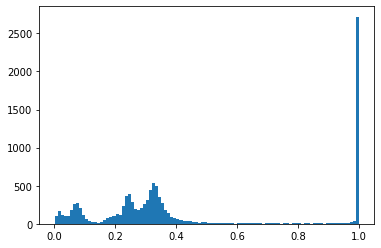

In [61]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [62]:
#%debug

In [63]:
#=====

# Predict and submit

In [64]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [65]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [66]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [67]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [68]:
# ==========================================================
# valid inference
# ==========================================================
def _run_valid_tta(tta_ops):
    seed = CFG.seeds[0]
    valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

    # tta inference
    score_list = []
    pred_valid = pd.DataFrame()
    for fold in CFG.trn_fold:
        print(f"===== valid fold{fold} =====")

        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
        print(pths)

        valid_f = valid[valid.fold == fold]
        print(valid_f.shape)

        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops, is_cr=False)

        ## =============================
        ## tta alb
        ## =============================
        #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        ## =============================
        ## tta Dataset
        ## =============================
        #_test_dataset = TrainDataset(valid_f, 
        #                             transforms=get_transforms(data="valid"),
        #                             #prob_spec_start_random=1.0,
        #                             #prob_vshift=1.0,  # CV悪化
        #                             prob_swap_nega=1.0,  # CV悪化
        #                             is_npy=CFG.is_npy,
        #                             add_ch_type=CFG.add_ch_type,
        #                           )
        #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
        #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
        #
        #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
        #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
        ## =============================

        score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
        score_list.append(score)
        pred_valid = pd.concat([pred_valid, valid_f])

    LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
    tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
    pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
    display(pred_valid.head())

    #if CFG.is_wandb:
    #    # save log wandb
    #    wandb.log({f"TTA oof Score": tta_oof_score})

In [69]:
_run_valid_tta([0,1,2])
_run_valid_tta([0,1])
_run_valid_tta([0,2])
_run_valid_tta([0])

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.13it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1857
TTA fold0 Score: 0.8968


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.13it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.1955
TTA fold1 Score: 0.9180


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.13it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1894
TTA fold2 Score: 0.9027


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.13it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1756
TTA fold3 Score: 0.9001


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:15<00:00,  1.13it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.1738
TTA fold4 Score: 0.9037
macro mean folds Score ± std: 0.9042 ± 0.0073
TTA oof Score: 0.8978


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.998156   
12        NaN        NaN         NaN            NaN       NaN     0.375876   
17        NaN        NaN         NaN            NaN       NaN     0.999516   
18        NaN        NaN         NaN            NaN       NaN     0.998165   
32        NaN        NaN         NaN            NaN       NaN     0.998525   

    preds_freq_min//N_fold0     preds  
5                         6  0.998156  
12                        9  0.375876  
17                        1  0.999516  
18                        1  0.998165  
32                        9  0.998525

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1792
TTA fold0 Score: 0.8955


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.1899
TTA fold1 Score: 0.9160


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1876
TTA fold2 Score: 0.9021


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1770
TTA fold3 Score: 0.8988


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.66it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.1770
TTA fold4 Score: 0.9027
macro mean folds Score ± std: 0.903 ± 0.007
TTA oof Score: 0.8971


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.997888   
12        NaN        NaN         NaN            NaN       NaN     0.376956   
17        NaN        NaN         NaN            NaN       NaN     0.999242   
18        NaN        NaN         NaN            NaN       NaN     0.997256   
32        NaN        NaN         NaN            NaN       NaN     0.998572   

    preds_freq_min//N_fold0     preds  
5                         6  0.997888  
12                        9  0.376956  
17                        1  0.999242  
18                        1  0.997256  
32                        9  0.998572

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.69it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1867
TTA fold0 Score: 0.8955


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.1908
TTA fold1 Score: 0.9171


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1918
TTA fold2 Score: 0.9042


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1789
TTA fold3 Score: 0.8998


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.68it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.1775
TTA fold4 Score: 0.9037
macro mean folds Score ± std: 0.9041 ± 0.0072
TTA oof Score: 0.8972


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.998466   
12        NaN        NaN         NaN            NaN       NaN     0.384282   
17        NaN        NaN         NaN            NaN       NaN     0.999676   
18        NaN        NaN         NaN            NaN       NaN     0.998078   
32        NaN        NaN         NaN            NaN       NaN     0.998541   

    preds_freq_min//N_fold0     preds  
5                         6  0.998466  
12                        9  0.384282  
17                        1  0.999676  
18                        1  0.998078  
32                        9  0.998541

===== valid fold0 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.28it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1816
TTA fold0 Score: 0.8928


===== valid fold1 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.29it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.1899
TTA fold1 Score: 0.9140


===== valid fold2 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth']
(2159, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.29it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1894
TTA fold2 Score: 0.9046


===== valid fold3 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.26it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1807
TTA fold3 Score: 0.8974


===== valid fold4 =====
['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth']
(2158, 40)


========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.29it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.1770
TTA fold4 Score: 0.9020
macro mean folds Score ± std: 0.9021 ± 0.0072
TTA oof Score: 0.8961


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.252390   
12  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.247005   
17  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.250768   
18  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.256312   
32  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  h1_l1_mean  h1_l1_std  fold  \
5   2.253793  0.400924  0.401087          6.0    4.506183   0.802011     0   
12  2.250381  0.398699  0.399798          9.0    4.497386   0.798497     0   
17  2.253459  0.403756  0.401150          1.0    4.504227   0.804906     0   
18  2.249809  0.401606  0.402489          1.0    4.506121   0.804095     0   
32  2.257342  0.408922  0.412729          9.0    4.514927   0.821651     0   

    sqrtSX  F0 type dir_name  F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  \
5      NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
12     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
17     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
18     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   
32     NaN NaN  NaN      NaN NaN    NaN        NaN        NaN         NaN   

    l1_minstd  l1_maxstd  l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  \
5         NaN        NaN         NaN            NaN       NaN     0.998328   
12        NaN        NaN         NaN            NaN       NaN     0.394955   
17        NaN        NaN         NaN            NaN       NaN     0.999467   
18        NaN        NaN         NaN            NaN       NaN     0.995505   
32        NaN        NaN         NaN            NaN       NaN     0.998646   

    preds_freq_min//N_fold0     preds  
5                         6  0.998328  
12                        9  0.394955  
17                        1  0.999467  
18                        1  0.995505  
32                        9  0.998646

In [70]:
#%debug

In [71]:
#=====

In [72]:
def _run_test_tta(tta_ops):
    if IS_MAKE_SUB:
        # model pths
        pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
        #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
        print(pths)

        # 'h0deg//10'列無いとエラーになるので入れとく
        test_df['h0deg//10'] = 0

        # ==========================================================
        # test inference
        # ==========================================================
        if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
            transforms_type = 'valid_norm'
        else:
            transforms_type = 'valid'
        #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
        submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type, tta_ops=tta_ops)

        ## =============================
        ## tta alb
        ## =============================
        #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
        #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
        #
        #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
        #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
        ## =============================

        submit["target"] = submit["preds"].to_numpy()
        display(submit.head())
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)

        submit = submit[["id", "target"]]
        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

        # Write prediction
        submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission_tta{"".join([str(_) for _ in tta_ops])}.csv', index=False)
        display(submit)

        plt.hist(submit["target"], bins=100)
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex07

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1776


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.2006


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1996


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:54<00:00,  1.15it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1916


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:55<00:00,  1.14it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.2030


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.302248   
1  1.248537e+09         42746.0  0.402560   
2  1.248567e+09         55878.0  0.310648   
3  1.248537e+09         48020.0  0.769479   
4  1.248543e+09         45246.0  0.822901   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.347017   
1         0          2.0    4.503615   0.799438          0     0.422703   
2         0          3.0    4.500148   0.800086          0     0.364531   
3         0          1.0    4.502120   0.799486          0     0.641070   
4         0          9.0    4.500598   0.802849          0     0.684963   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        9     0.321545                        3     0.248626   
1                        9     0.379248                        3     0.314272   
2                        4     0.316030                        7     0.264954   
3                        1     0.685019                        2     0.784791   
4                        1     0.804025                        1     0.858777   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.330024                        6     0.264029   
1                        7     0.513228                        6     0.383349   
2                        7     0.333927                        6     0.273797   
3                        1     0.909836                        2     0.826682   
4                        2     0.904143                        1     0.862594   

   preds_freq_min//N_fold4     preds  
0                        3  0.302248  
1                      

target range [0.000416, 0.999984]


id    target
0     00054c878  0.302248
1     0007285a3  0.402560
2     00076c5a6  0.310648
3     001349290  0.769479
4     001a52e92  0.822901
...         ...       ...
7970  ffbce04ef  0.997614
7971  ffc2d976b  0.320474
7972  ffc905909  0.321747
7973  ffe276f3e  0.344039
7974  fffa17f67  0.334703

[7975 rows x 2 columns]

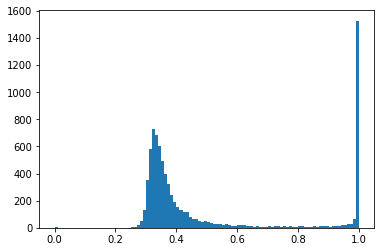

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex07

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1781


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.2025


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1974


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1872


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 1]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.2004


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.298550   
1  1.248537e+09         42746.0  0.382676   
2  1.248567e+09         55878.0  0.313723   
3  1.248537e+09         48020.0  0.676741   
4  1.248543e+09         45246.0  0.852944   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.336471   
1         0          2.0    4.503615   0.799438          0     0.395844   
2         0          3.0    4.500148   0.800086          0     0.373539   
3         0          1.0    4.502120   0.799486          0     0.499491   
4         0          9.0    4.500598   0.802849          0     0.674944   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        7     0.319548                        3     0.247533   
1                        9     0.379980                        3     0.305470   
2                        4     0.315336                        7     0.268236   
3                        2     0.561051                        2     0.707469   
4                        1     0.850406                        1     0.917836   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.325807                        6     0.263393   
1                        7     0.454379                        1     0.377705   
2                        7     0.343178                        6     0.268328   
3                        1     0.854358                        2     0.761339   
4                        2     0.933646                        1     0.887888   

   preds_freq_min//N_fold4     preds  
0                        3  0.298550  
1                      

target range [0.000449, 0.999985]


id    target
0     00054c878  0.298550
1     0007285a3  0.382676
2     00076c5a6  0.313723
3     001349290  0.676741
4     001a52e92  0.852944
...         ...       ...
7970  ffbce04ef  0.997156
7971  ffc2d976b  0.315737
7972  ffc905909  0.328056
7973  ffe276f3e  0.344336
7974  fffa17f67  0.337909

[7975 rows x 2 columns]

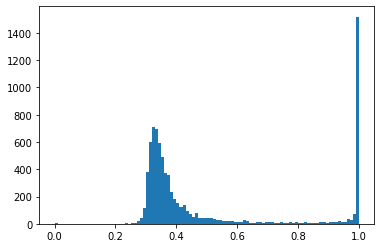

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex07

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1739


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.2029


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1976


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1906


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0, 2]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:36<00:00,  1.71it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.2004


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.303957   
1  1.248537e+09         42746.0  0.415029   
2  1.248567e+09         55878.0  0.309258   
3  1.248537e+09         48020.0  0.811989   
4  1.248543e+09         45246.0  0.790230   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.347656   
1         0          2.0    4.503615   0.799438          0     0.433042   
2         0          3.0    4.500148   0.800086          0     0.364995   
3         0          1.0    4.502120   0.799486          0     0.715922   
4         0          9.0    4.500598   0.802849          0     0.632281   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        9     0.323594                        7     0.251849   
1                        9     0.381065                        3     0.311505   
2                        4     0.318362                        7     0.262086   
3                        1     0.749415                        2     0.819669   
4                        1     0.801124                        2     0.838113   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.333548                        6     0.263139   
1                        7     0.554190                        7     0.395342   
2                        7     0.326708                        6     0.274138   
3                        1     0.937847                        2     0.837090   
4                        1     0.843239                        1     0.836393   

   preds_freq_min//N_fold4     preds  
0                        3  0.303957  
1                      

target range [0.000356, 0.999982]


id    target
0     00054c878  0.303957
1     0007285a3  0.415029
2     00076c5a6  0.309258
3     001349290  0.811989
4     001a52e92  0.790230
...         ...       ...
7970  ffbce04ef  0.998031
7971  ffc2d976b  0.323480
7972  ffc905909  0.316258
7973  ffe276f3e  0.346918
7974  fffa17f67  0.330388

[7975 rows x 2 columns]

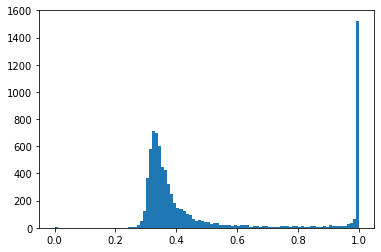

['/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex07

========== TEST ==========


valid_norm
pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.37it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold0_seed0_best_score Accuracy: 0.1718


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold1_seed0_best_score Accuracy: 0.1989


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.36it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold2_seed0_best_score Accuracy: 0.1954


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.39it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold3_seed0_best_score Accuracy: 0.1829


pth: /volume/kaggle/g2net2/output/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2/3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score.pth


tta_ops: [0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]
freq_min//N 3090_kqi_ex075_v2_tta_v4_norm_stride12_lb0771_pseudo_th_5_10_100ep_addD_EX007_2_fold4_seed0_best_score Accuracy: 0.1994


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.298283   
1  1.248537e+09         42746.0  0.387779   
2  1.248567e+09         55878.0  0.314003   
3  1.248537e+09         48020.0  0.684597   
4  1.248543e+09         45246.0  0.823068   

                                                path  orig  freq_min//10  \
0  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          30.0   
1  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          12.0   
2  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          19.0   
3  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1           9.0   
4  /volume-ssd/kaggle_g2net2/npys/largekernel|p-r...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h1_l1_mean  h1_l1_std  h0deg//10  preds_fold0  \
0         0          6.0    4.498665   0.795017          0     0.327326   
1         0          2.0    4.503615   0.799438          0     0.389488   
2         0          3.0    4.500148   0.800086          0     0.383583   
3         0          1.0    4.502120   0.799486          0     0.526114   
4         0          9.0    4.500598   0.802849          0     0.553609   

   preds_freq_min//N_fold0  preds_fold1  preds_freq_min//N_fold1  preds_fold2  \
0                        9     0.321634                        3     0.252878   
1                        9     0.384357                        1     0.291464   
2                        4     0.319304                        7     0.265738   
3                        2     0.586872                        2     0.713623   
4                        1     0.883636                        2     0.937002   

   preds_freq_min//N_fold2  preds_fold3  preds_freq_min//N_fold3  preds_fold4  \
0                        7     0.328592                        6     0.260984   
1                        7     0.477633                        1     0.395955   
2                        7     0.337798                        6     0.263595   
3                        1     0.884063                        2     0.712313   
4                        1     0.872233                        1     0.868862   

   preds_freq_min//N_fold4     preds  
0                        3  0.298283  
1                      

target range [0.000356, 0.999982]


id    target
0     00054c878  0.298283
1     0007285a3  0.387779
2     00076c5a6  0.314003
3     001349290  0.684597
4     001a52e92  0.823068
...         ...       ...
7970  ffbce04ef  0.997736
7971  ffc2d976b  0.317078
7972  ffc905909  0.323280
7973  ffe276f3e  0.350388
7974  fffa17f67  0.332266

[7975 rows x 2 columns]

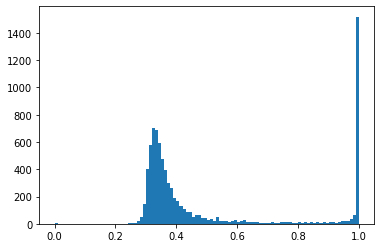

In [73]:
_run_test_tta([0,1,2])
_run_test_tta([0,1])
_run_test_tta([0,2])
_run_test_tta([0])

In [74]:
if CFG.is_wandb:
    wandb.finish()

In [75]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [76]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    if (CFG.alb_norm_mean_th > 0) or (CFG.alb_norm_std_th > 0):
#        transforms_type = 'valid_norm'
#    else:
#        transforms_type = 'valid'
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type=transforms_type)
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [77]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()